# Stock Market Analysis for ICICI Bank Stock

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from pandas import Grouper
from pandas.plotting import lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

### Extracting the Historical data for last 5 years

In [2]:
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today().replace(year=datetime.today().year - 5)).strftime('%Y-%m-%d')
historical_data = yf.download("ICICIBANK.NS", start=start_date, end=end_date)
historical_data

[*********************100%***********************]  1 of 1 completed


Price             Close         High          Low         Open       Volume
Ticker     ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS ICICIBANK.NS
Date                                                                       
2020-01-17   514.310669   520.062299   512.909002   516.678994     18312609
2020-01-20   517.017334   525.862284   513.295722   515.229039     19159996
2020-01-21   513.343994   522.237264   512.522358   515.180669     13477994
2020-01-22   505.417389   517.113993   503.387430   513.779009     17527408
2020-01-23   510.105713   512.570680   499.810776   504.015776     17061293
...                 ...          ...          ...          ...          ...
2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000      7854524
2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024      9669336
2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976     10342698
2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000      5355382
2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976     11895924

[1238 rows x 5 columns]

## EDA

In [3]:
# We can see that there are multiple indexes
# 'Ticker' index is unwanted and Name of the index 'Price' is also unwanted
historical_data.columns

MultiIndex([( 'Close', 'ICICIBANK.NS'),
            (  'High', 'ICICIBANK.NS'),
            (   'Low', 'ICICIBANK.NS'),
            (  'Open', 'ICICIBANK.NS'),
            ('Volume', 'ICICIBANK.NS')],
           names=['Price', 'Ticker'])

In [4]:
# Removing the 'Ticker' index and Index name 'Price'
historical_data.columns = historical_data.columns.droplevel('Ticker')
historical_data.columns.name = None
historical_data

Close         High          Low         Open    Volume
Date                                                                    
2020-01-17   514.310669   520.062299   512.909002   516.678994  18312609
2020-01-20   517.017334   525.862284   513.295722   515.229039  19159996
2020-01-21   513.343994   522.237264   512.522358   515.180669  13477994
2020-01-22   505.417389   517.113993   503.387430   513.779009  17527408
2020-01-23   510.105713   512.570680   499.810776   504.015776  17061293
...                 ...          ...          ...          ...       ...
2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524
2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336
2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698
2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382
2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924

[1238 rows x 5 columns]

In [5]:
historical_data.info()
# There are 1238 entries with 5 columns
# Only 'Volume' column is of the int64 dtype
# All the other columns are of the float64 dtype

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1238 entries, 2020-01-17 to 2025-01-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1238 non-null   float64
 1   High    1238 non-null   float64
 2   Low     1238 non-null   float64
 3   Open    1238 non-null   float64
 4   Volume  1238 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.0 KB


In [6]:
historical_data.describe()
# Outliers might be present for some of the columns

Close         High          Low         Open        Volume
count  1238.000000  1238.000000  1238.000000  1238.000000  1.238000e+03
mean    785.233493   793.255430   776.902156   785.189238  1.960249e+07
std     271.477164   272.413427   270.420447   271.090116  1.384527e+07
min     274.531067   287.967586   259.354503   274.531017  1.007022e+06
25%     600.198349   607.701958   589.214666   597.576286  1.095214e+07
50%     785.964783   793.575242   776.888817   786.643436  1.513405e+07
75%     951.297958   960.530960   944.573663   952.314025  2.340348e+07
max    1346.099976  1362.349976  1340.050049  1344.900024  1.259394e+08

In [7]:
# Missing Values
historical_data.isna().sum()
# No missing values present

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

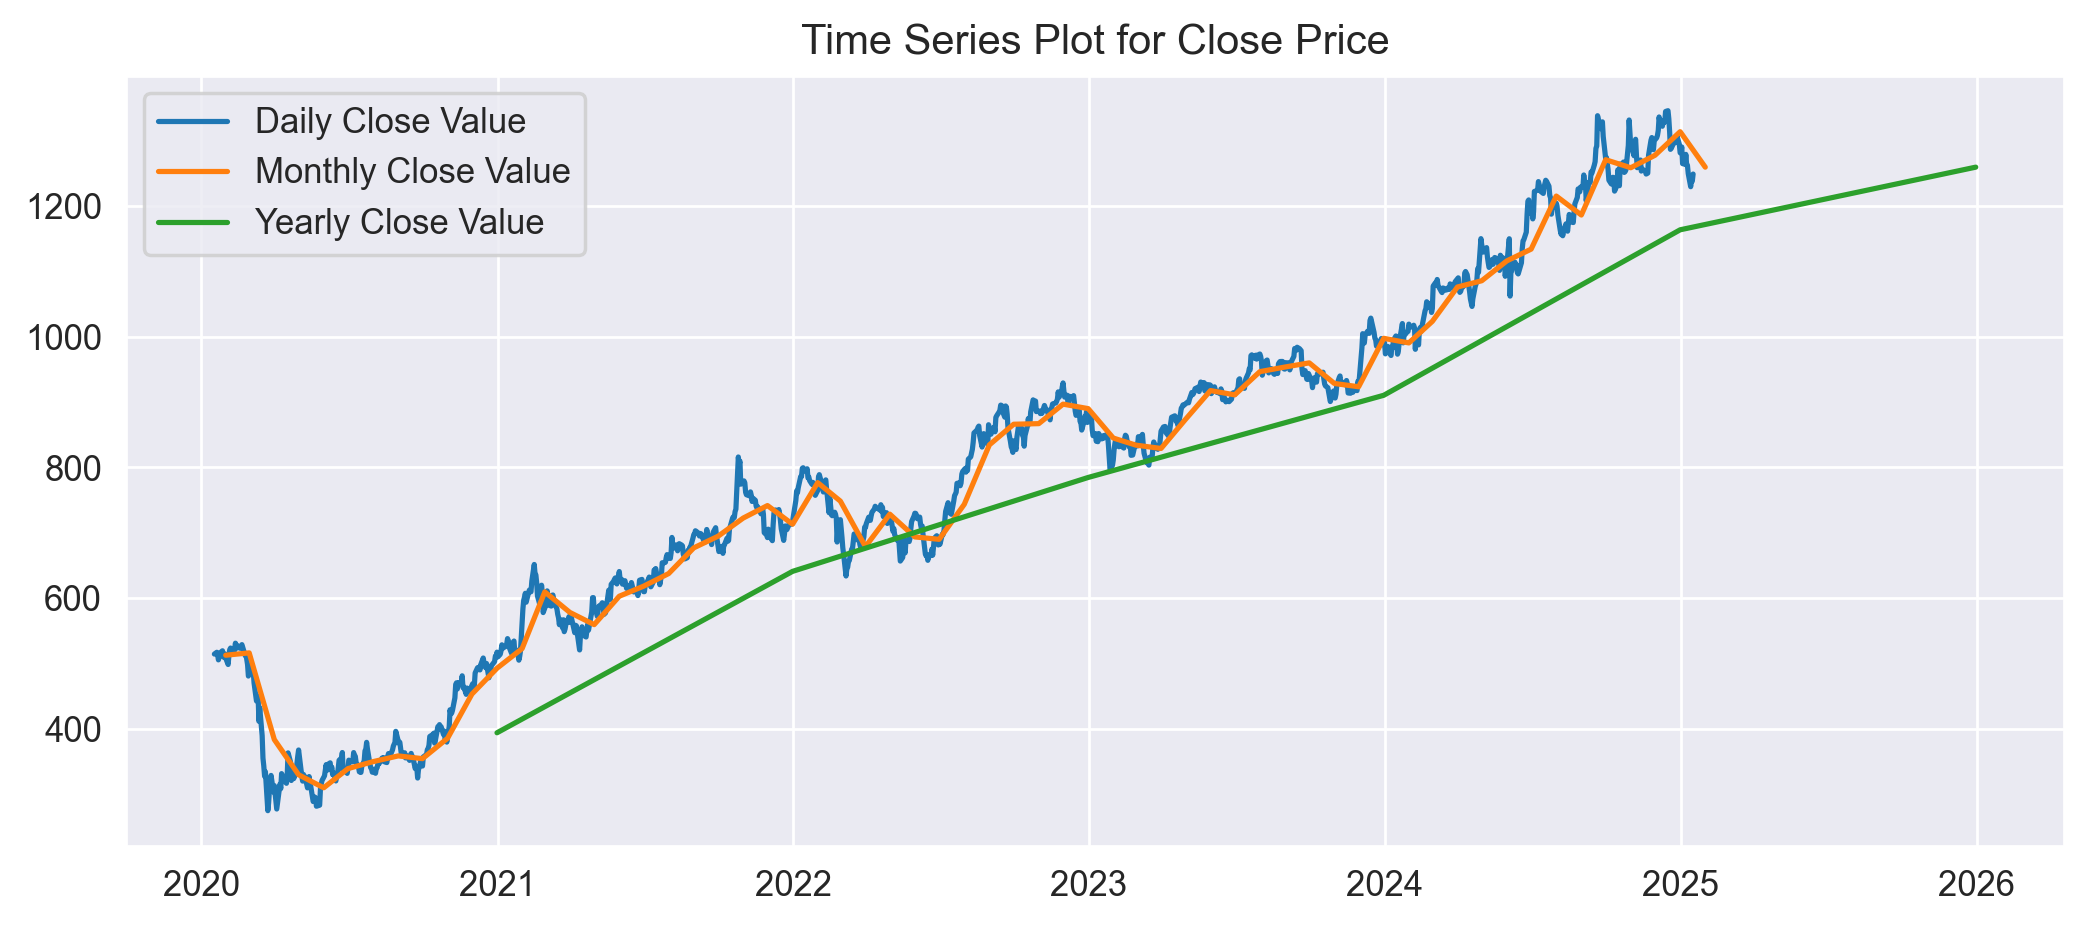

In [8]:
# Visualization: Time Series plot for Close Price
plt.figure(figsize=(10, 4))
plt.title('Time Series Plot for Close Price')
plt.plot(historical_data['Close'], label='Daily Close Value')
plt.plot(historical_data['Close'].resample('M').mean(), label='Monthly Close Value')
plt.plot(historical_data['Close'].resample('Y').mean(), label='Yearly Close Value')
plt.legend()
plt.show()
# We can see that there is an upward trend

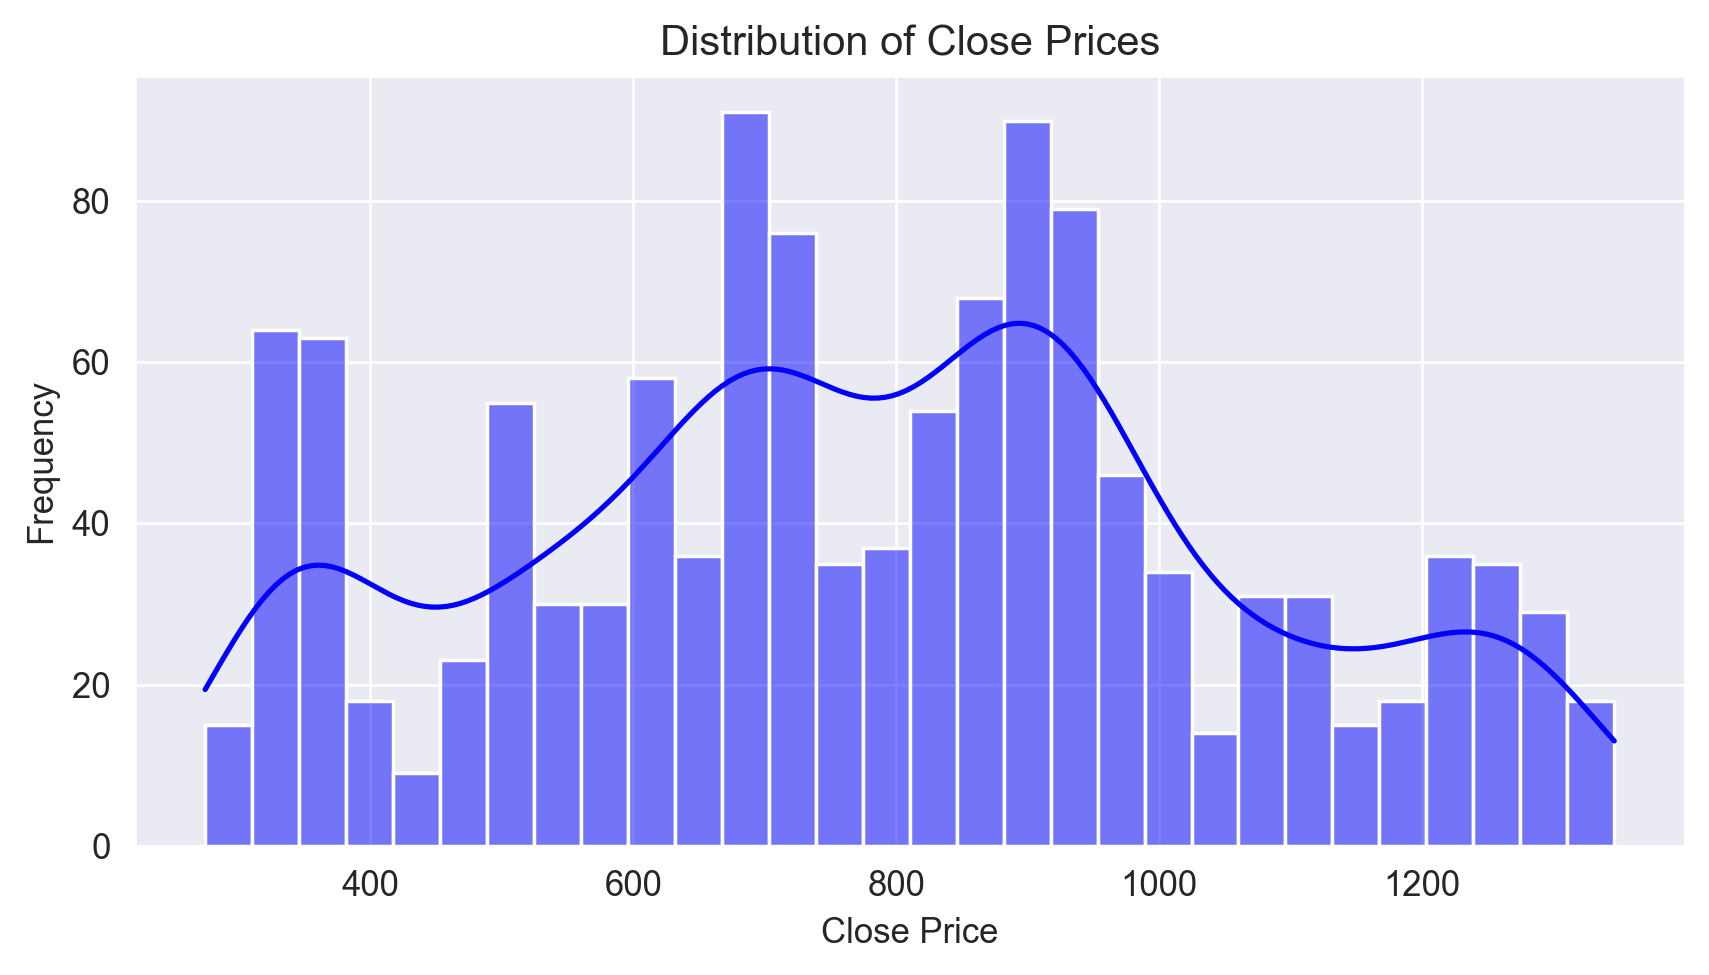

In [9]:
# Visualization: Distribution of Close prices
plt.figure(figsize=(8, 4))
sns.histplot(historical_data['Close'], kde=True, bins=30, color='blue')
plt.title("Distribution of Close Prices")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.show()

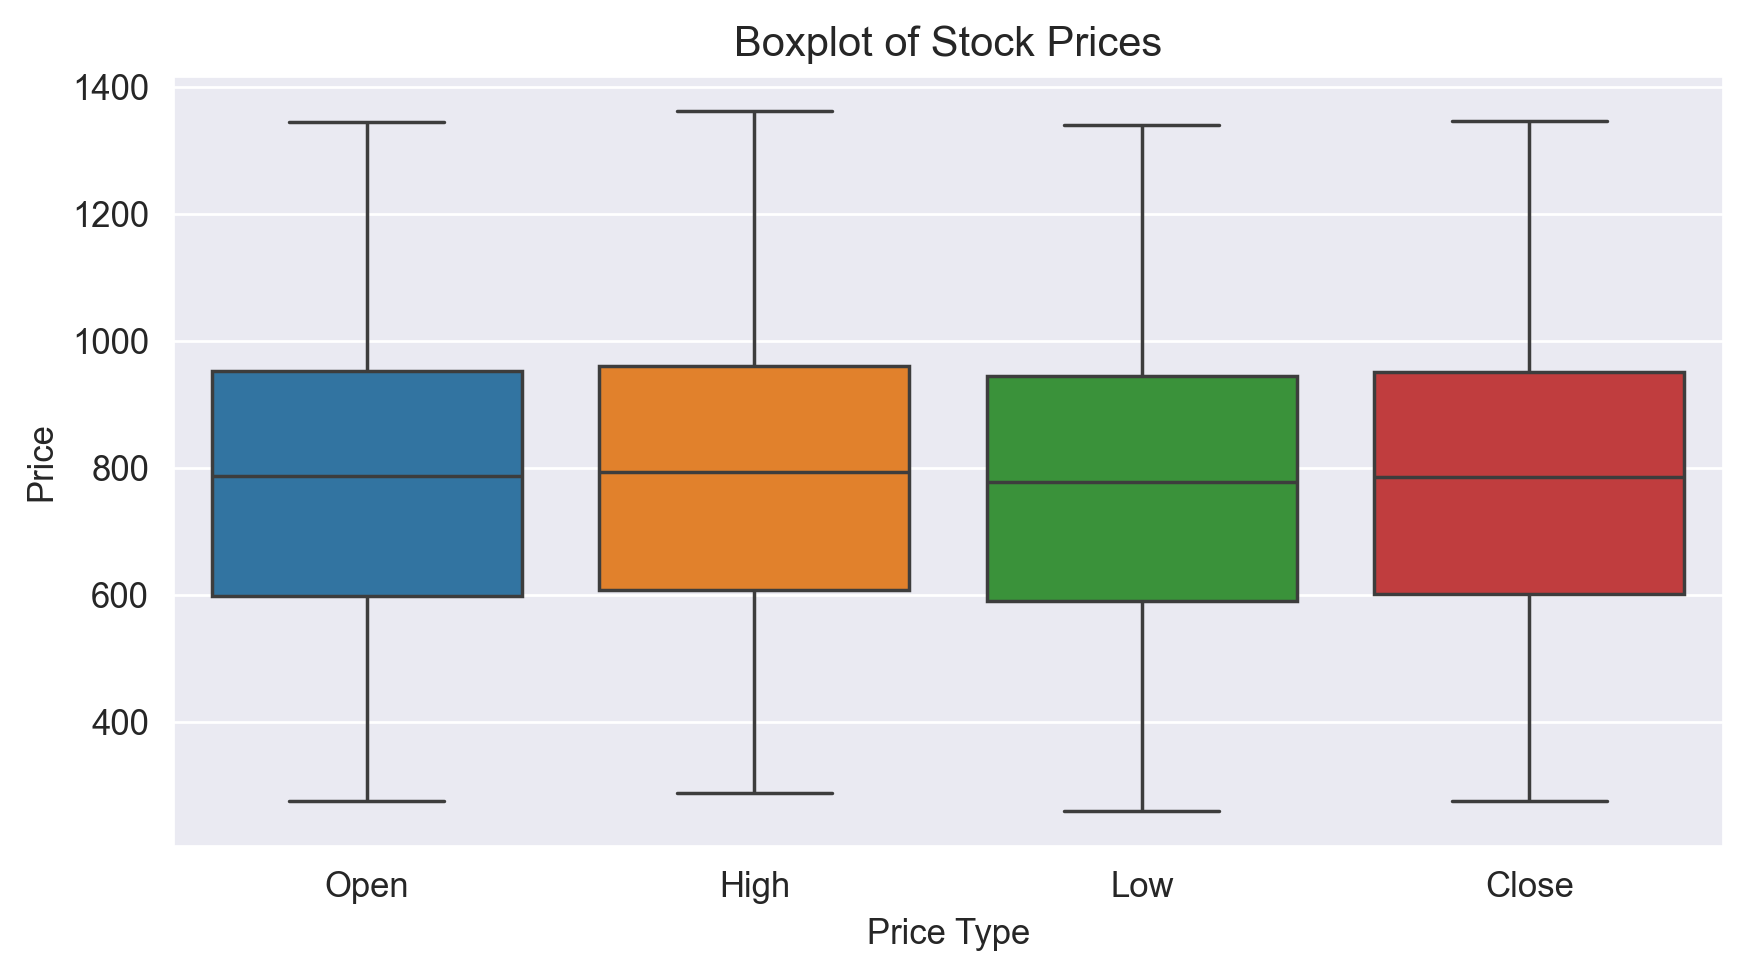

In [10]:
# Visualization: Boxplot for Price Range (High, Low, Close, Open)
plt.figure(figsize=(8, 4))
sns.boxplot(data=historical_data[['Open', 'High', 'Low', 'Close']])
plt.title("Boxplot of Stock Prices")
plt.xlabel("Price Type")
plt.ylabel("Price")
plt.show()
# No outliers present in Close, Open, High and Low columns

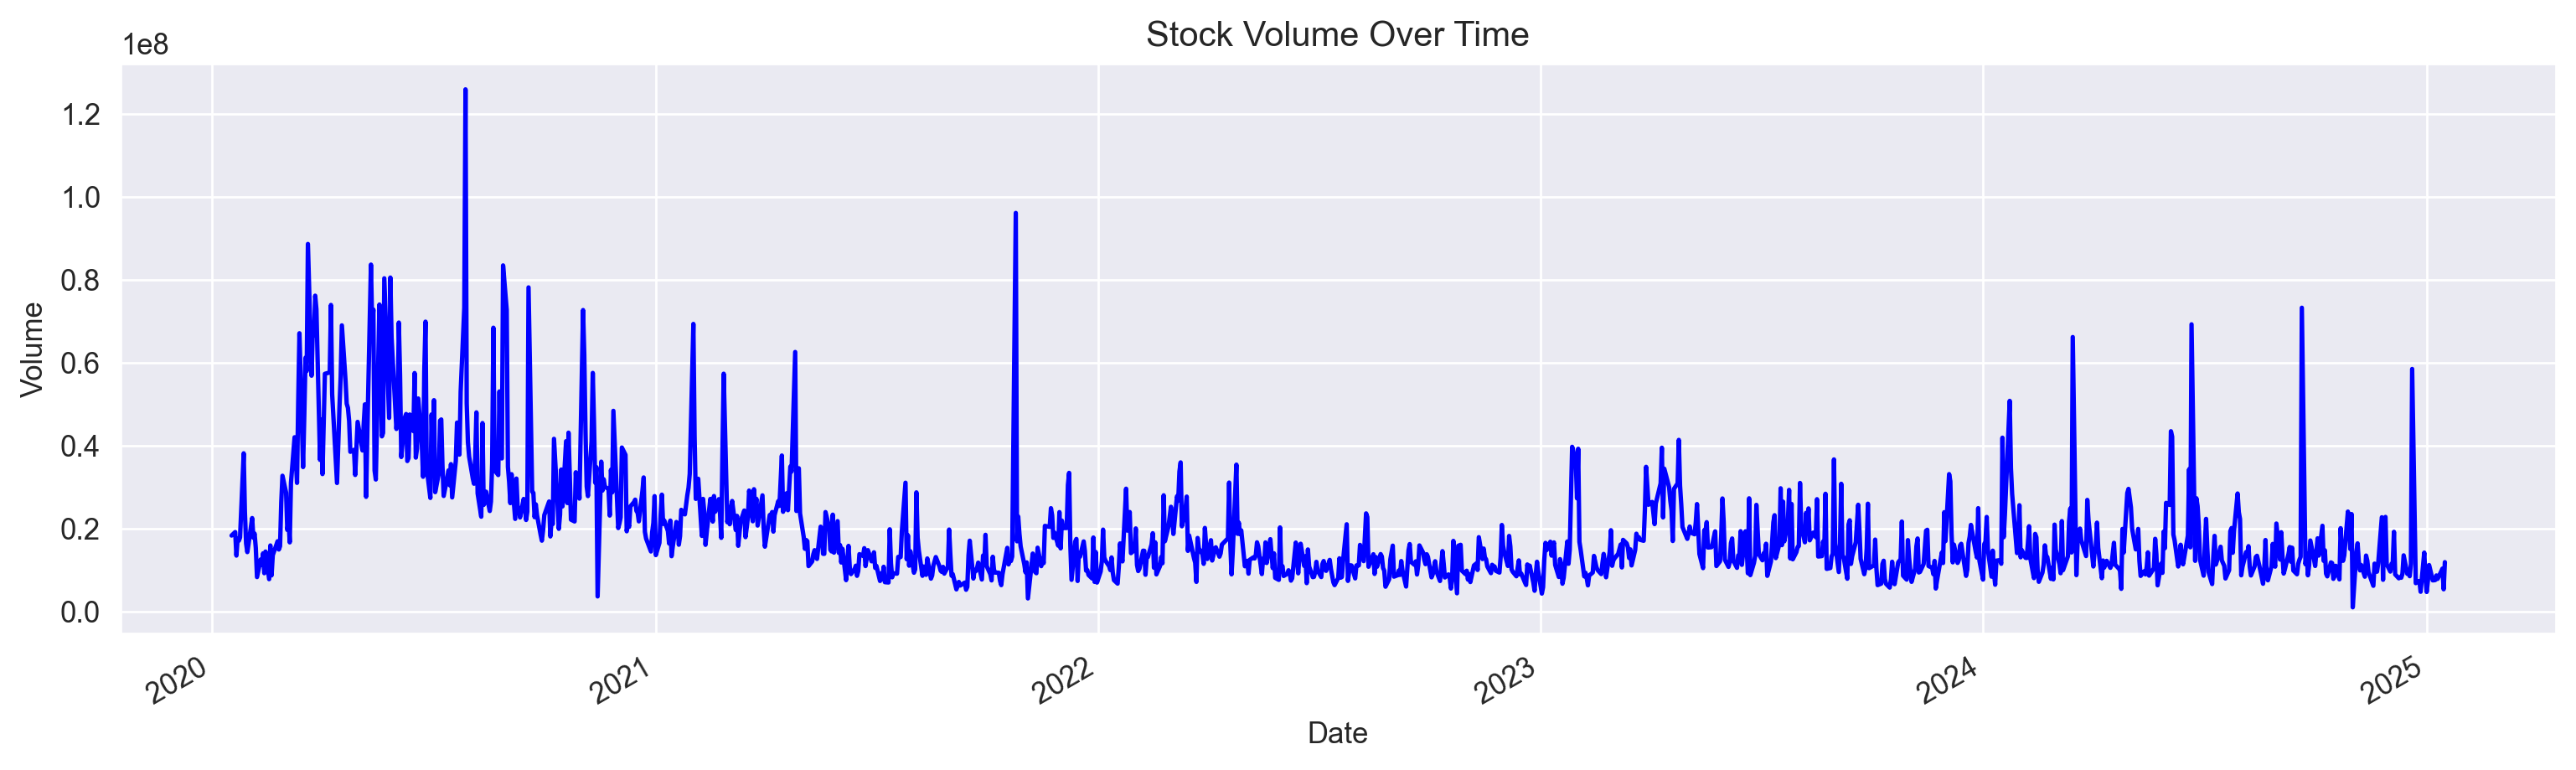

In [11]:
# Visualization: Volume over time
plt.figure(figsize=(15, 4))
historical_data['Volume'].plot(kind='line', color='blue')
plt.title("Stock Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

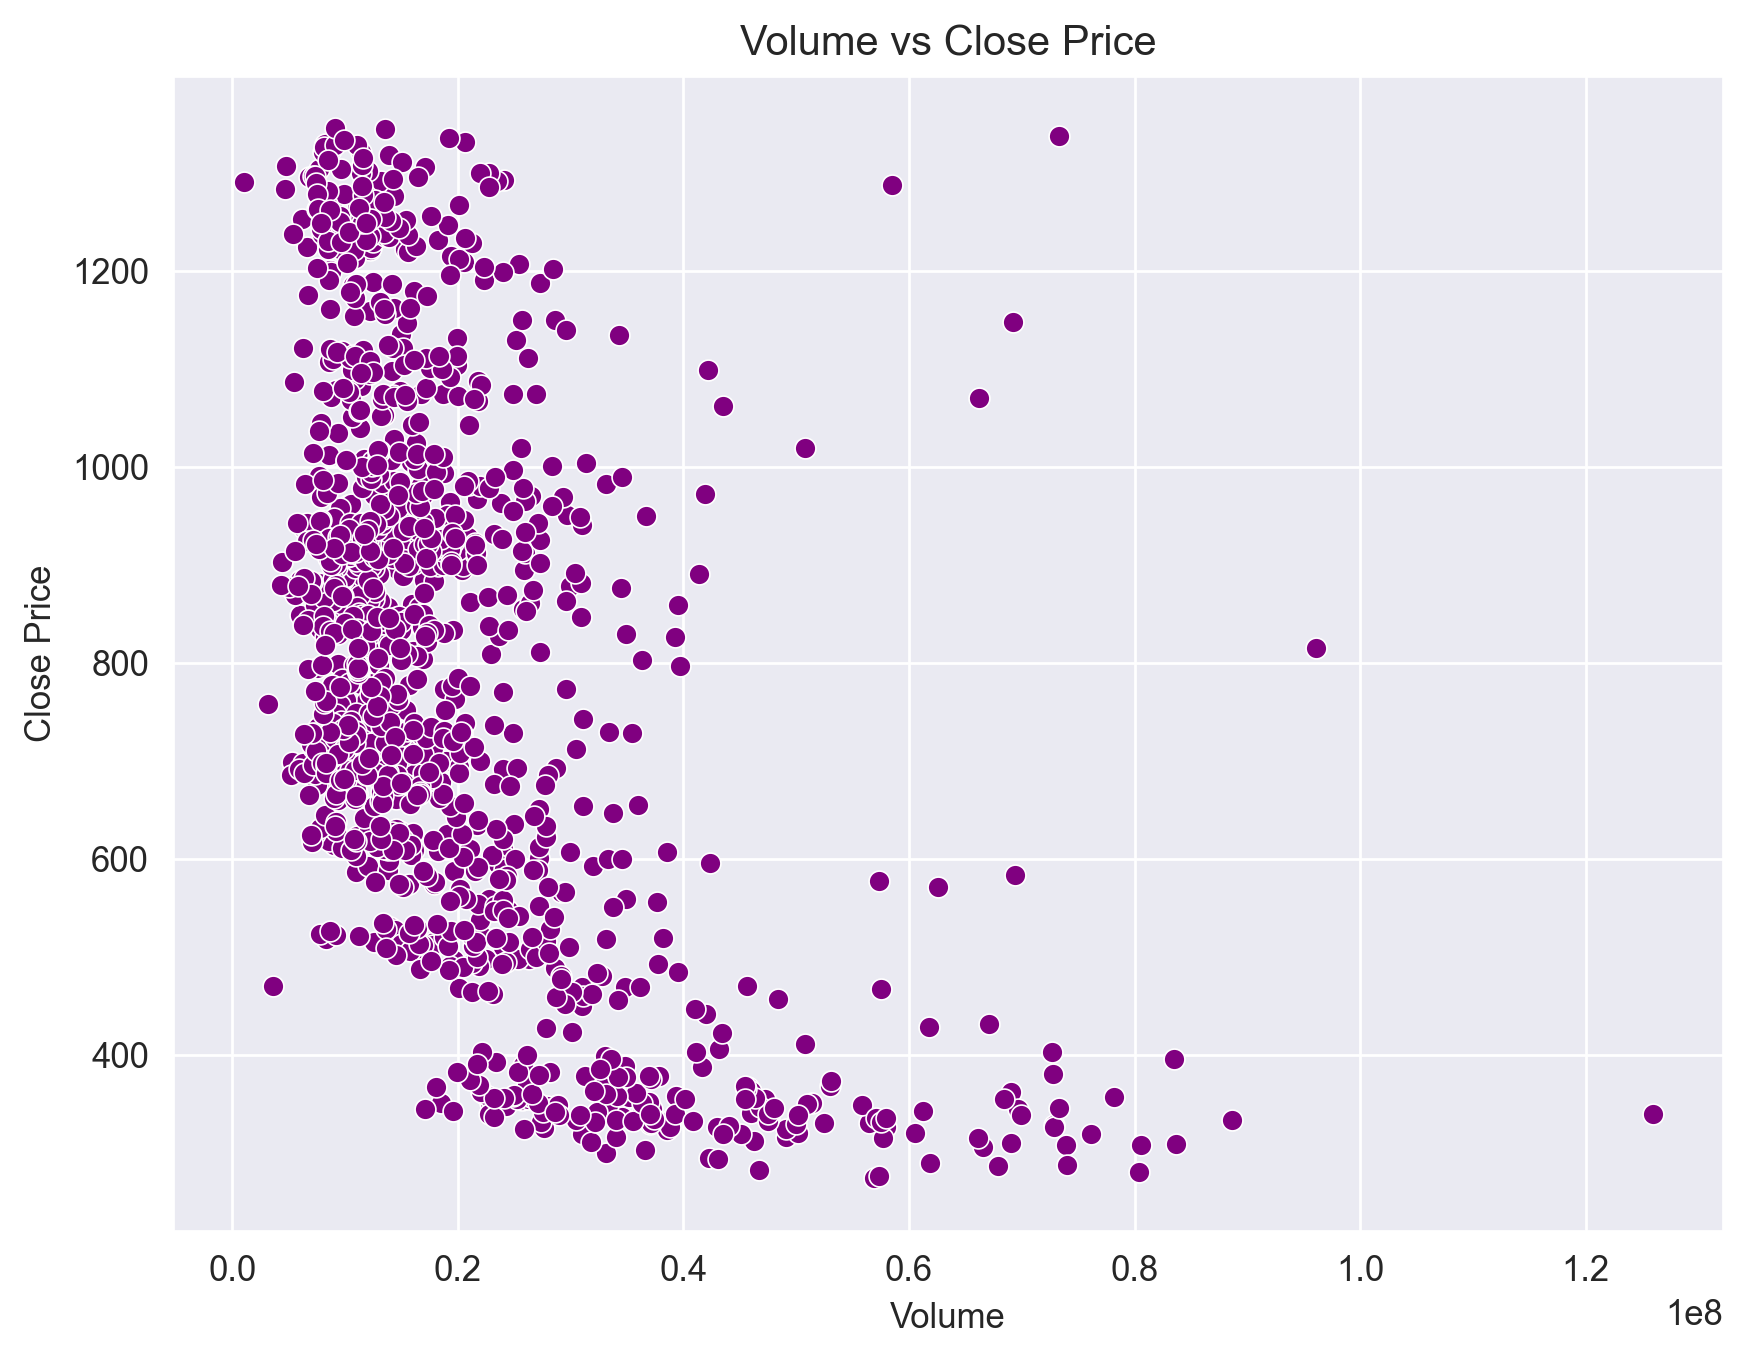

In [12]:
# Visualization: Scatter plot of Volume vs Close
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Volume', y='Close', data=historical_data, color='purple')
plt.title("Volume vs Close Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.show()
# For Higher Close Price range of volume is lower

## Lag plots

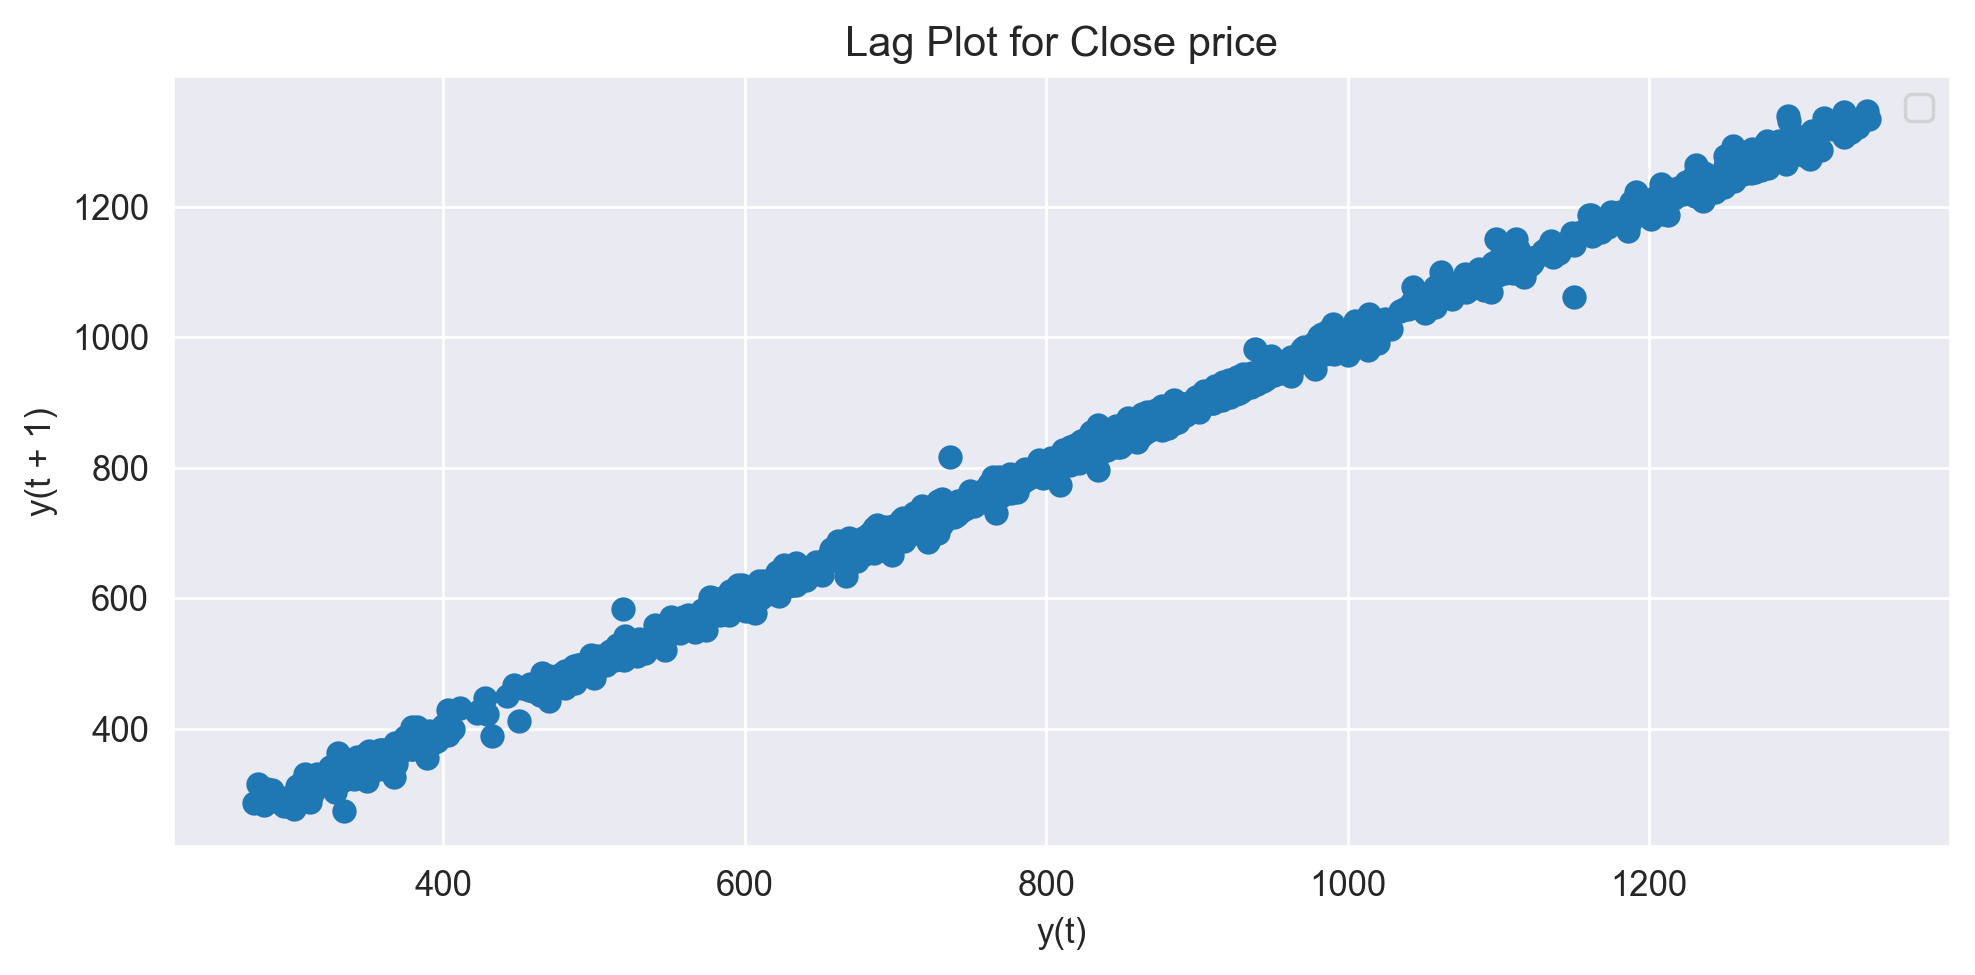

In [13]:
plt.figure(figsize=(8, 4))
plt.title('Lag Plot for Close price')
lag_plot(historical_data['Close'])
plt.legend()
plt.tight_layout()
plt.show()
# As the points cluster along a diagonal line from bootom-left to the top-right of the plot for each of the columns
# It suggests a positive correlation relationship

## Correlation Heatmap

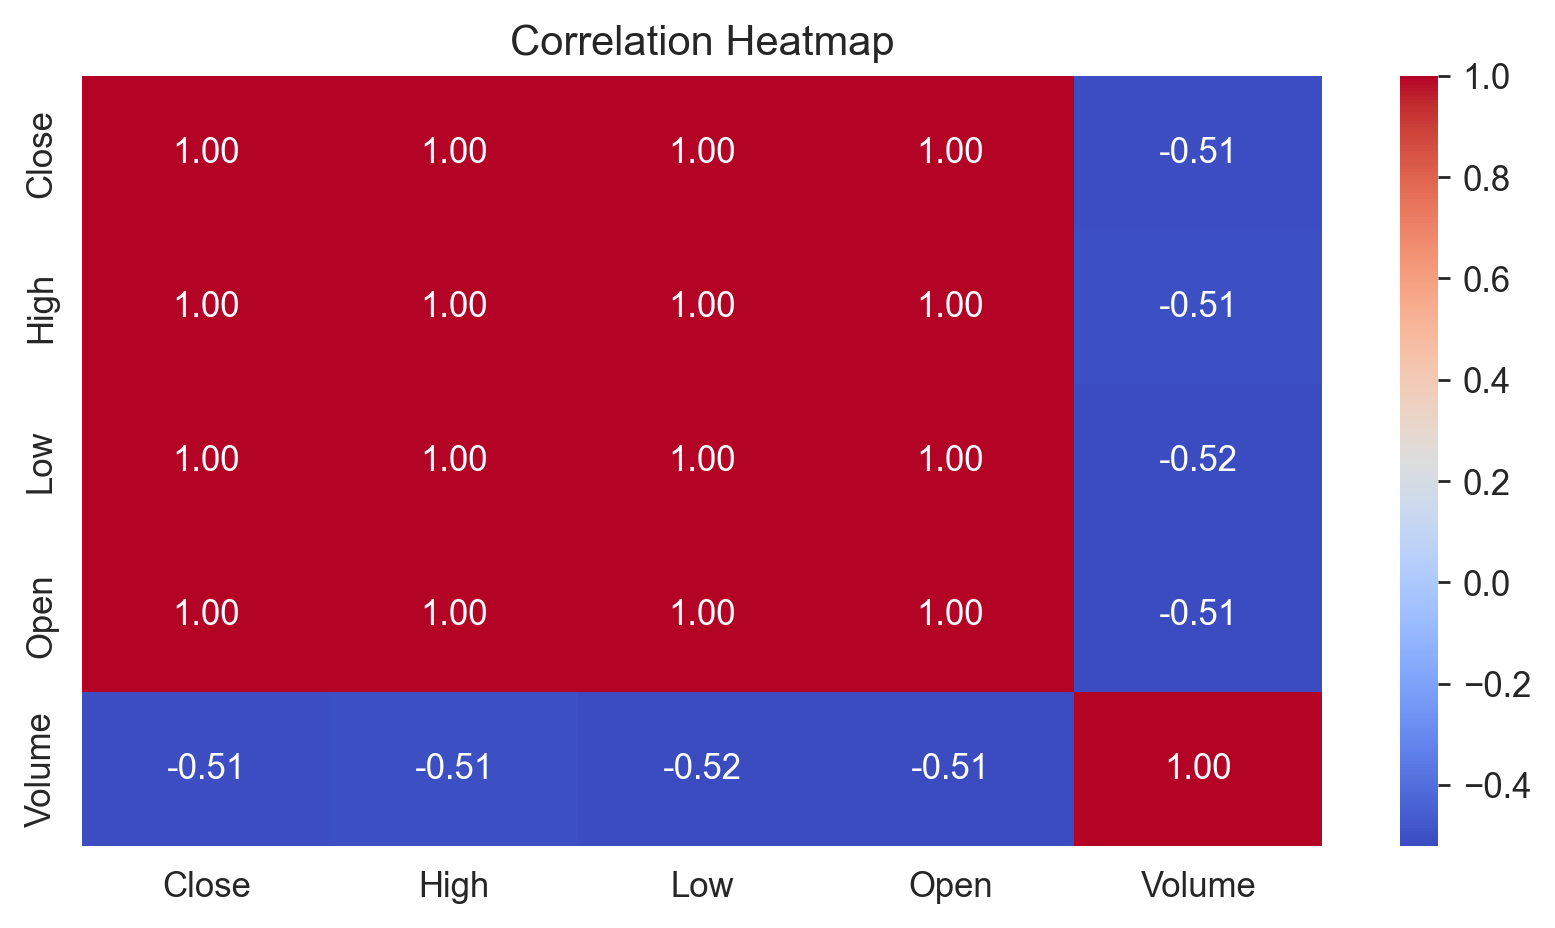

In [14]:
# Visualization: Correlation heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(historical_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()
# Open, Close, High and Low columns are perfectly correlated to each other
# However, Volume column is negatively and partially correlated to those four columns

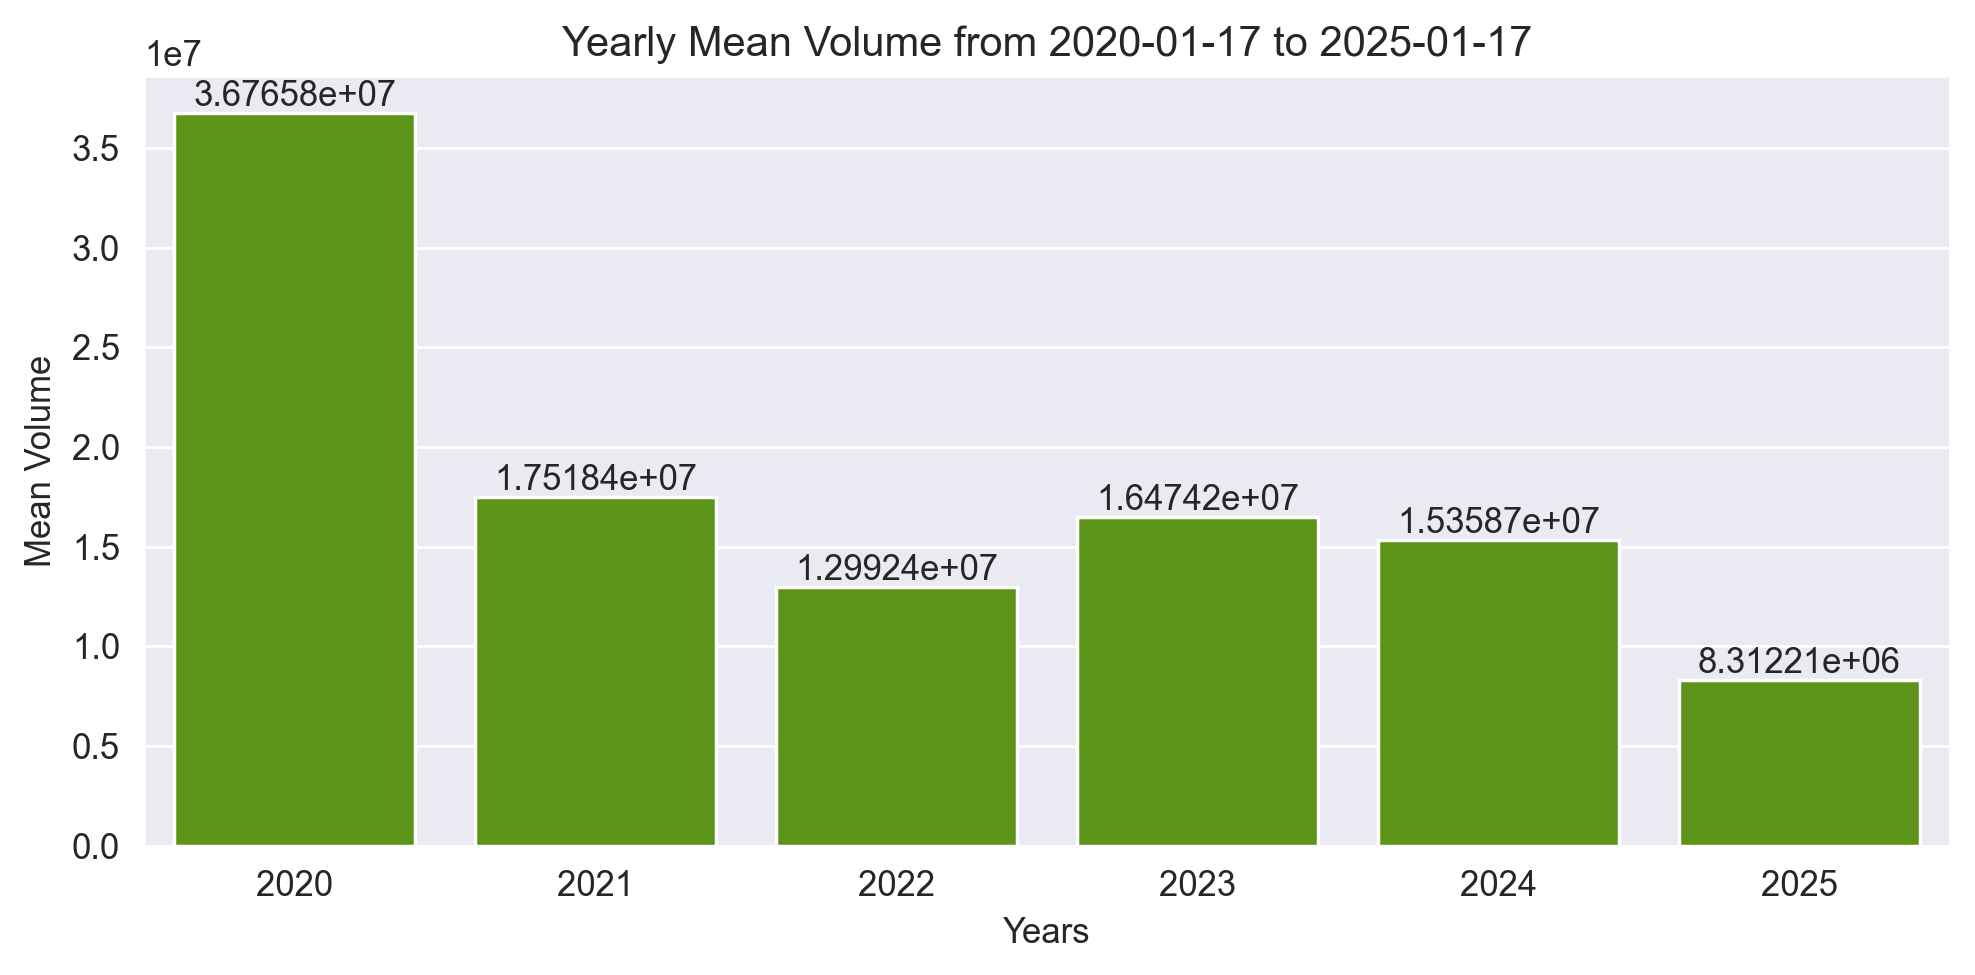

In [15]:
# Yearwise mean volume
plt.figure(figsize=(8, 4))
groups = historical_data['Volume'].groupby(Grouper(freq='A'))
years={}
for name, group in groups:
    years[name.year] = group.values
yearwise_Volume = {}
for i in years:
    yearwise_Volume[i] = years[i].mean()

ax=sns.barplot(x=yearwise_Volume.keys(), y=yearwise_Volume.values(), color='#5CA904')
plt.xlabel('Years')
plt.ylabel('Mean Volume')
plt.title('Yearly Mean Volume from '+str(start_date)+' to '+str(end_date))
for i in ax.containers:
    ax.bar_label(i,)
plt.tight_layout()
plt.show()
# In the year 2020, volume is much more (effect of covid-19 probably)

## Time Series Analysis - Seasonal Decompose

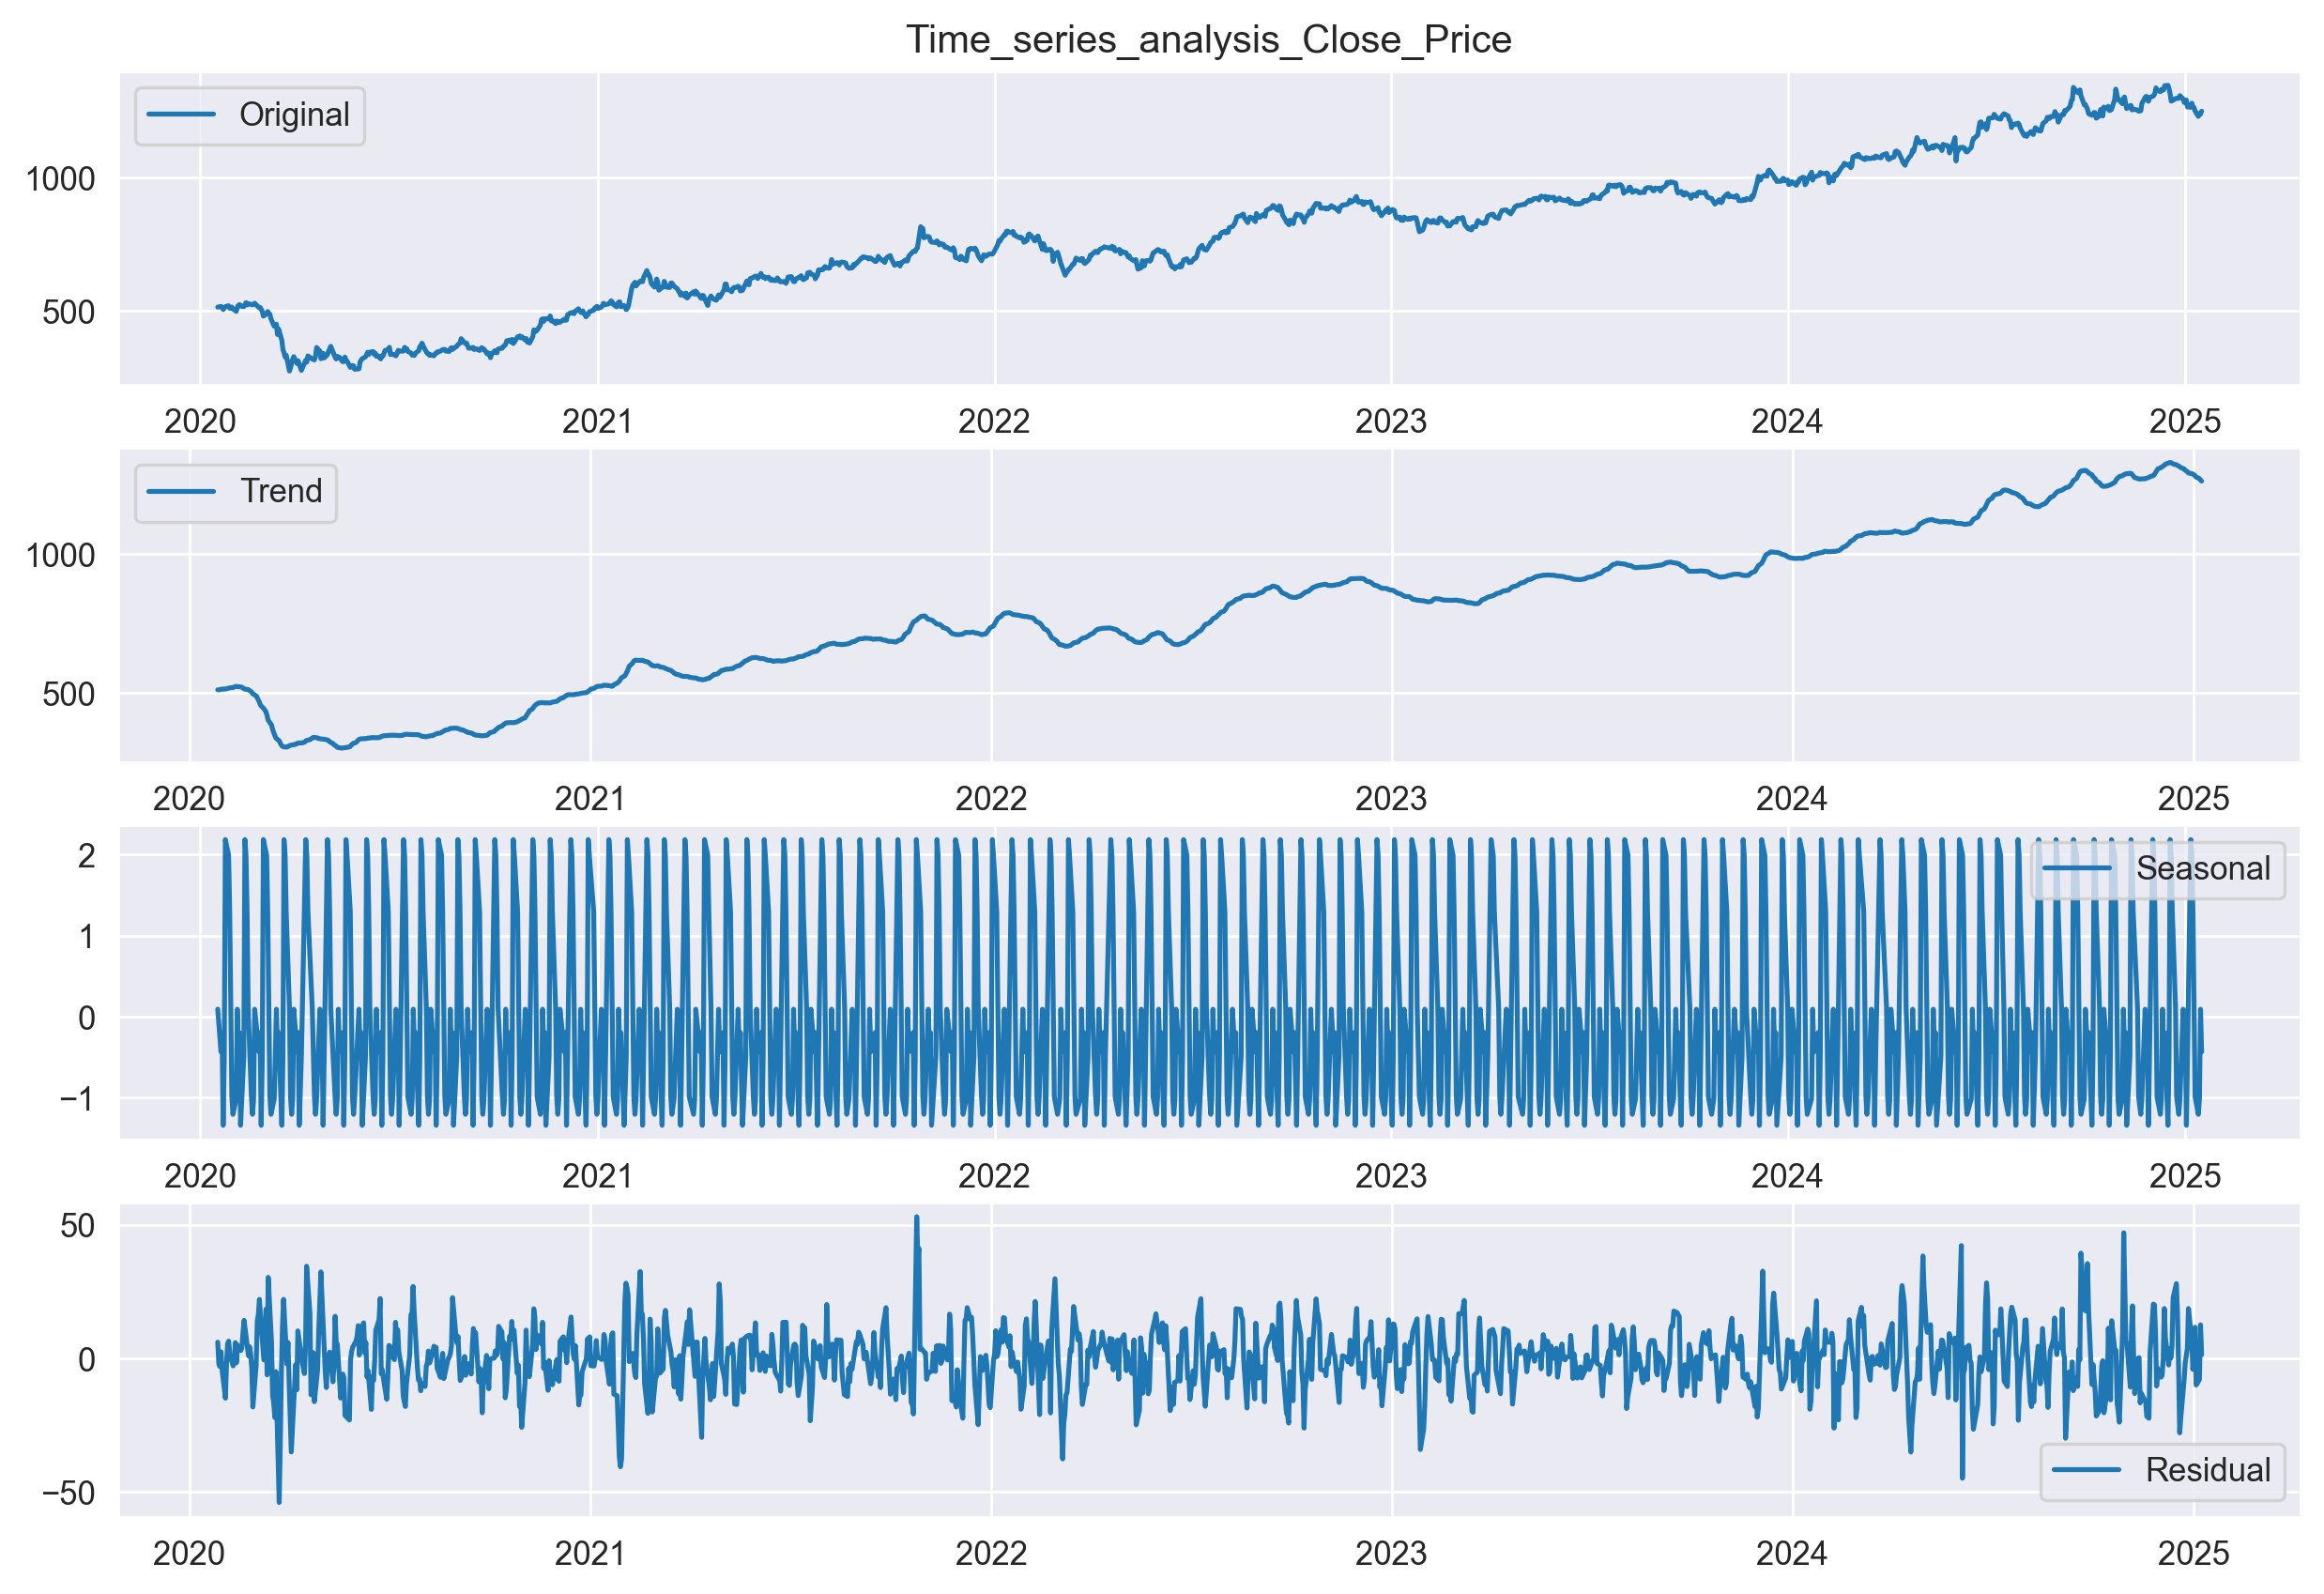

In [16]:
# Perform seasonal decomposition(period = 12 months)
decomposition = seasonal_decompose(historical_data['Close'], model='additive', period=12)

# Plot the original time series
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.title('Time_series_analysis_Close_Price')
plt.plot(historical_data['Close'], label='Original')
plt.legend()

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.show()

# We can see that there is an upward trend
# Some Seasonality also present
# Residuals also present

## Auto Correlation and Partial Auto Correlation Plots

<Figure size 2000x1000 with 0 Axes>

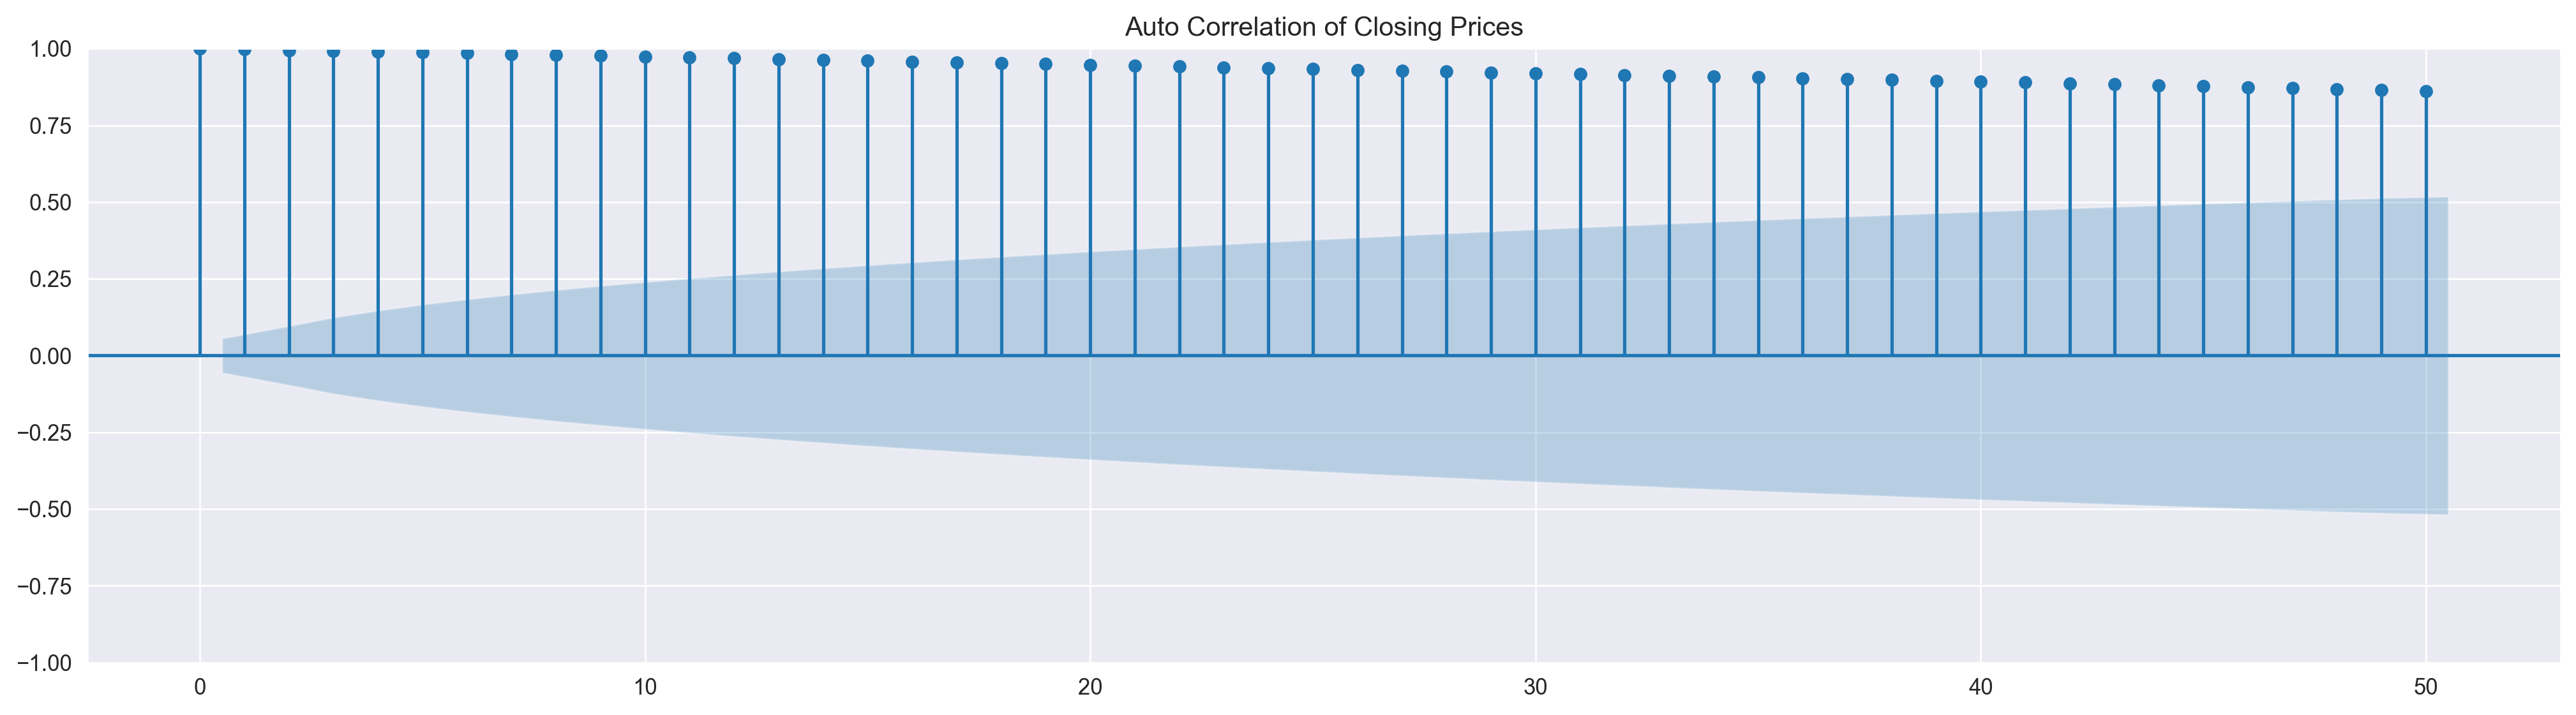

In [17]:
# Auto Correlation
plt.figure(figsize=(8, 4))
plot_acf(historical_data['Close'],lags=50)
plt.title('Auto Correlation of Closing Prices')
plt.show()

<Figure size 2000x1000 with 0 Axes>

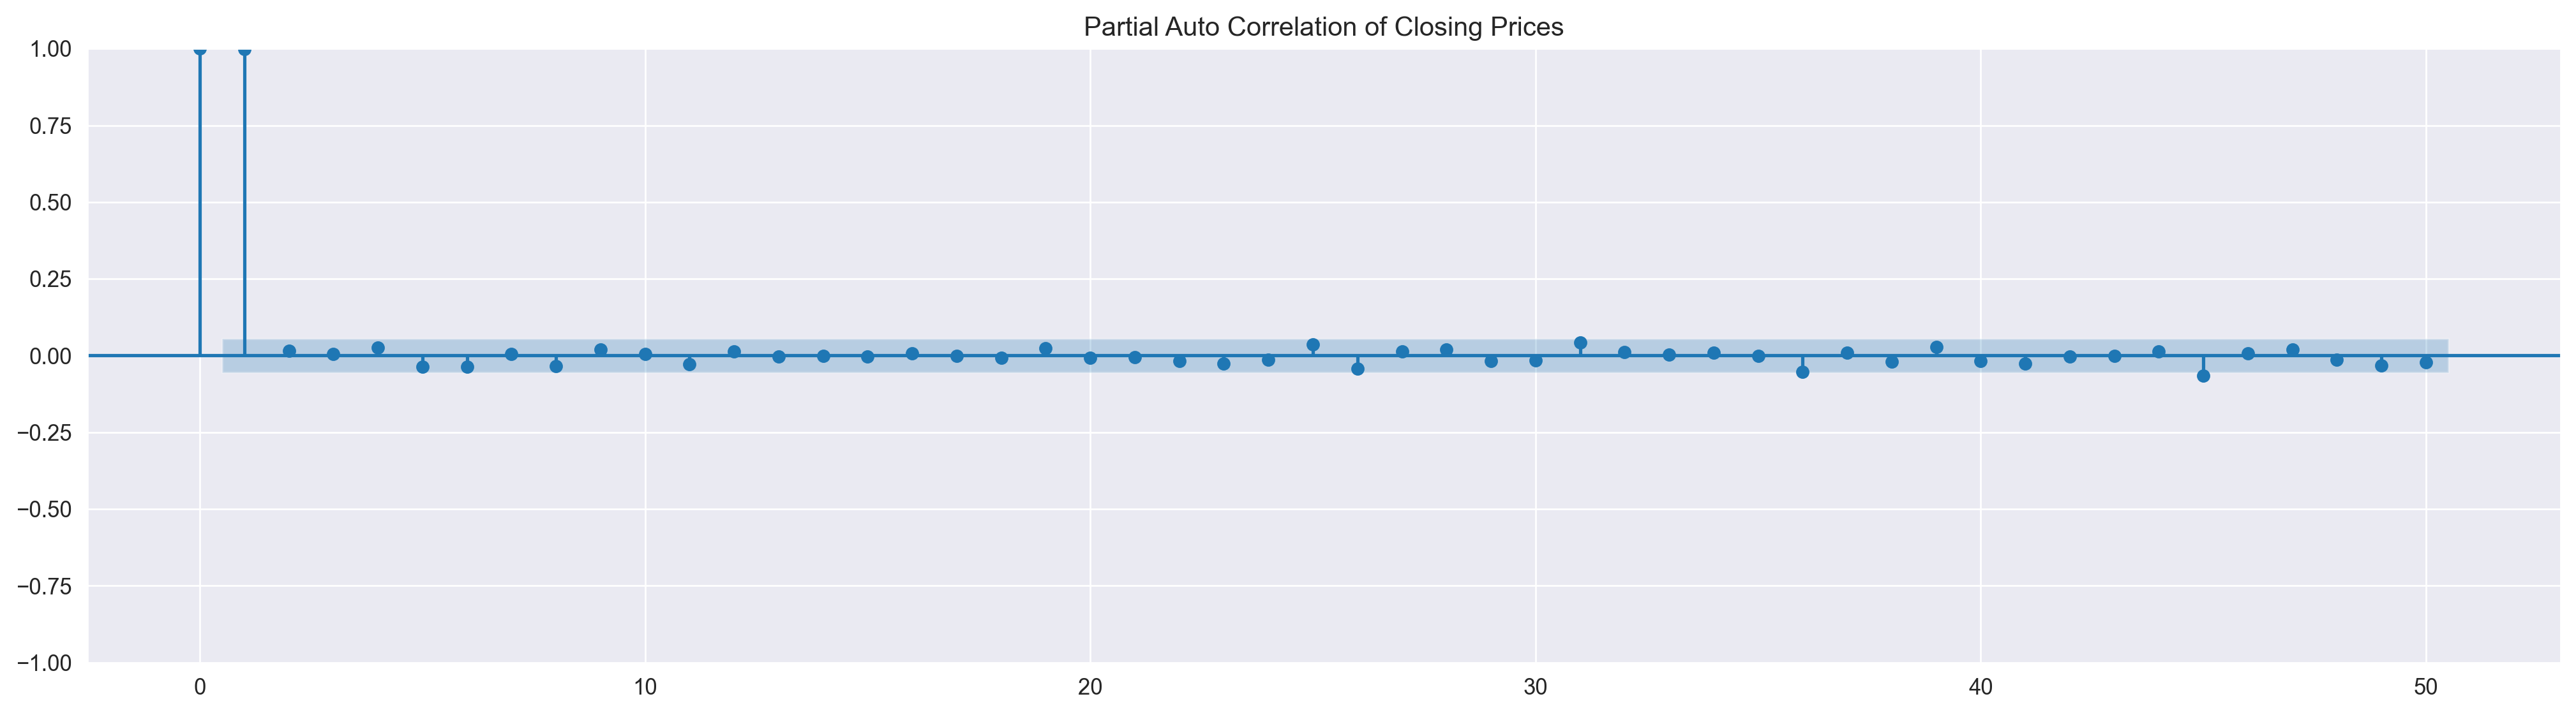

In [18]:
# Partial Auto Correlation
plt.figure(figsize=(8, 4))
plot_pacf(historical_data['Close'],lags=50)
plt.title('Partial Auto Correlation of Closing Prices')
plt.show()

## Feature Engineering

In [19]:
ICICI_data = historical_data.copy()
# Calculate Daily Change (Close - Open)
ICICI_data['Daily Change'] = ICICI_data['Close'] - ICICI_data['Open']

# Calculate Daily Returns
ICICI_data['Daily Returns'] = ICICI_data['Close'].pct_change() * 100

# Add Moving Averages
ICICI_data['7-Day MA'] = ICICI_data['Close'].rolling(window=7).mean()
ICICI_data['30-Day MA'] = ICICI_data['Close'].rolling(window=30).mean()

# Calculate Volatility (Standard Deviation of Returns)
ICICI_data['Volatility'] = ICICI_data['Daily Returns'].rolling(window=30).std()

# Drop NA values generated by moving averages or returns
ICICI_data.dropna(inplace=True)

ICICI_data

Close         High          Low         Open    Volume  \
Date                                                                       
2020-03-02   489.225922   503.194121   481.830989   491.304232  28642076   
2020-03-03   497.587524   502.179153   491.545908   492.850903  19661945   
2020-03-04   491.400909   500.245830   480.477649   500.245830  21883404   
2020-03-05   487.679230   494.107503   483.329266   492.754187  16671516   
2020-03-06   470.134399   480.235964   461.386122   468.829404  31024353   
...                 ...          ...          ...          ...       ...   
2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524   
2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336   
2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698   
2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382   
2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924   

            Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  
Date                                                                           
2020-03-02     -2.078310       1.779783   504.071045   513.982053    1.499756  
2020-03-03      4.736621       1.709150   499.617510   513.334392    1.533472  
2020-03-04     -8.844920      -1.243322   496.648485   512.602956    1.543645  
2020-03-05     -5.074957      -0.757361   492.995893   512.011684    1.525437  
2020-03-06      1.304995      -3.597617   487.838078   510.679307    1.639035  
...                  ...            ...          ...          ...         ...  
2025-01-10     -9.150024      -0.994142  1267.857143  1301.735010    0.923844  
2025-01-13     -5.150024      -1.608191  1259.164289  1299.390011    0.937064  
2025-01-14      6.950073       0.857902  1255.628575  1297.245011    0.951467  
2025-01-15      4.250000      -0.165287  1251.935721  1294.906677    0.947641  
2025-01-16      4.000000       0.876235  1247.628575  1292.675008    0.957192  

[1208 rows x 10 columns]

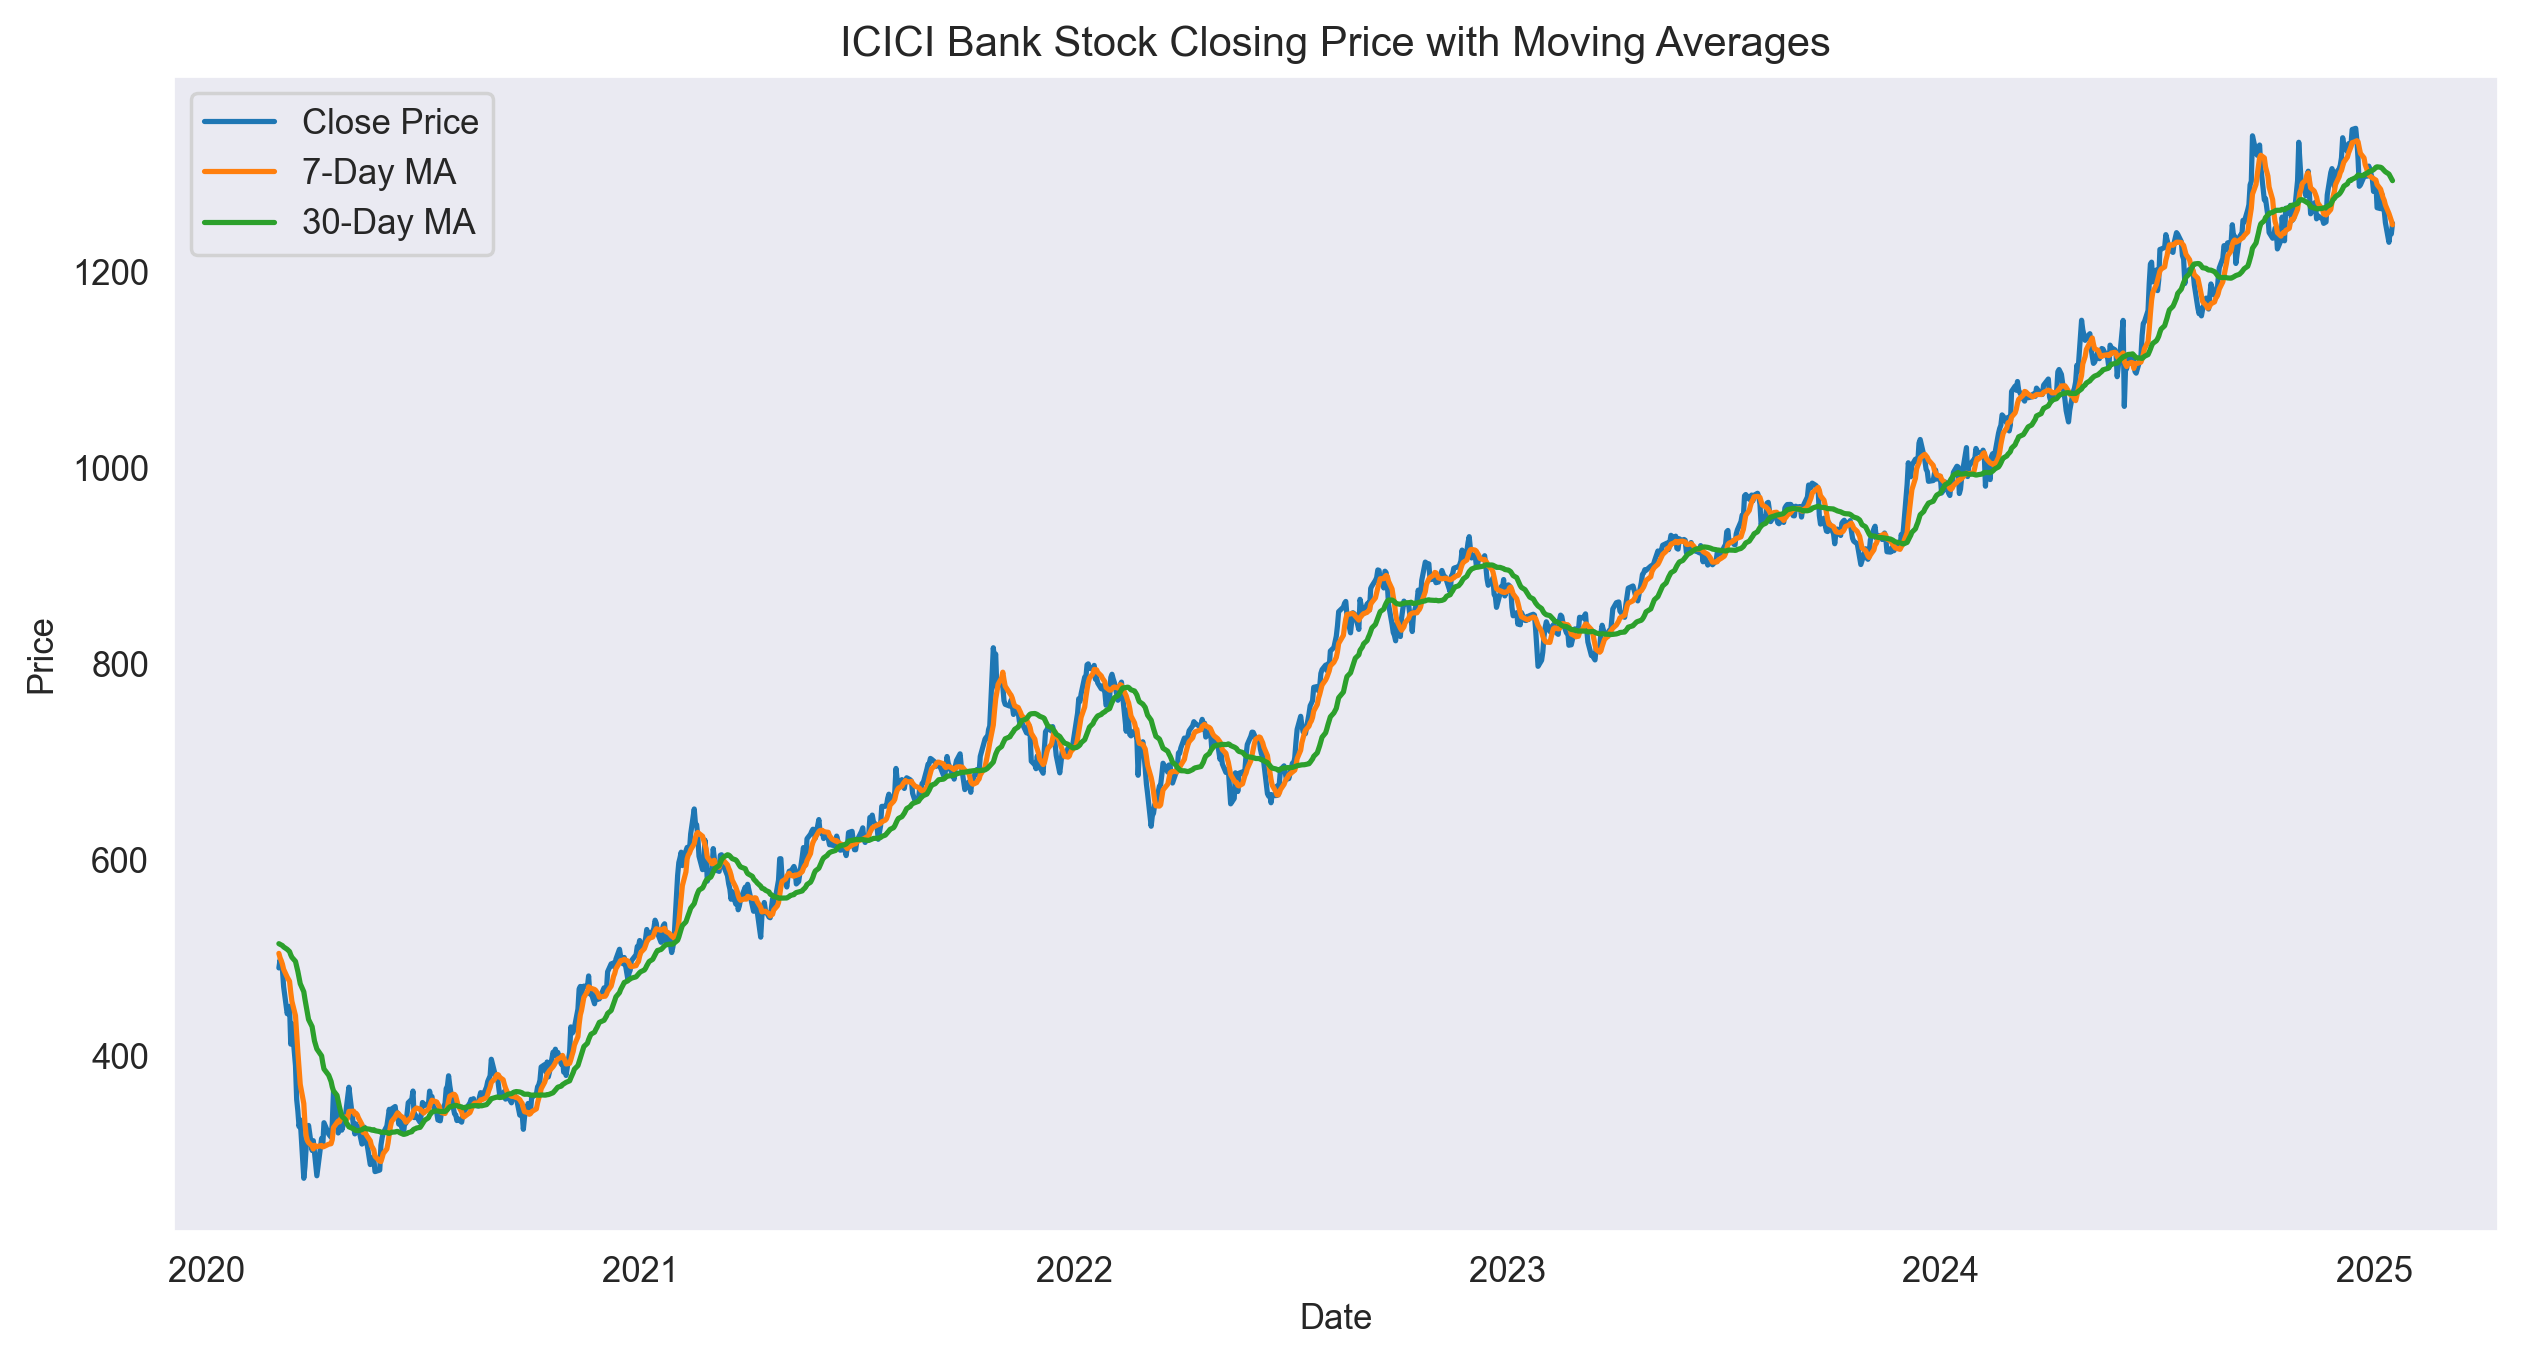

In [20]:
# Plot for Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(ICICI_data.index, ICICI_data['Close'], label='Close Price')
plt.plot(ICICI_data.index, ICICI_data['7-Day MA'], label='7-Day MA')
plt.plot(ICICI_data.index, ICICI_data['30-Day MA'], label='30-Day MA')
plt.title("ICICI Bank Stock Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

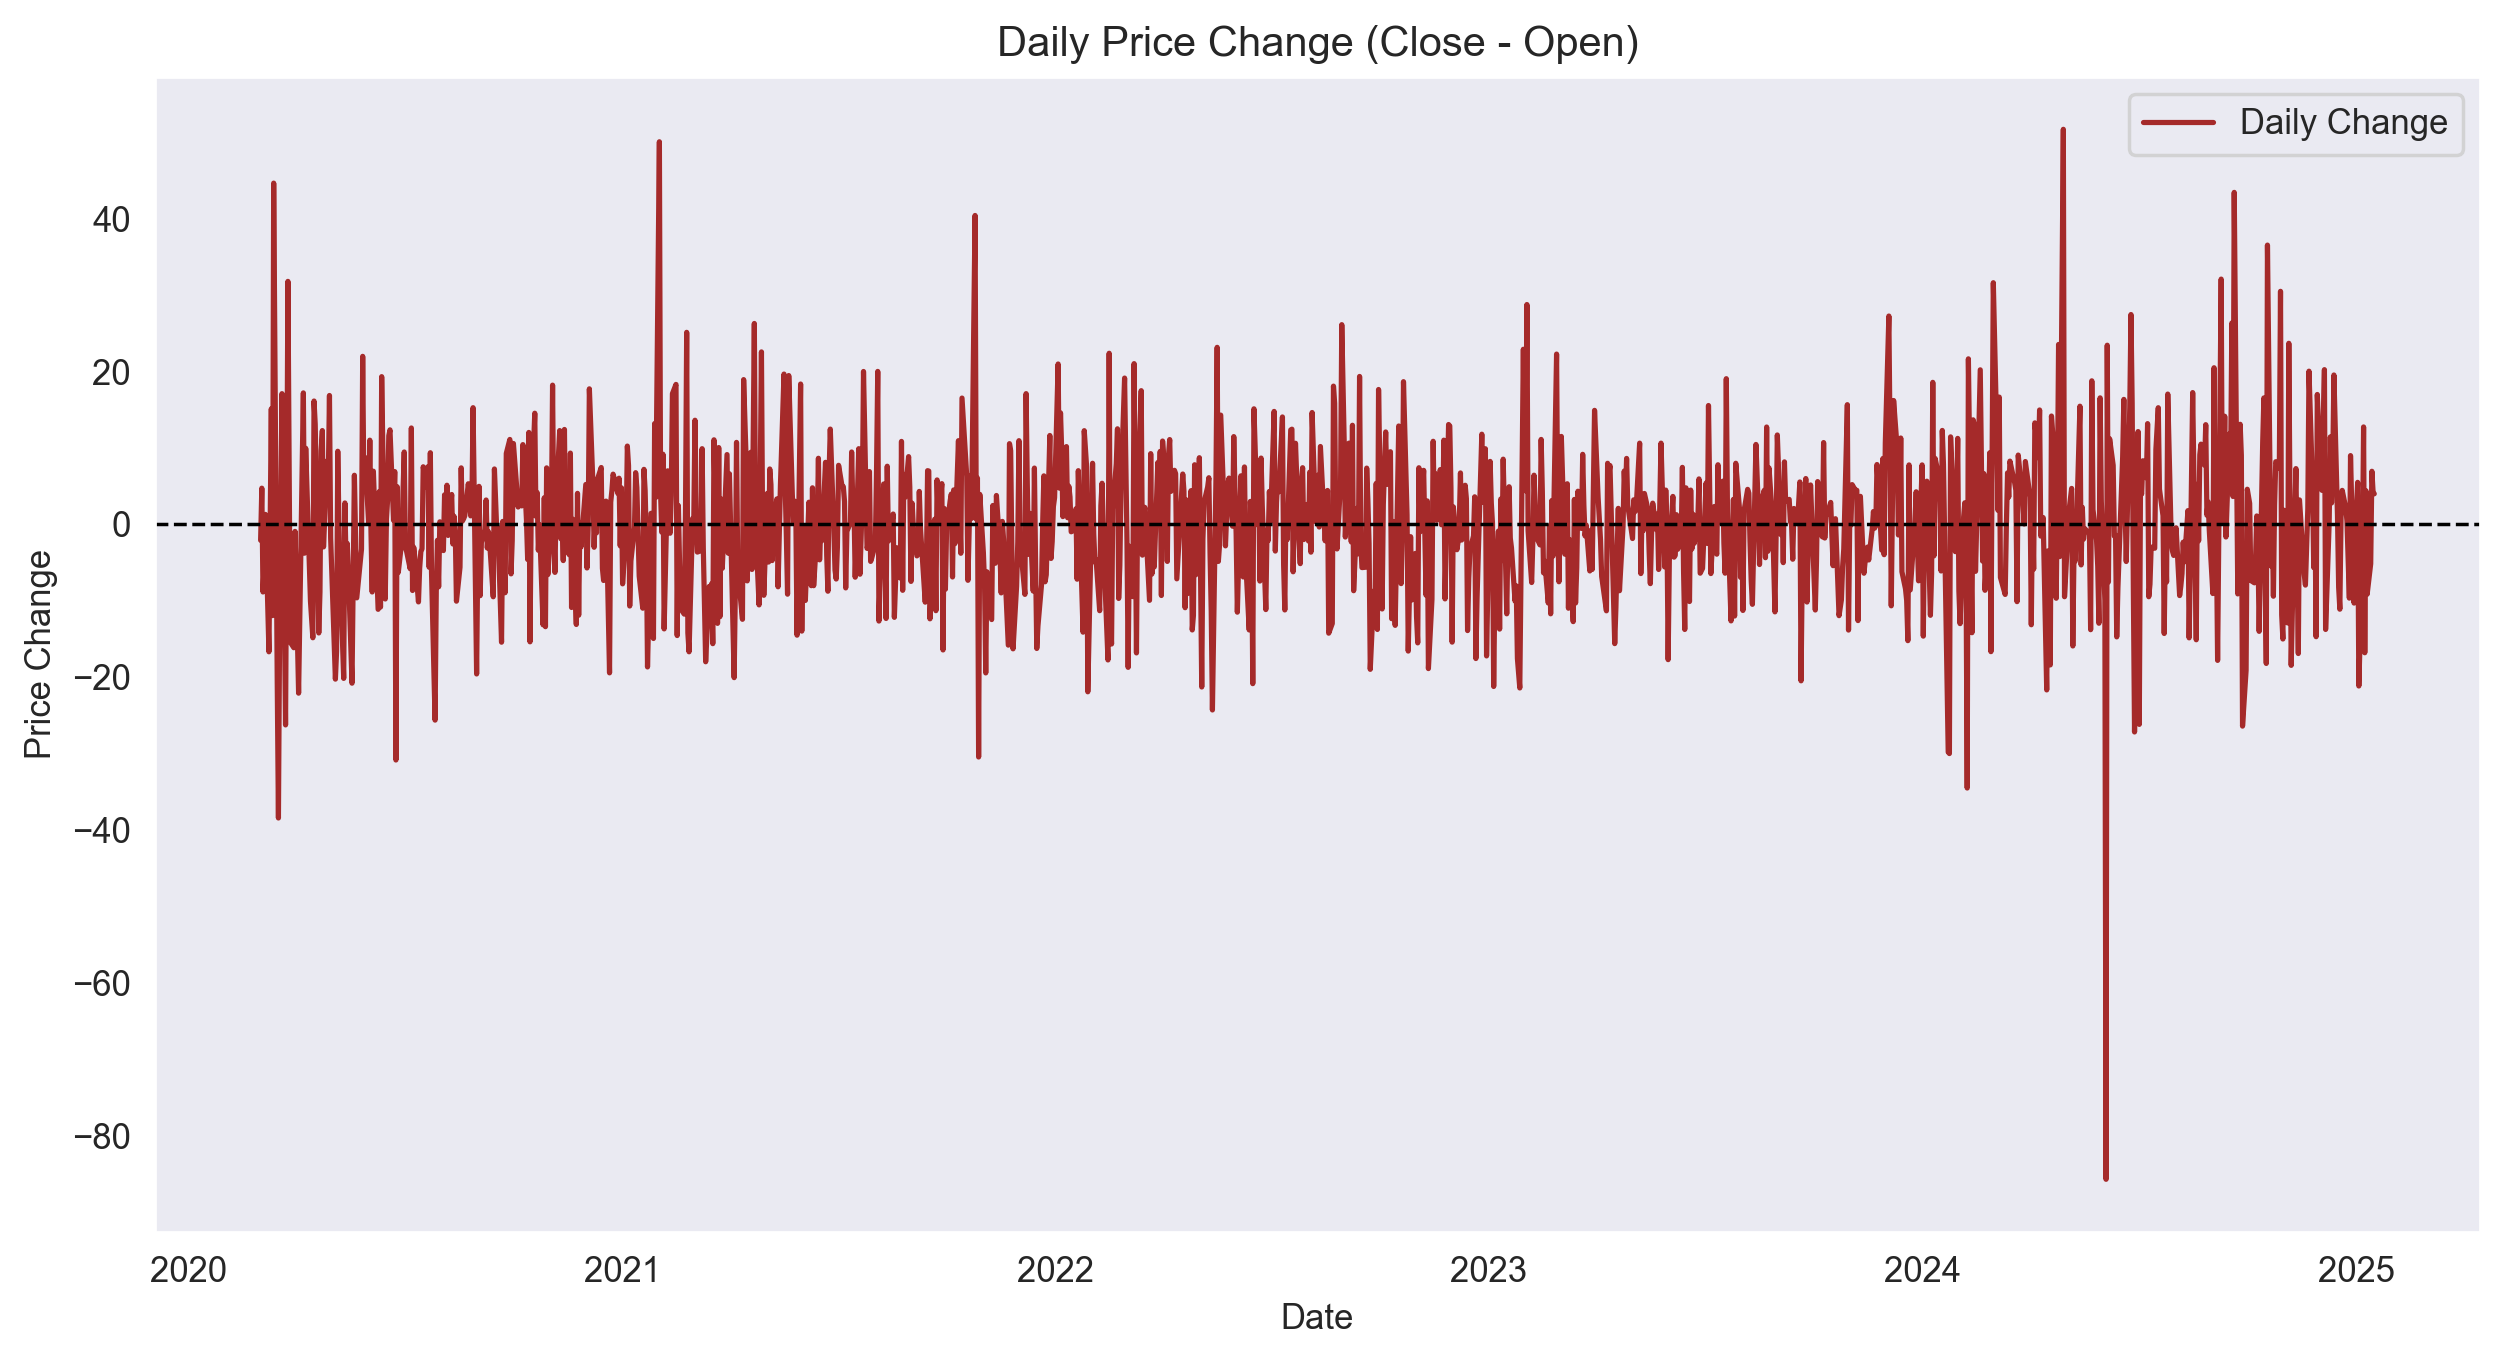

In [21]:
# Daily Price Change (Close - Open)
plt.figure(figsize=(12, 6))
plt.plot(ICICI_data['Daily Change'], label='Daily Change', color='brown')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title("Daily Price Change (Close - Open)")
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.legend()
plt.grid()
plt.show()

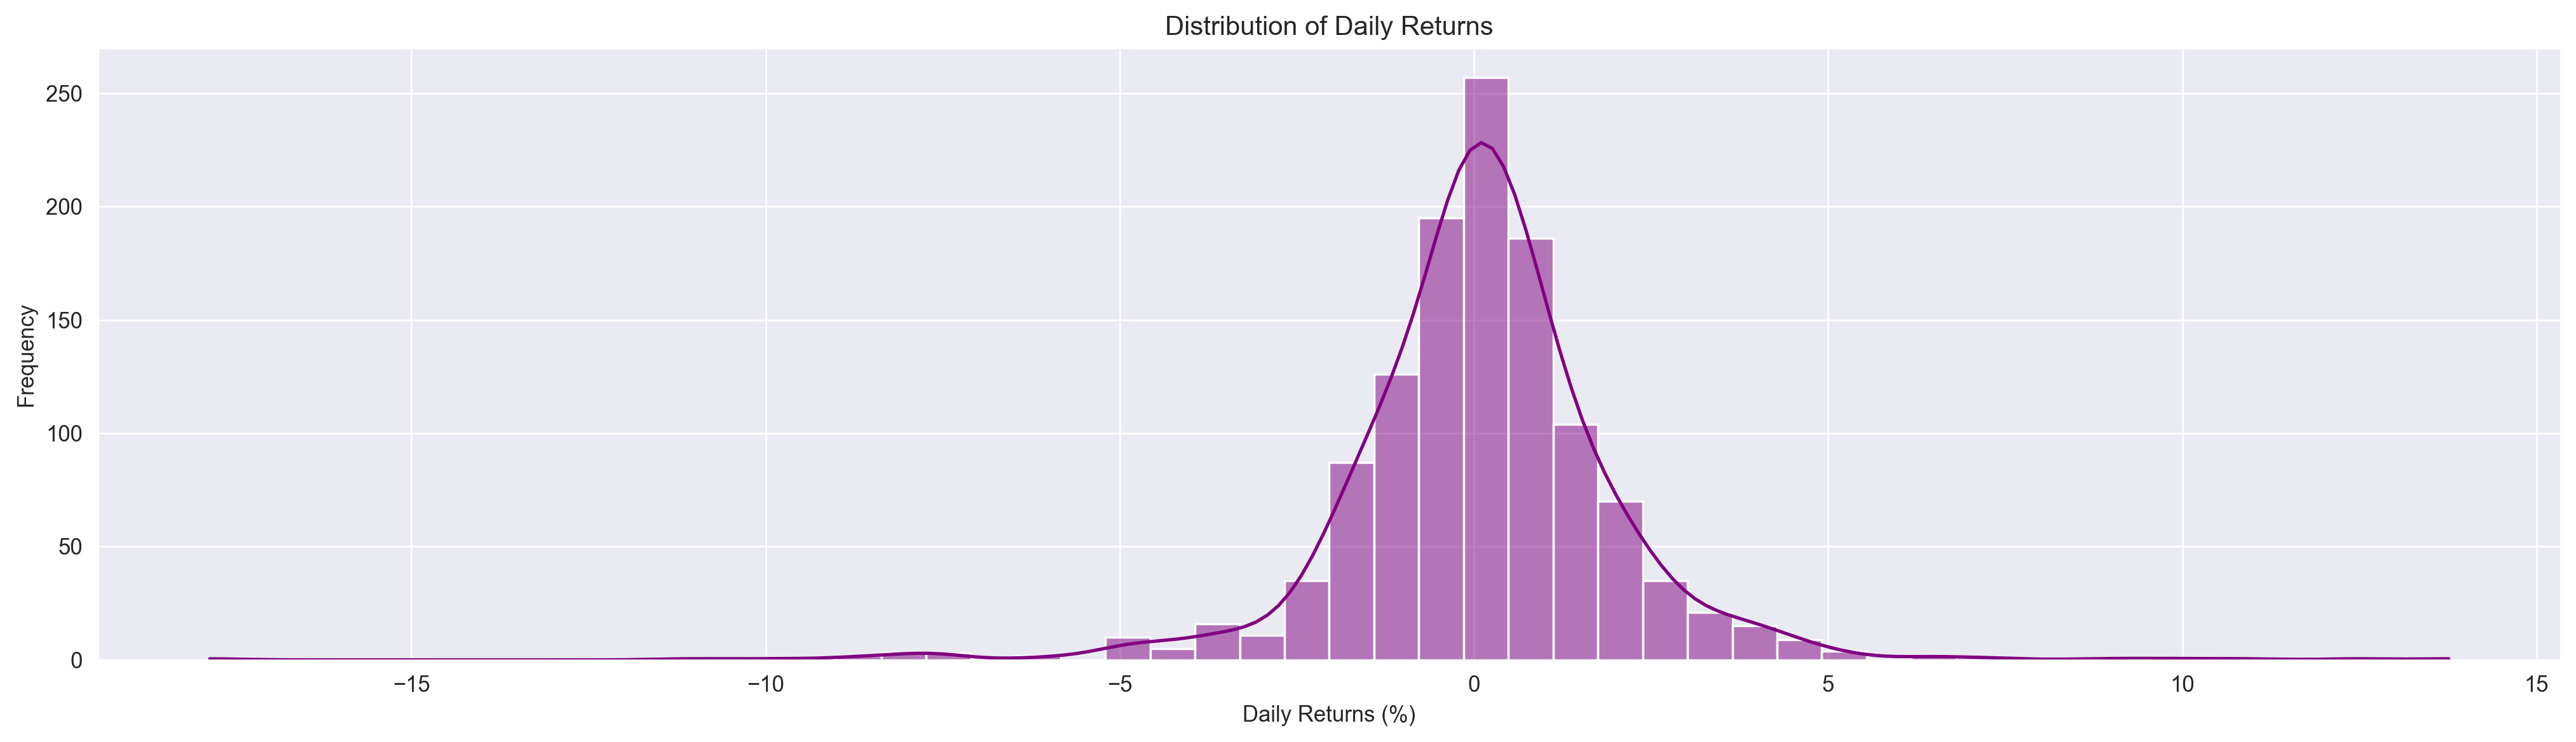

In [22]:
# Daily Returns Distribution
sns.histplot(ICICI_data['Daily Returns'], bins=50, kde=True, color='purple')
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Returns (%)")
plt.ylabel("Frequency")
plt.show()

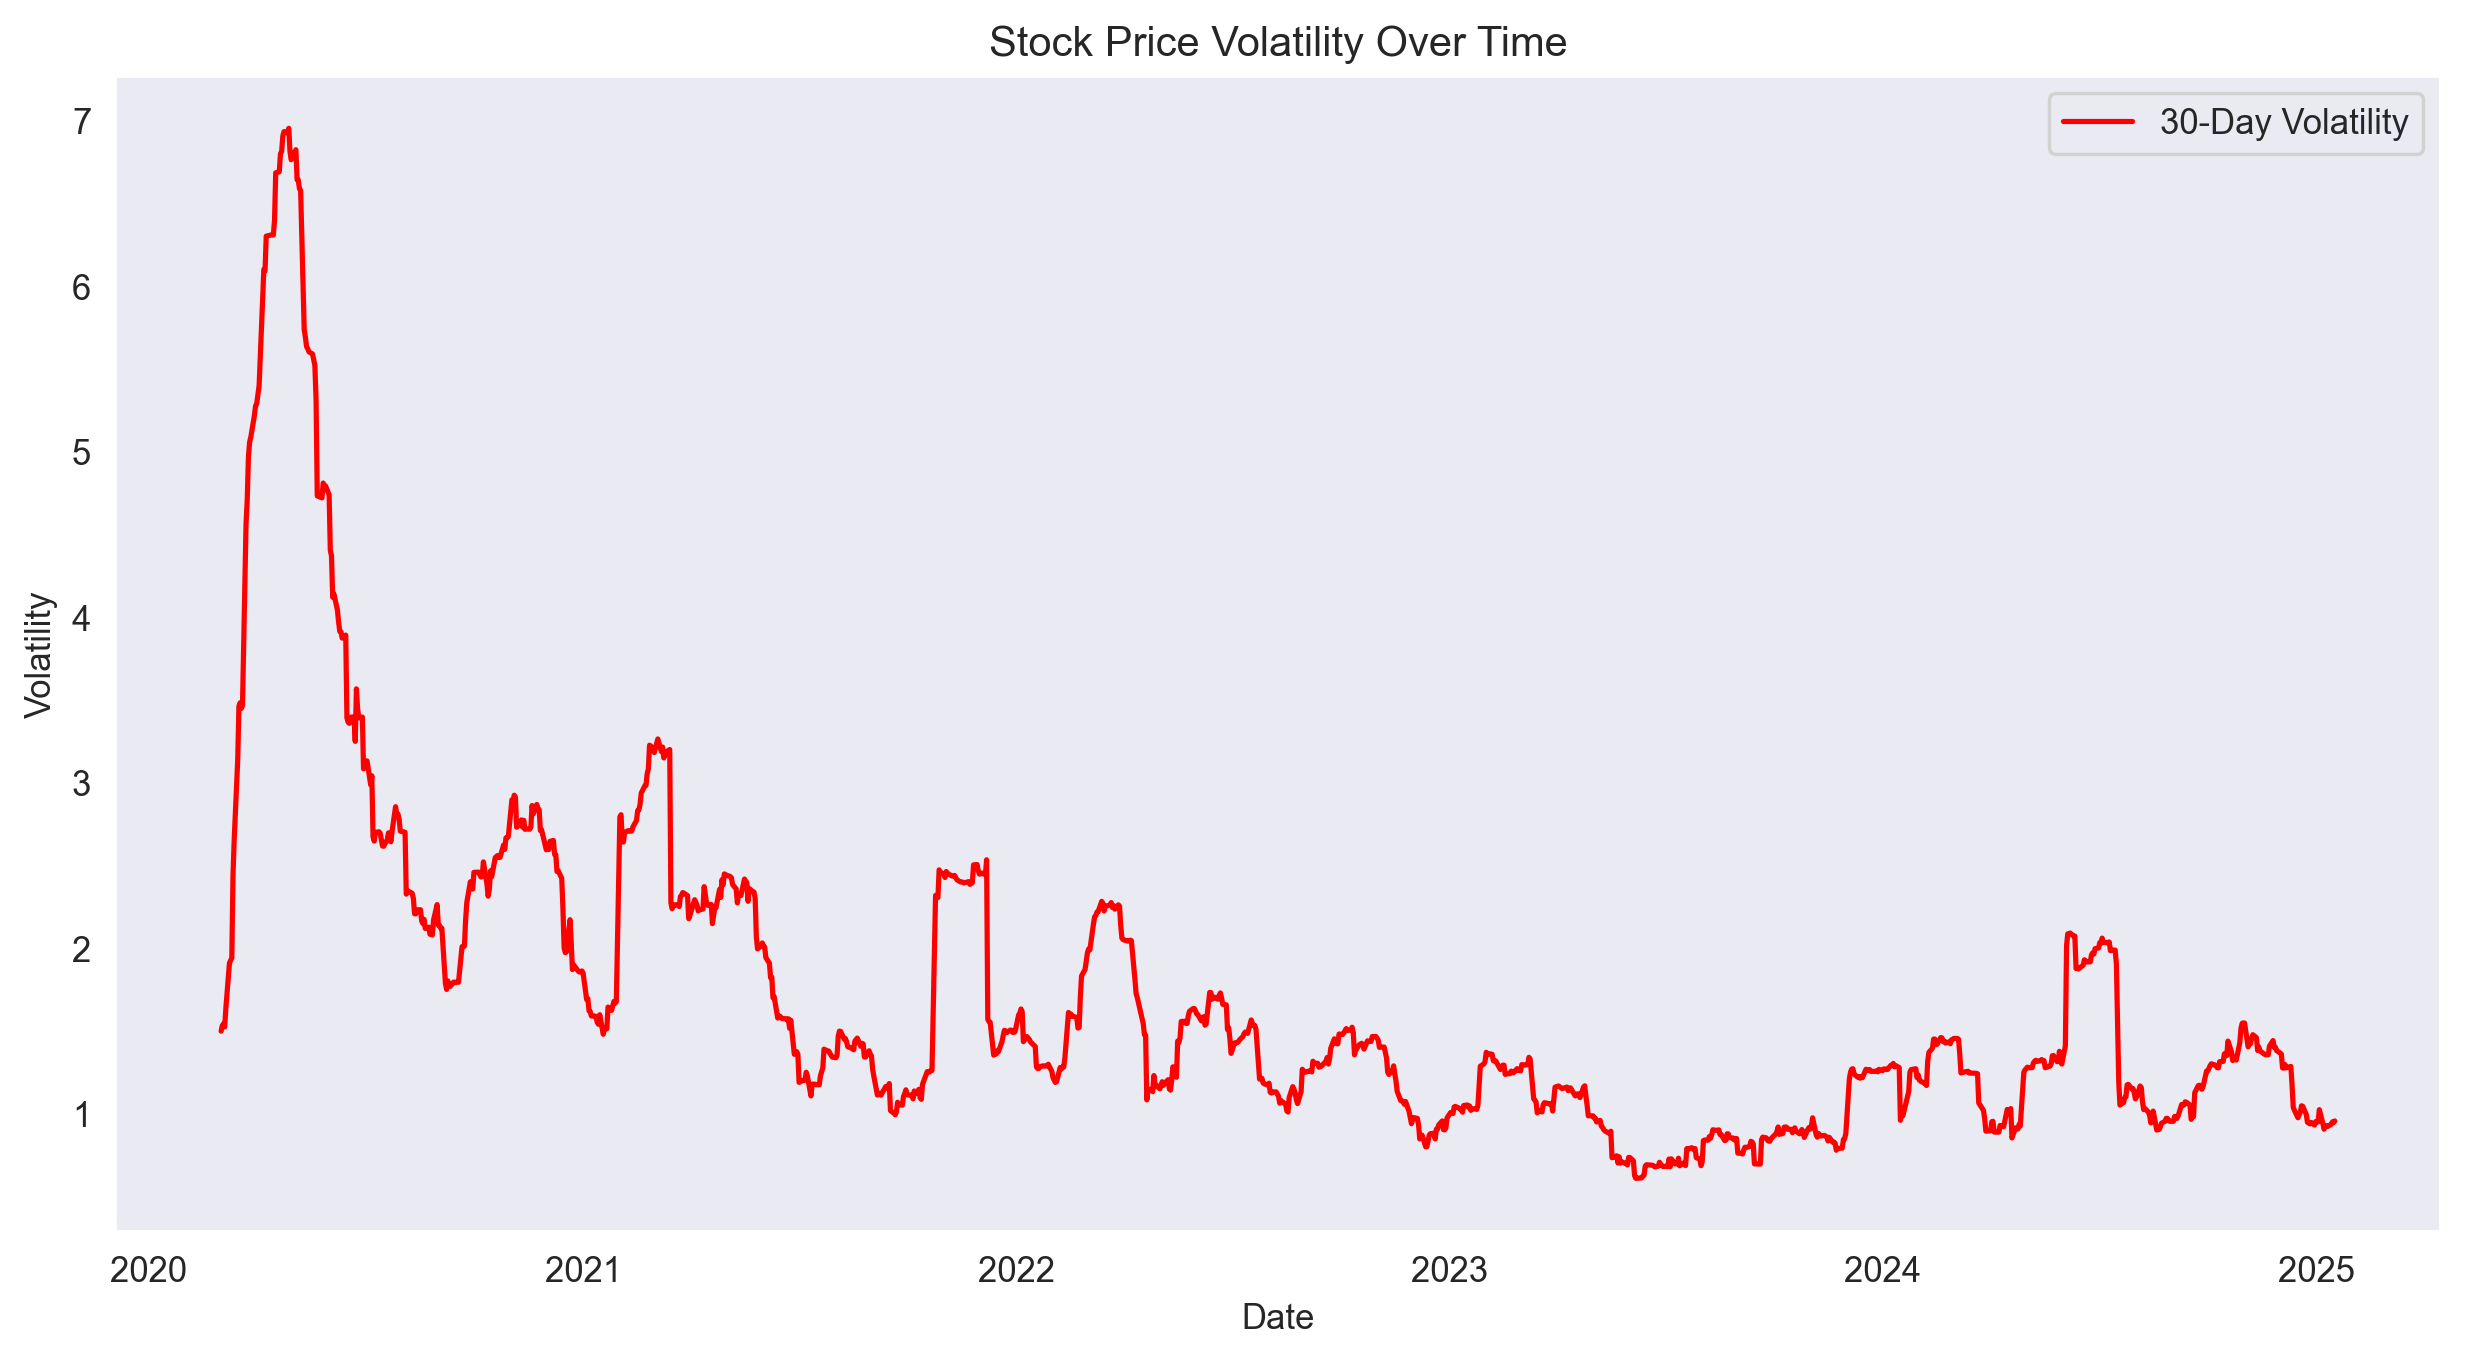

In [23]:
# Volatility over time
plt.figure(figsize=(12, 6))
plt.plot(ICICI_data.index, ICICI_data['Volatility'], label='30-Day Volatility', color='red')
plt.title("Stock Price Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid()
plt.show()

In [24]:
ICICI_data.to_csv('ICICI_data.csv', index=False)

## Model Building

### A) Forecasting Model based methods

In [25]:
# Resetting index for better prediction as the Date index is irregular
model_based_dataset = ICICI_data.copy()
# Feature Engineering: 
model_based_dataset.drop(['High','Low','Open','Volume','Daily Change','Daily Returns','7-Day MA','30-Day MA','Volatility'], axis=1, inplace=True)
# Add time index for regression
model_based_dataset['time'] = np.arange(1, len(model_based_dataset)+1)
# Add log_close index for exponential model
model_based_dataset['log_close'] = np.log(model_based_dataset['Close'])
# Add time_squared index for quadratic model
model_based_dataset['time_squared'] = model_based_dataset['time']**2
# Add month index for seasonality models
model_based_dataset['month'] = model_based_dataset.index.month
model_based_dataset.reset_index(inplace=True)
model_based_dataset

Date        Close  time  log_close  time_squared  month
0    2020-03-02   489.225922     1   6.192824             1      3
1    2020-03-03   497.587524     2   6.209771             4      3
2    2020-03-04   491.400909     3   6.197260             9      3
3    2020-03-05   487.679230     4   6.189658            16      3
4    2020-03-06   470.134399     5   6.153019            25      3
...         ...          ...   ...        ...           ...    ...
1203 2025-01-10  1249.849976  1204   7.130779       1449616      1
1204 2025-01-13  1229.750000  1205   7.114566       1452025      1
1205 2025-01-14  1240.300049  1206   7.123109       1454436      1
1206 2025-01-15  1238.250000  1207   7.121454       1456849      1
1207 2025-01-16  1249.099976  1208   7.130179       1459264      1

[1208 rows x 6 columns]

In [26]:
# Splitting the dataset into training and testing
model_based_dataset_train = model_based_dataset.iloc[:990]
model_based_dataset_test = model_based_dataset.iloc[990:]

In [27]:
# Linear Model
from statsmodels.formula.api import ols
linear_model = ols('Close ~ time', data=model_based_dataset_train).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(model_based_dataset_test['time'])))

mse_linear = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_linear))
rmse_linear = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_linear))
mae_linear = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(pred_linear))
r2_linear = r2_score(np.array(model_based_dataset_test['Close']), np.array(pred_linear))

print("Mean Squared Error for Linear model:", mse_linear)
print("Root Mean Squared Error for Linear model:", rmse_linear)
print("Mean Absolute Error for Linear model:", mae_linear)
print("R-squared for Linear model:", r2_linear)

Mean Squared Error for Linear model: 7128.493140256724
Root Mean Squared Error for Linear model: 84.43040412231085
Mean Absolute Error for Linear model: 70.75454673000505
R-squared for Linear model: 0.009779300653585232


In [28]:
# Exponential Model
exp_model = ols('log_close ~ time', data=model_based_dataset_train).fit()
pred_Exp = pd.Series(exp_model.predict(pd.DataFrame(model_based_dataset_test['time'])))

mse_exp = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Exp)))
rmse_exp = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Exp)))
mae_exp = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Exp)))
r2_exp = r2_score(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Exp)))

print("Mean Squared Error for Exponential model:", mse_exp)
print("Root Mean Squared Error for Exponential model:", rmse_exp)
print("Mean Absolute Error for Exponential model:", mae_exp)
print("R-squared for Exponential model:", r2_exp)

Mean Squared Error for Exponential model: 15880.079774992357
Root Mean Squared Error for Exponential model: 126.01618854334691
Mean Absolute Error for Exponential model: 119.79648028211506
R-squared for Exponential model: -1.2059057070094172


In [29]:
# Quadratic Model
quad_model = ols('Close ~ time + time_squared', data=model_based_dataset_train).fit()
pred_Quad = pd.Series(quad_model.predict(model_based_dataset_test[["time","time_squared"]]))

mse_qua = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_Quad))
rmse_qua = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_Quad))
mae_qua = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(pred_Quad))
r2_qua = r2_score(np.array(model_based_dataset_test['Close']), np.array(pred_Quad))

print("Mean Squared Error for Quadratic model:", mse_qua)
print("Root Mean Squared Error for Quadratic model:", rmse_qua)
print("Mean Absolute Error for Quadratic model:", mae_qua)
print("R-squared for Quadratic model:", r2_qua)

Mean Squared Error for Quadratic model: 41568.59446049118
Root Mean Squared Error for Quadratic model: 203.88377684477786
Mean Absolute Error for Quadratic model: 190.2122996692143
R-squared for Quadratic model: -4.774303470260852


In [30]:
# Additive Seasonality
add_season_model = ols('Close ~ C(month)', data=model_based_dataset_train).fit()
pred_add_sea = pd.Series(add_season_model.predict(model_based_dataset_test['month']))

mse_add_sea = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea))
rmse_add_sea = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea))
mae_add_sea = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea))
r2_add_sea = r2_score(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea))

print("Mean Squared Error for Additive Seasonality model:", mse_add_sea)
print("Root Mean Squared Error for Additive Seasonality model:", rmse_add_sea)
print("Mean Absolute Error for Additive Seasonality model:", mae_add_sea)
print("R-squared for Additive Seasonality model:", r2_add_sea)

Mean Squared Error for Additive Seasonality model: 258777.74055846297
Root Mean Squared Error for Additive Seasonality model: 508.70201548496243
Mean Absolute Error for Additive Seasonality model: 506.1453923747139
R-squared for Additive Seasonality model: -34.94687827978437


In [31]:
# Additive Seasonality with Quadratic Trend
add_season_quad_model = ols('Close ~ time + time_squared + C(month)', data=model_based_dataset_train).fit()
pred_add_sea_quad = pd.Series(add_season_quad_model.predict(model_based_dataset_test[['time', 'time_squared', 'month']]))

mse_add_sea_quad = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea_quad))
rmse_add_sea_quad = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea_quad))
mae_add_sea_quad = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea_quad))
r2_add_sea_quad = r2_score(np.array(model_based_dataset_test['Close']), np.array(pred_add_sea_quad))

print("Mean Squared Error for Additive Seasonality with Quadratic model:", mse_add_sea_quad)
print("Root Mean Squared Error for Additive Seasonality with Quadratic model:", rmse_add_sea_quad)
print("Mean Absolute Error for Additive Seasonality with Quadratic model:", mae_add_sea_quad)
print("R-squared for Additive Seasonality with Quadratic model:", r2_add_sea_quad)

Mean Squared Error for Additive Seasonality with Quadratic model: 44398.11757673971
Root Mean Squared Error for Additive Seasonality with Quadratic model: 210.70860821698696
Mean Absolute Error for Additive Seasonality with Quadratic model: 200.21876509575304
R-squared for Additive Seasonality with Quadratic model: -5.16735320796286


In [32]:
# Multiplicative Seasonality
multi_season_model = ols('log_close ~ C(month)', data=model_based_dataset_train).fit()
pred_Mult_sea = pd.Series(multi_season_model.predict(model_based_dataset_test['month']))

mse_mult_sea = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_sea)))
rmse_mult_sea = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_sea)))
mae_mult_sea = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_sea)))
r2_mult_sea = r2_score(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_sea)))

print("Mean Squared Error for Additive Seasonality with Quadratic model:", mse_mult_sea)
print("Root Mean Squared Error for Additive Seasonality with Quadratic model:", rmse_mult_sea)
print("Mean Absolute Error for Additive Seasonality with Quadratic model:", mae_mult_sea)
print("R-squared for Additive Seasonality with Quadratic model:", r2_mult_sea)

Mean Squared Error for Additive Seasonality with Quadratic model: 296749.8009513697
Root Mean Squared Error for Additive Seasonality with Quadratic model: 544.7474653005461
Mean Absolute Error for Additive Seasonality with Quadratic model: 542.0888487974714
R-squared for Additive Seasonality with Quadratic model: -40.221586336322424


In [33]:
# Multiplicative Additive Seasonality
multi_add_season_model = ols('log_close ~ time + C(month)', data=model_based_dataset_train).fit()
pred_Mult_add_sea = pd.Series(multi_add_season_model.predict(model_based_dataset_test[['time', 'month']]))

mse_add_mult_sea = mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_add_sea)))
rmse_add_mult_sea = root_mean_squared_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_add_sea)))
mae_add_mult_sea = mean_absolute_error(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_add_sea)))
r2_add_mult_sea = r2_score(np.array(model_based_dataset_test['Close']), np.array(np.exp(pred_Mult_add_sea)))

print("Mean Squared Error for Additive Seasonality with Quadratic model:", mse_add_mult_sea)
print("Root Mean Squared Error for Additive Seasonality with Quadratic model:", rmse_add_mult_sea)
print("Mean Absolute Error for Additive Seasonality with Quadratic model:", mae_add_mult_sea)
print("R-squared for Additive Seasonality with Quadratic model:", r2_add_mult_sea)

Mean Squared Error for Additive Seasonality with Quadratic model: 13659.851840613499
Root Mean Squared Error for Additive Seasonality with Quadratic model: 116.8753688362672
Mean Absolute Error for Additive Seasonality with Quadratic model: 100.06240295785634
R-squared for Additive Seasonality with Quadratic model: -0.8974933097983706


## B) Forecasting by Data Driven Methods

#### a) Triple Exponential Smoothing with additive trend and additive seasonality
As the data is having a additive trend and additive seasonality we build a model for triple exponential smoothing

We do not need stationary data for exponential smoothing as it uses the moving averages

In [34]:
ICICI_data

Close         High          Low         Open    Volume  \
Date                                                                       
2020-03-02   489.225922   503.194121   481.830989   491.304232  28642076   
2020-03-03   497.587524   502.179153   491.545908   492.850903  19661945   
2020-03-04   491.400909   500.245830   480.477649   500.245830  21883404   
2020-03-05   487.679230   494.107503   483.329266   492.754187  16671516   
2020-03-06   470.134399   480.235964   461.386122   468.829404  31024353   
...                 ...          ...          ...          ...       ...   
2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524   
2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336   
2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698   
2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382   
2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924   

            Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  
Date                                                                           
2020-03-02     -2.078310       1.779783   504.071045   513.982053    1.499756  
2020-03-03      4.736621       1.709150   499.617510   513.334392    1.533472  
2020-03-04     -8.844920      -1.243322   496.648485   512.602956    1.543645  
2020-03-05     -5.074957      -0.757361   492.995893   512.011684    1.525437  
2020-03-06      1.304995      -3.597617   487.838078   510.679307    1.639035  
...                  ...            ...          ...          ...         ...  
2025-01-10     -9.150024      -0.994142  1267.857143  1301.735010    0.923844  
2025-01-13     -5.150024      -1.608191  1259.164289  1299.390011    0.937064  
2025-01-14      6.950073       0.857902  1255.628575  1297.245011    0.951467  
2025-01-15      4.250000      -0.165287  1251.935721  1294.906677    0.947641  
2025-01-16      4.000000       0.876235  1247.628575  1292.675008    0.957192  

[1208 rows x 10 columns]

In [35]:
# Lets divide the dataset into training and testing dataset
ICICI_dataset = ICICI_data.reset_index()
ICICI_new_index_training = ICICI_dataset.iloc[:990]
ICICI_new_index_testing = ICICI_dataset.iloc[990:]

In [36]:
ICICI_new_index_training

Date        Close         High          Low         Open    Volume  \
0   2020-03-02   489.225922   503.194121   481.830989   491.304232  28642076   
1   2020-03-03   497.587524   502.179153   491.545908   492.850903  19661945   
2   2020-03-04   491.400909   500.245830   480.477649   500.245830  21883404   
3   2020-03-05   487.679230   494.107503   483.329266   492.754187  16671516   
4   2020-03-06   470.134399   480.235964   461.386122   468.829404  31024353   
..         ...          ...          ...          ...          ...       ...   
985 2024-02-21  1042.971191  1054.918389  1039.054954  1047.779892  15946325   
986 2024-02-22  1053.629517  1056.901399  1031.420804  1046.986751  13432573   
987 2024-02-23  1052.241455  1060.867149  1048.622585  1060.867149  13142759   
988 2024-02-26  1045.202026  1053.232987  1041.533655  1044.111439   7875941   
989 2024-02-27  1051.150757  1057.099545  1037.567740  1041.781464  10580973   

     Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  
0       -2.078310       1.779783   504.071045   513.982053    1.499756  
1        4.736621       1.709150   499.617510   513.334392    1.533472  
2       -8.844920      -1.243322   496.648485   512.602956    1.543645  
3       -5.074957      -0.757361   492.995893   512.011684    1.525437  
4        1.304995      -3.597617   487.838078   510.679307    1.639035  
..            ...            ...          ...          ...         ...  
985     -4.808700       0.305117  1023.595215  1004.599939    1.436366  
986      6.642765       1.021919  1029.671483  1007.341339    1.440442  
987     -8.625694      -0.131741  1035.138698  1009.596922    1.427682  
988      1.090587      -0.668994  1040.457188  1011.680648    1.435206  
989      9.369292       0.569146  1045.690691  1013.554513    1.423726  

[990 rows x 11 columns]

In [37]:
ICICI_new_index_testing

Date        Close         High          Low         Open    Volume  \
990  2024-02-28  1037.270264  1055.761104  1033.254904  1053.926918   7730332   
991  2024-02-29  1043.219116  1051.646566  1029.636098  1034.147311  20944844   
992  2024-03-01  1077.622925  1080.646819  1045.003714  1045.995179  14909562   
993  2024-03-04  1083.026367  1085.653773  1070.880925  1071.773268  11424581   
994  2024-03-05  1078.763184  1090.115406  1067.311718  1076.928877   9222544   
...         ...          ...          ...          ...          ...       ...   
1203 2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524   
1204 2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336   
1205 2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698   
1206 2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382   
1207 2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924   

      Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  
990     -16.656654      -1.320505  1046.037685  1014.755835    1.447397  
991       9.071805       0.573510  1046.526332  1016.181891    1.449078  
992      31.627746       3.297851  1051.476580  1019.656974    1.455670  
993      11.253099       0.501422  1055.676130  1023.160148    1.455775  
994       1.834306      -0.393636  1059.464948  1026.096537    1.450470  
...            ...            ...          ...          ...         ...  
1203     -9.150024      -0.994142  1267.857143  1301.735010    0.923844  
1204     -5.150024      -1.608191  1259.164289  1299.390011    0.937064  
1205      6.950073       0.857902  1255.628575  1297.245011    0.951467  
1206      4.250000      -0.165287  1251.935721  1294.906677    0.947641  
1207      4.000000       0.876235  1247.628575  1292.675008    0.957192  

[218 rows x 11 columns]

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import math
# Holts with add seasonality
hwe_model_add_add = ExponentialSmoothing(ICICI_new_index_training['Close'],seasonal="add",trend="add",seasonal_periods=12).fit()
hwe_model_ypred = hwe_model_add_add.predict(start=ICICI_new_index_testing.index[0], end=ICICI_new_index_testing.index[-1])
print('Root Mean Squared Error: ', math.sqrt(mean_squared_error(ICICI_new_index_testing['Close'], hwe_model_ypred)))

Root Mean Squared Error:  89.63784968752591


In [39]:
mae_exp = mean_absolute_error(ICICI_new_index_testing['Close'], hwe_model_ypred)
mse_exp = mean_squared_error(ICICI_new_index_testing['Close'], hwe_model_ypred)
rmse_exp = root_mean_squared_error(ICICI_new_index_testing['Close'], hwe_model_ypred)
r2_exp = r2_score(ICICI_new_index_testing['Close'], hwe_model_ypred)

# Print the evaluation results
print("Mean Squared Error:", mse_exp)
print("Root Mean Squared Error:",rmse_exp)
print("Mean Absolute Error:", mae_exp)
print("R-squared:", r2_exp)

Mean Squared Error: 8034.944096603491
Root Mean Squared Error: 89.63784968752591
Mean Absolute Error: 75.55395959716407
R-squared: -0.11613602005395451


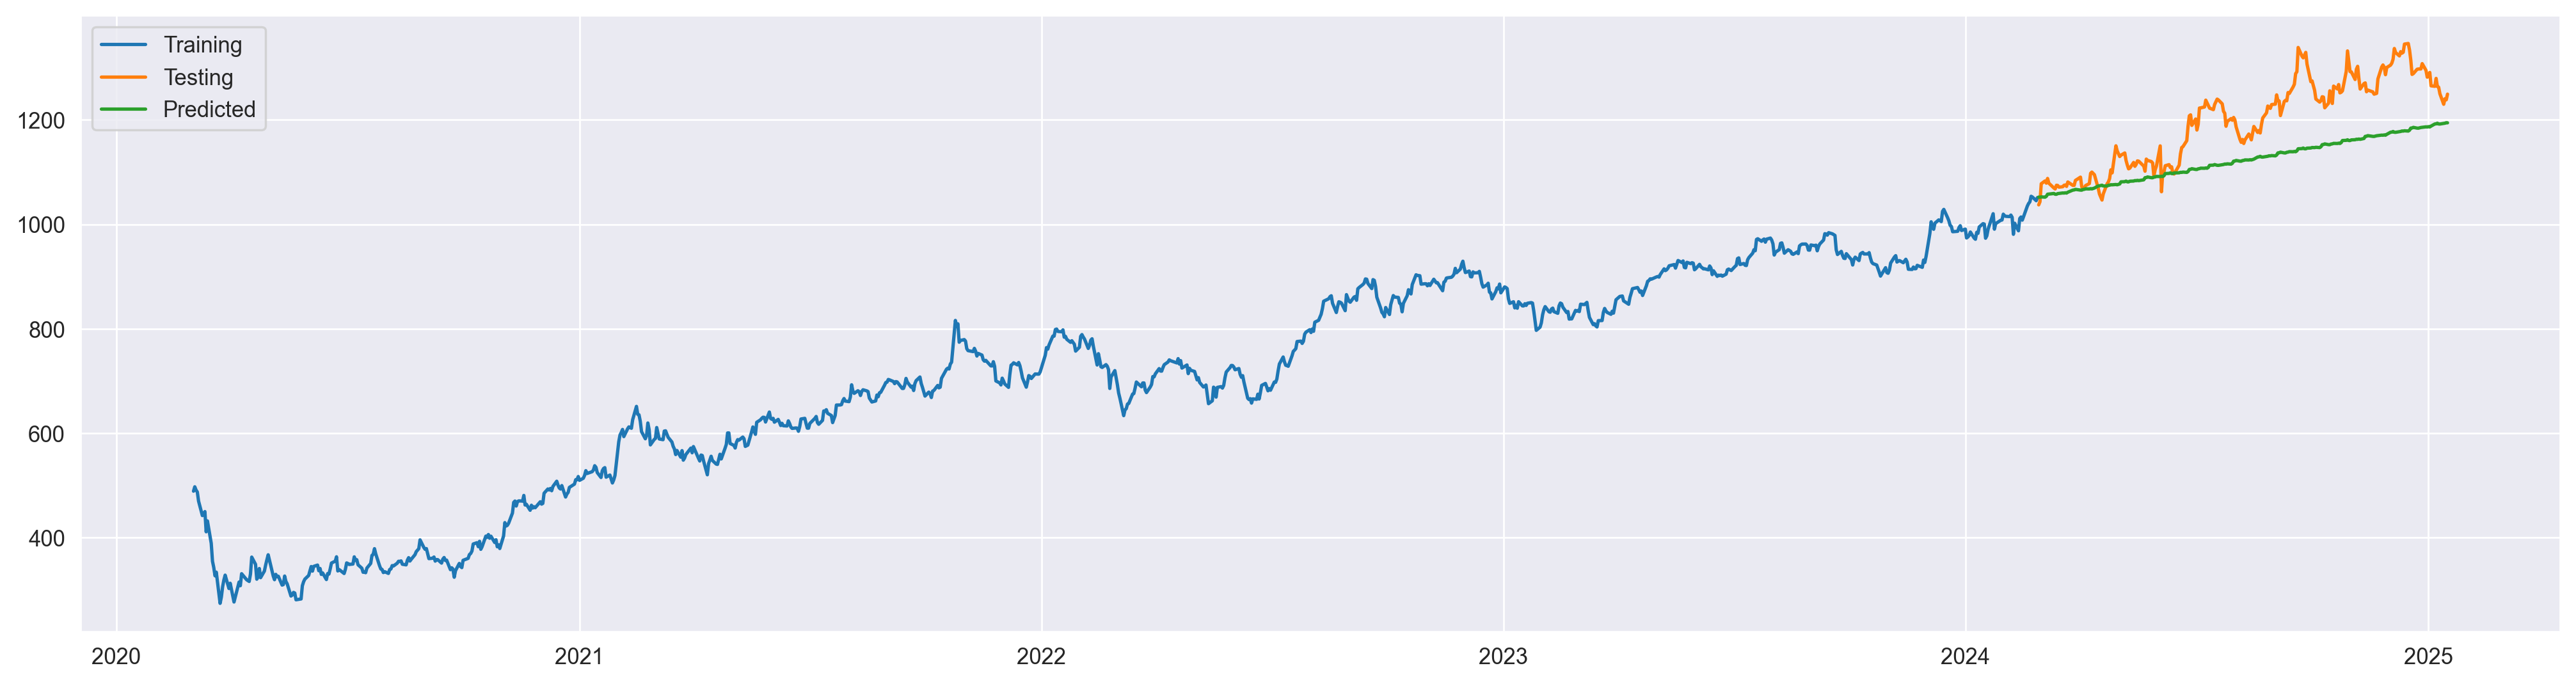

In [40]:
plt.plot(ICICI_new_index_training['Date'],ICICI_new_index_training['Close'], label='Training')
plt.plot(ICICI_new_index_testing['Date'],ICICI_new_index_testing['Close'], label='Testing')
plt.plot(ICICI_new_index_testing['Date'], hwe_model_ypred, label='Predicted')
plt.legend()
plt.show()

#### b) ARIMA model

In [41]:
# adfuller checks if data is stationary or non-stationary (Augmented Dickey-Fuller (ADF) test)

print('For Closing Value: ')
print('ADF Test Statistics: ',adfuller(ICICI_dataset['Close'])[0])
print('p-value: ',adfuller(ICICI_dataset['Close'])[1])
print('Lags used: ',adfuller(ICICI_dataset['Close'])[2])
print('Number of observations used: ',adfuller(ICICI_dataset['Close'])[3])

# Data is not stationary

For Closing Value: 
ADF Test Statistics:  -0.25474482529504977
p-value:  0.931673759058076
Lags used:  4
Number of observations used:  1203


**Null Hypothesis: Data is Non-stationary**

**Alternative Hypothesis: Data is Stationary**
* If p < 0.05; Data is stationary
* If p > 0.05; Data is non-stationary

**According to the p-value, the dataset is non-stationary as the p-value is more than alpha value**

In [42]:
ICICI_dataset['close_diff'] = ICICI_dataset['Close'].diff()
ICICI_dataset.dropna(ignore_index=True, inplace=True)
ICICI_dataset

Date        Close         High          Low         Open    Volume  \
0    2020-03-03   497.587524   502.179153   491.545908   492.850903  19661945   
1    2020-03-04   491.400909   500.245830   480.477649   500.245830  21883404   
2    2020-03-05   487.679230   494.107503   483.329266   492.754187  16671516   
3    2020-03-06   470.134399   480.235964   461.386122   468.829404  31024353   
4    2020-03-09   442.488007   459.162869   428.181470   459.162869  42027175   
...         ...          ...          ...          ...          ...       ...   
1202 2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524   
1203 2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336   
1204 2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698   
1205 2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382   
1206 2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924   

      Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  \
0         4.736621       1.709150   499.617510   513.334392    1.533472   
1        -8.844920      -1.243322   496.648485   512.602956    1.543645   
2        -5.074957      -0.757361   492.995893   512.011684    1.525437   
3         1.304995      -3.597617   487.838078   510.679307    1.639035   
4       -16.674862      -5.880530   479.883859   508.227217    1.910320   
...            ...            ...          ...          ...         ...   
1202     -9.150024      -0.994142  1267.857143  1301.735010    0.923844   
1203     -5.150024      -1.608191  1259.164289  1299.390011    0.937064   
1204      6.950073       0.857902  1255.628575  1297.245011    0.951467   
1205      4.250000      -0.165287  1251.935721  1294.906677    0.947641   
1206      4.000000       0.876235  1247.628575  1292.675008    0.957192   

      close_diff  
0       8.361603  
1      -6.186615  
2      -3.721680  
3     -17.544830  
4     -27.646393  
...          ...  
1202  -12.550049  
1203  -20.099976  
1204   10.550049  
1205   -2.050049  
1206   10.849976  

[1207 rows x 12 columns]

In [43]:
print('p-value: ',adfuller(ICICI_dataset['close_diff'])[1])

p-value:  3.814023169969377e-30


**According to the p-value, the dataset is now stationary as the p-value is less than alpha value**

<Axes: >

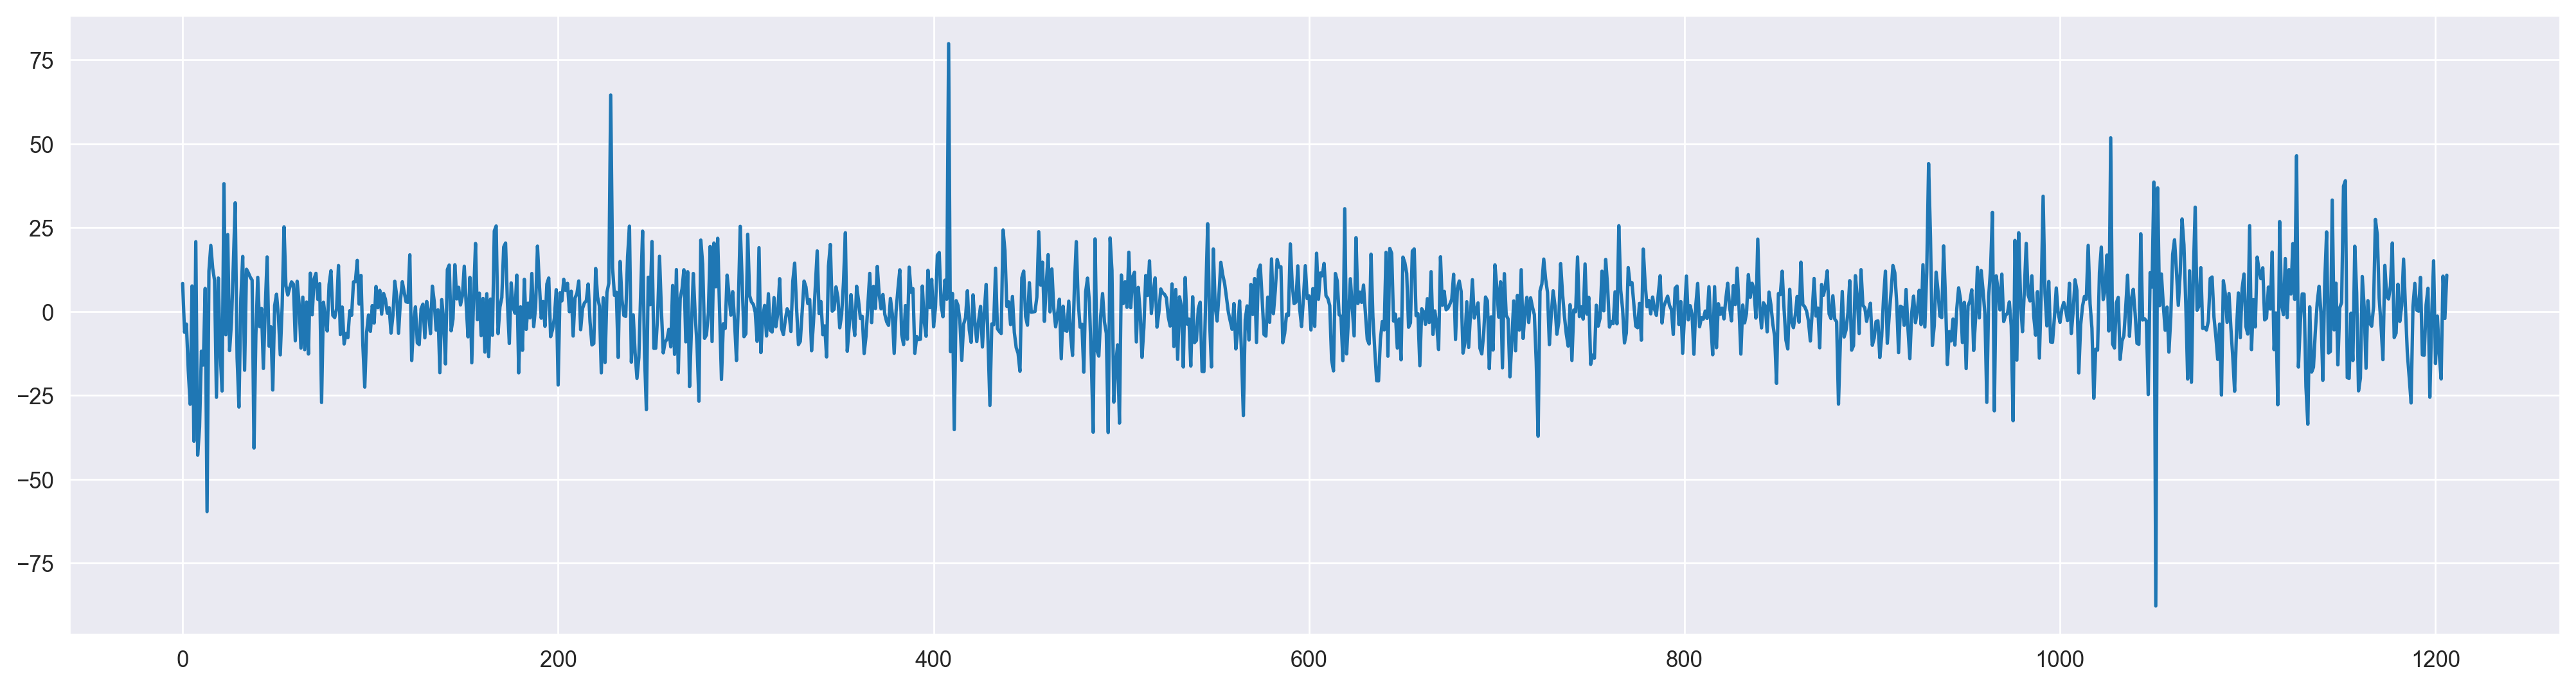

In [44]:
ICICI_dataset['close_diff'].plot()

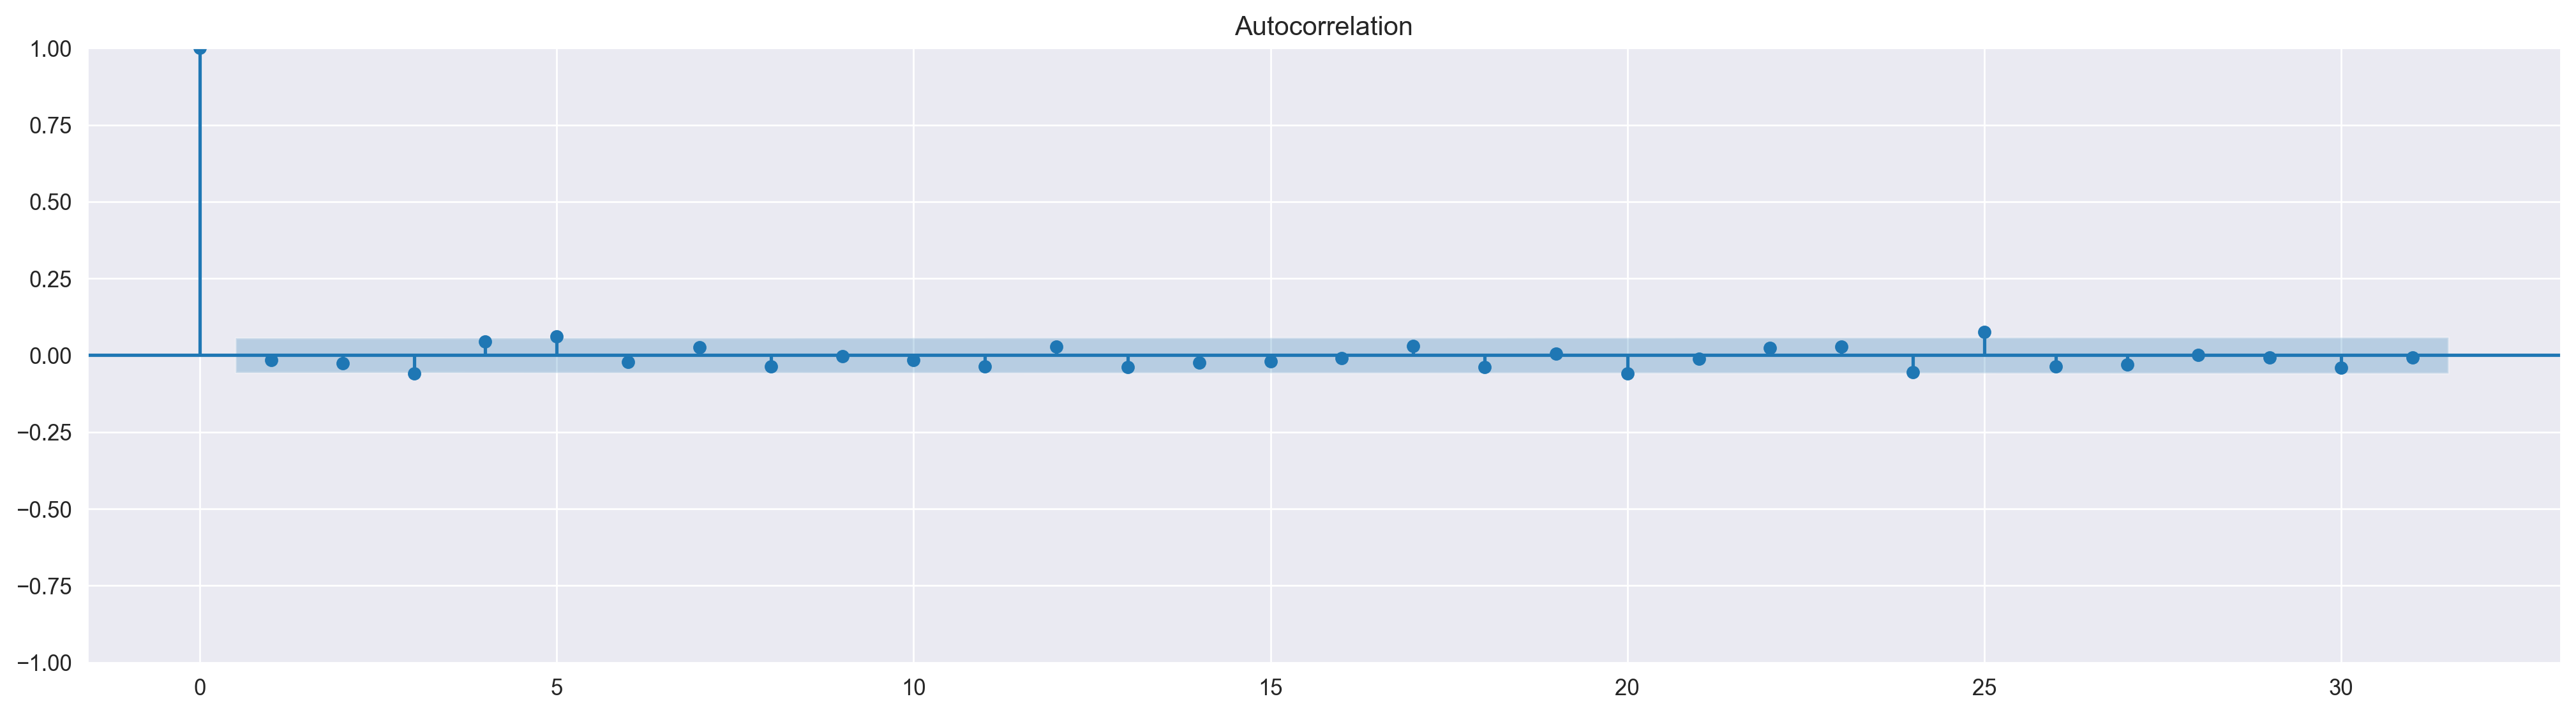

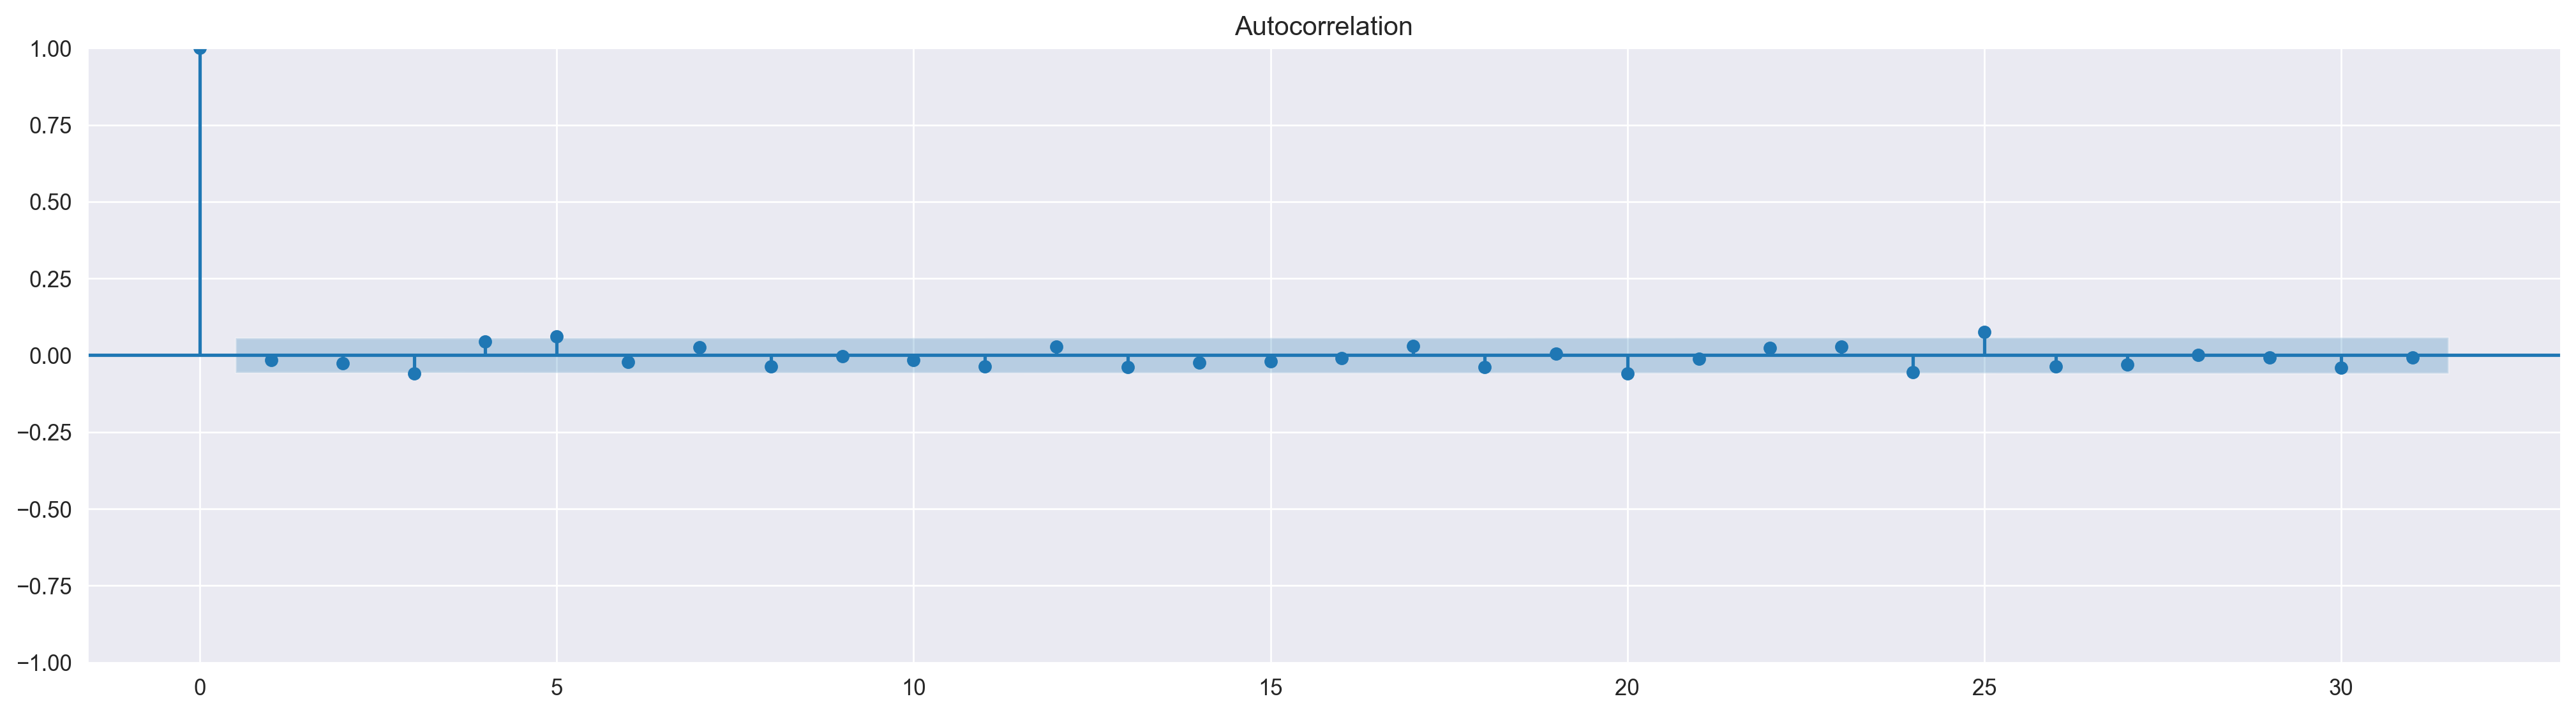

In [45]:
plot_acf(ICICI_dataset['close_diff'])

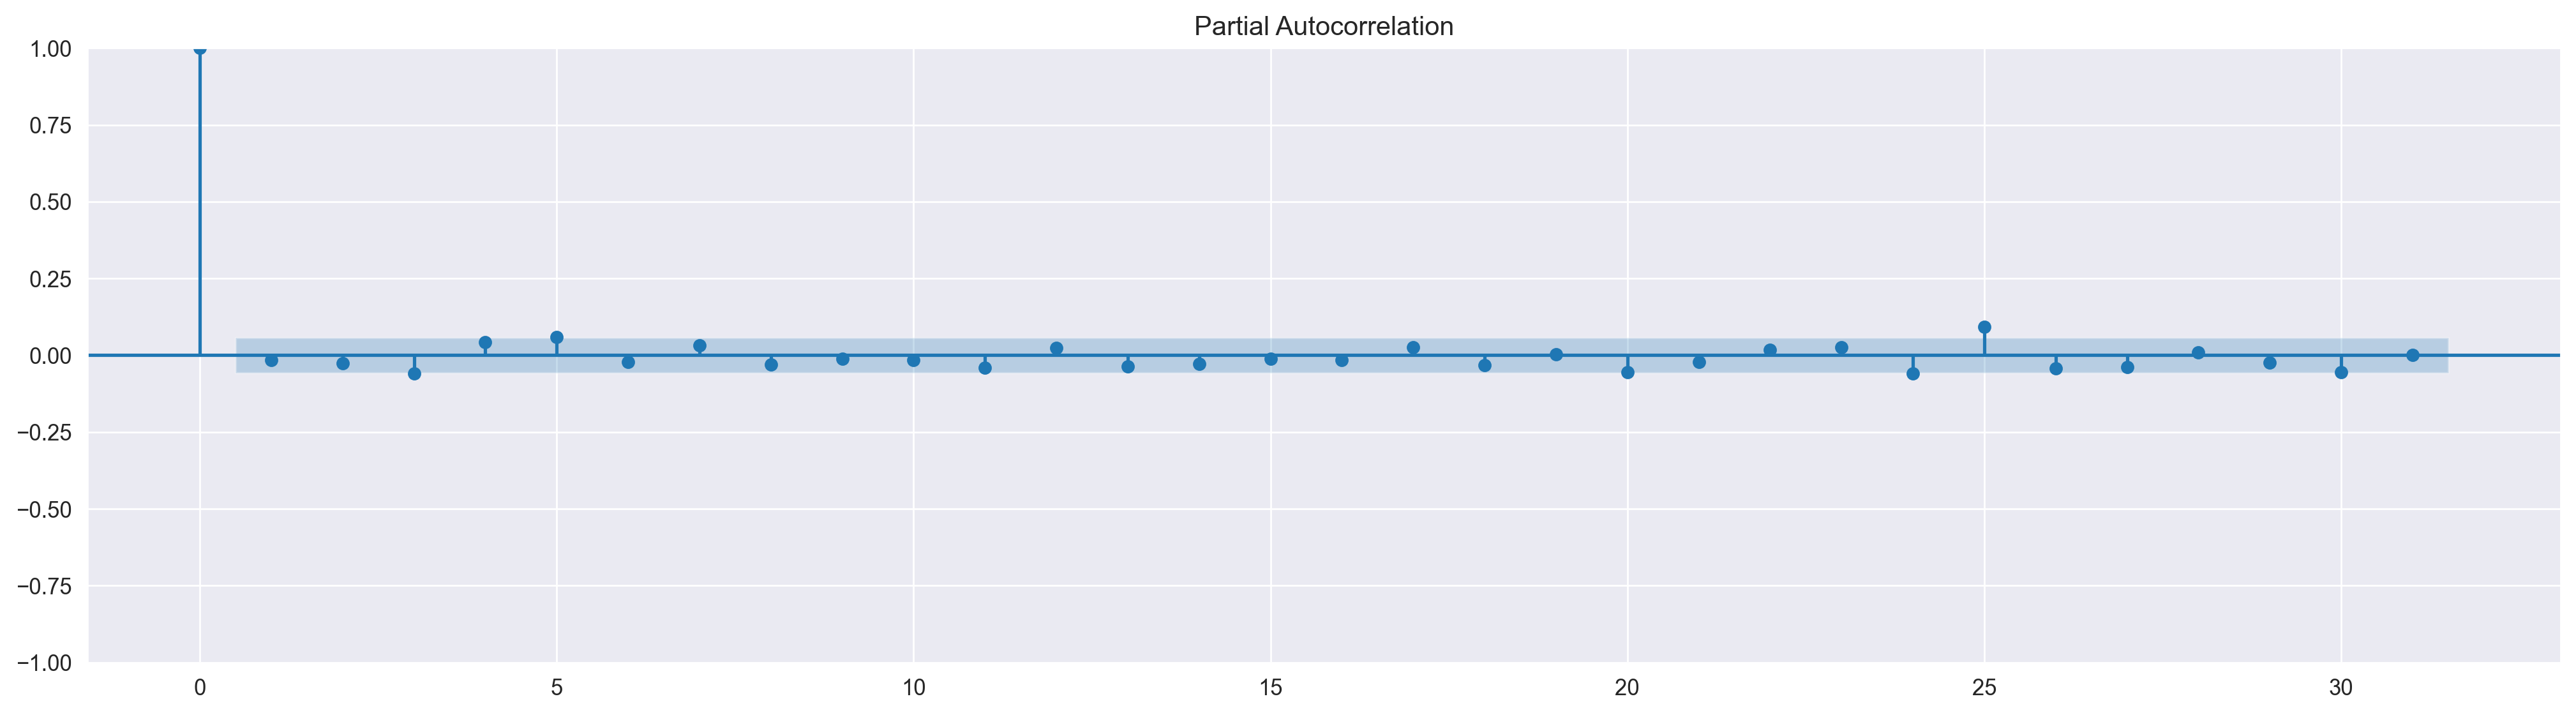

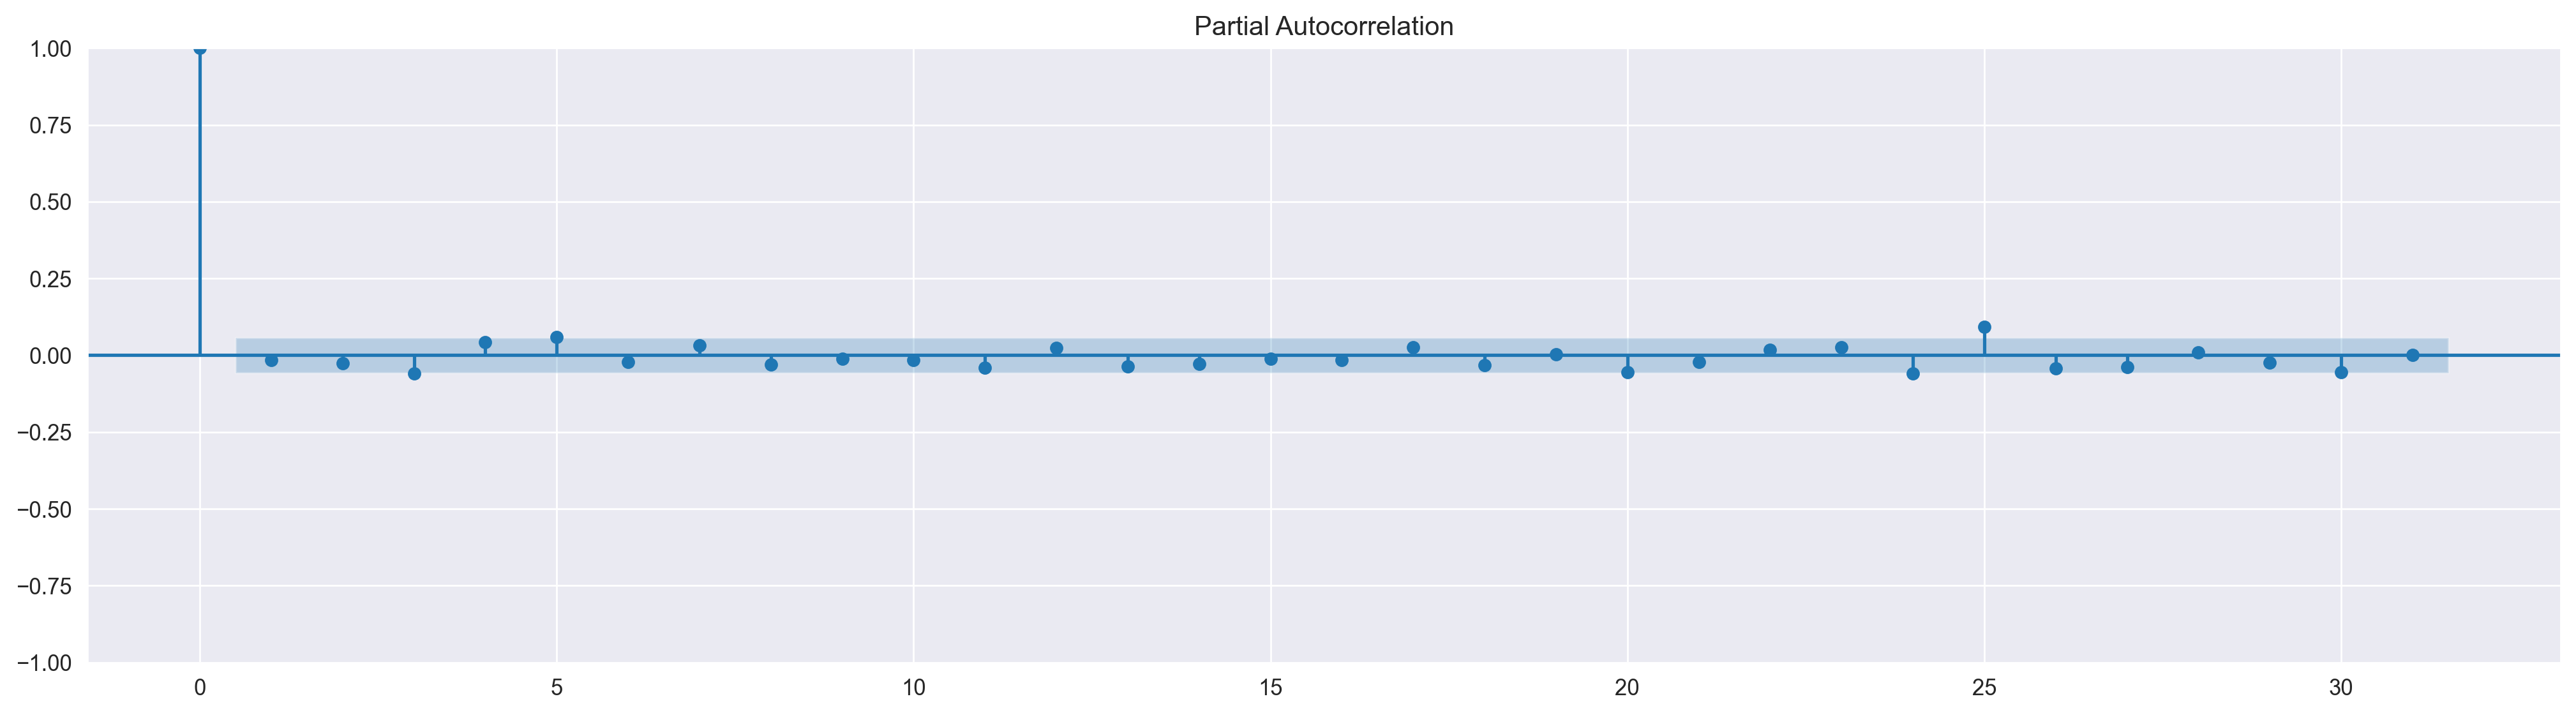

In [46]:
plot_pacf(ICICI_dataset['close_diff'])

In [47]:
# separate out a validation dataset
arima_train, arima_test = ICICI_dataset.iloc[:990], ICICI_dataset.iloc[990:]
print('Training Data %d, Testing Data %d' % (len(arima_train), len(arima_test)))

Training Data 990, Testing Data 217


In [48]:
arima_train.set_index('Date', inplace=True)
arima_train

Close         High          Low         Open    Volume  \
Date                                                                       
2020-03-03   497.587524   502.179153   491.545908   492.850903  19661945   
2020-03-04   491.400909   500.245830   480.477649   500.245830  21883404   
2020-03-05   487.679230   494.107503   483.329266   492.754187  16671516   
2020-03-06   470.134399   480.235964   461.386122   468.829404  31024353   
2020-03-09   442.488007   459.162869   428.181470   459.162869  42027175   
...                 ...          ...          ...          ...       ...   
2024-02-22  1053.629517  1056.901399  1031.420804  1046.986751  13432573   
2024-02-23  1052.241455  1060.867149  1048.622585  1060.867149  13142759   
2024-02-26  1045.202026  1053.232987  1041.533655  1044.111439   7875941   
2024-02-27  1051.150757  1057.099545  1037.567740  1041.781464  10580973   
2024-02-28  1037.270264  1055.761104  1033.254904  1053.926918   7730332   

            Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  \
Date                                                                            
2020-03-03      4.736621       1.709150   499.617510   513.334392    1.533472   
2020-03-04     -8.844920      -1.243322   496.648485   512.602956    1.543645   
2020-03-05     -5.074957      -0.757361   492.995893   512.011684    1.525437   
2020-03-06      1.304995      -3.597617   487.838078   510.679307    1.639035   
2020-03-09    -16.674862      -5.880530   479.883859   508.227217    1.910320   
...                  ...            ...          ...          ...         ...   
2024-02-22      6.642765       1.021919  1029.671483  1007.341339    1.440442   
2024-02-23     -8.625694      -0.131741  1035.138698  1009.596922    1.427682   
2024-02-26      1.090587      -0.668994  1040.457188  1011.680648    1.435206   
2024-02-27      9.369292       0.569146  1045.690691  1013.554513    1.423726   
2024-02-28    -16.656654      -1.320505  1046.037685  1014.755835    1.447397   

            close_diff  
Date                    
2020-03-03    8.361603  
2020-03-04   -6.186615  
2020-03-05   -3.721680  
2020-03-06  -17.544830  
2020-03-09  -27.646393  
...                ...  
2024-02-22   10.658325  
2024-02-23   -1.388062  
2024-02-26   -7.039429  
2024-02-27    5.948730  
2024-02-28  -13.880493  

[990 rows x 11 columns]

In [49]:
arima_test.set_index('Date', inplace=True)
arima_test

Close         High          Low         Open    Volume  \
Date                                                                       
2024-02-29  1043.219116  1051.646566  1029.636098  1034.147311  20944844   
2024-03-01  1077.622925  1080.646819  1045.003714  1045.995179  14909562   
2024-03-04  1083.026367  1085.653773  1070.880925  1071.773268  11424581   
2024-03-05  1078.763184  1090.115406  1067.311718  1076.928877   9222544   
2024-03-06  1087.735840  1104.045506  1071.079306  1071.079306  21796484   
...                 ...          ...          ...          ...       ...   
2025-01-10  1249.849976  1264.949951  1243.099976  1259.000000   7854524   
2025-01-13  1229.750000  1243.949951  1224.900024  1234.900024   9669336   
2025-01-14  1240.300049  1244.849976  1227.449951  1233.349976  10342698   
2025-01-15  1238.250000  1244.400024  1230.000000  1234.000000   5355382   
2025-01-16  1249.099976  1255.500000  1239.650024  1245.099976  11895924   

            Daily Change  Daily Returns     7-Day MA    30-Day MA  Volatility  \
Date                                                                            
2024-02-29      9.071805       0.573510  1046.526332  1016.181891    1.449078   
2024-03-01     31.627746       3.297851  1051.476580  1019.656974    1.455670   
2024-03-04     11.253099       0.501422  1055.676130  1023.160148    1.455775   
2024-03-05      1.834306      -0.393636  1059.464948  1026.096537    1.450470   
2024-03-06     16.656533       0.831754  1065.541207  1028.345506    1.363239   
...                  ...            ...          ...          ...         ...   
2025-01-10     -9.150024      -0.994142  1267.857143  1301.735010    0.923844   
2025-01-13     -5.150024      -1.608191  1259.164289  1299.390011    0.937064   
2025-01-14      6.950073       0.857902  1255.628575  1297.245011    0.951467   
2025-01-15      4.250000      -0.165287  1251.935721  1294.906677    0.947641   
2025-01-16      4.000000       0.876235  1247.628575  1292.675008    0.957192   

            close_diff  
Date                    
2024-02-29    5.948853  
2024-03-01   34.403809  
2024-03-04    5.403442  
2024-03-05   -4.263184  
2024-03-06    8.972656  
...                ...  
2025-01-10  -12.550049  
2025-01-13  -20.099976  
2025-01-14   10.550049  
2025-01-15   -2.050049  
2025-01-16   10.849976  

[217 rows x 11 columns]

In [50]:
order = auto_arima(arima_train['close_diff'].dropna())
order

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

In [51]:
model = ARIMA(arima_train['close_diff'].dropna(), order=(2, 0, 2)).fit()
ypred = model.predict(start=990, end=1206)

ypred_series = pd.Series(ypred.values, index=arima_test.index)

mae_arima = mean_absolute_error(arima_test['close_diff'], ypred)
mse_arima = mean_squared_error(arima_test['close_diff'], ypred)
rmse_arima = root_mean_squared_error(arima_test['close_diff'], ypred)
r2_arima = r2_score(arima_test['close_diff'], ypred)

# Print the evaluation results
# Print the evaluation results
print("Mean Squared Error:", mse_arima)
print("Root Mean Squared Error:",rmse_arima)
print("Mean Absolute Error:", mae_arima)
print("R-squared:", r2_arima)

Mean Squared Error: 236.1153134376755
Root Mean Squared Error: 15.366044170106875
Mean Absolute Error: 10.93687369529866
R-squared: -0.00031915270013249675


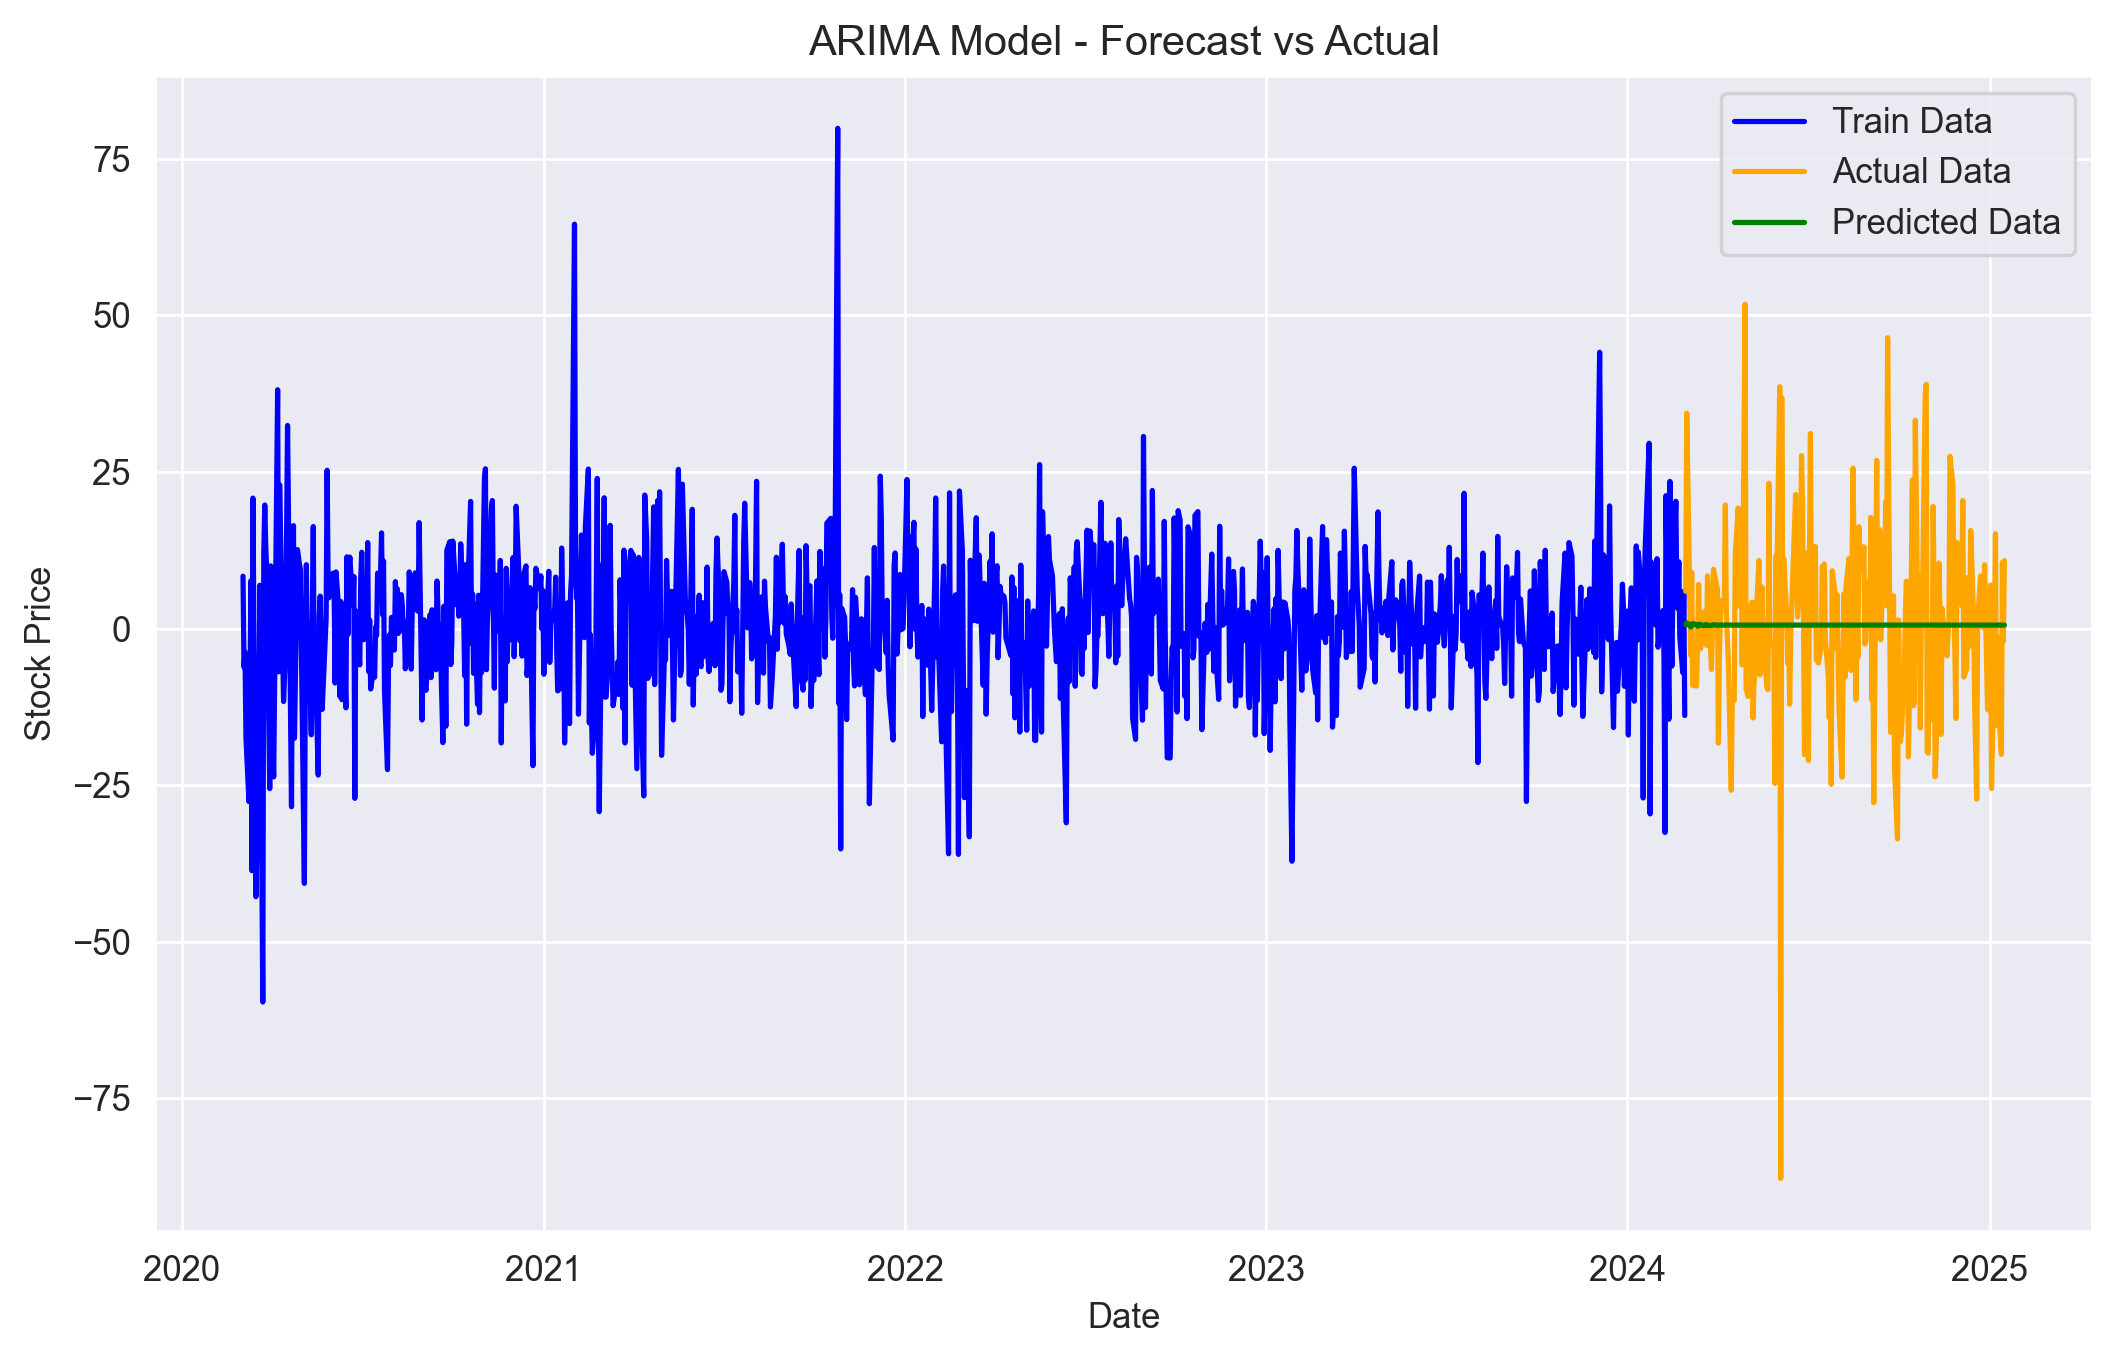

In [52]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(arima_train['close_diff'], label='Train Data', color='blue')
plt.plot(arima_test['close_diff'], label='Actual Data', color='orange')
plt.plot(ypred_series, label='Predicted Data', color='green')
plt.title('ARIMA Model - Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### c) FB Prophet

In [53]:
#!pip install prophet

In [54]:
from prophet import Prophet
prophet_data = ICICI_dataset[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Split the data into training and testing datasets
train_size = int(len(prophet_data) * 0.8)
train_data, test_data = prophet_data[:train_size], prophet_data[train_size:]

# Train the model
model = Prophet()
model.fit(prophet_data)

future = model.make_future_dataframe(periods=100)
forecast = model.predict(future)
forecast

17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2020-03-03   399.981493   350.042224   418.097780   399.981493   
1    2020-03-04   399.365380   347.569609   416.111281   399.365380   
2    2020-03-05   398.749267   342.650256   411.672532   398.749267   
3    2020-03-06   398.133154   341.585366   413.265978   398.133154   
4    2020-03-09   396.284815   338.714067   405.784776   396.284815   
...         ...          ...          ...          ...          ...   
1302 2025-04-22  1430.565809  1357.984213  1460.993752  1395.236939   
1303 2025-04-23  1431.447163  1360.072870  1459.235805  1395.625864   
1304 2025-04-24  1432.328517  1361.035623  1462.554742  1395.434319   
1305 2025-04-25  1433.209871  1359.754870  1463.976645  1395.478037   
1306 2025-04-26  1434.091224  1393.240370  1495.474865  1395.566823   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      399.981493      -14.962718            -14.962718            -14.962718   
1      399.365380      -16.943554            -16.943554            -16.943554   
2      398.749267      -18.894282            -18.894282            -18.894282   
3      398.133154      -20.888957            -20.888957            -20.888957   
4      396.284815      -24.686884            -24.686884            -24.686884   
...           ...             ...                   ...                   ...   
1302  1464.871779      -20.896469            -20.896469            -20.896469   
1303  1466.211502      -21.083150            -21.083150            -21.083150   
1304  1467.680089      -21.313969            -21.313969            -21.313969   
1305  1468.991141      -21.668881            -21.668881            -21.668881   
1306  1470.873362       11.759965             11.759965             11.759965   

         weekly  weekly_lower  weekly_upper     yearly  yearly_lower  \
0    -11.799345    -11.799345    -11.799345  -3.163373     -3.163373   
1    -12.686145    -12.686145    -12.686145  -4.257409     -4.257409   
2    -13.471688    -13.471688    -13.471688  -5.422594     -5.422594   
3    -14.234799    -14.234799    -14.234799  -6.654158     -6.654158   
4    -13.996985    -13.996985    -13.996985 -10.689899    -10.689899   
...         ...           ...           ...        ...           ...   
1302 -11.799345    -11.799345    -11.799345  -9.097124     -9.097124   
1303 -12.686145    -12.686145    -12.686145  -8.397005     -8.397005   
1304 -13.471688    -13.471688    -13.471688  -7.842281     -7.842281   
1305 -14.234799    -14.234799    -14.234799  -7.434082     -7.434082   
1306  18.930473     18.930473     18.930473  -7.170507     -7.170507   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0        -3.163373                   0.0                         0.0   
1        -4.257409                   0.0                         0.0   
2        -5.422594                   0.0                         0.0   
3        -6.654158                   0.0                         0.0   
4       -10.689899                   0.0                         0.0   
...            ...                   ...                         ...   
1302     -9.097124                   0.0                         0.0   
1303     -8.397005                   0.0                         0.0   
1304     -7.842281                   0.0                         0.0   
1305     -7.434082                   0.0                         0.0   
1306     -7.170507                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
0                            0.0   385.018775  
1                            0.0   382.421826  
2                            0.0   379.854985  
3                            0.0   377.244197  
4                            0.0   371.597931  
...                          ...          ...  
1302                         0.0  1409.669341  
1303                         0.0  1410.364013  
1304                     

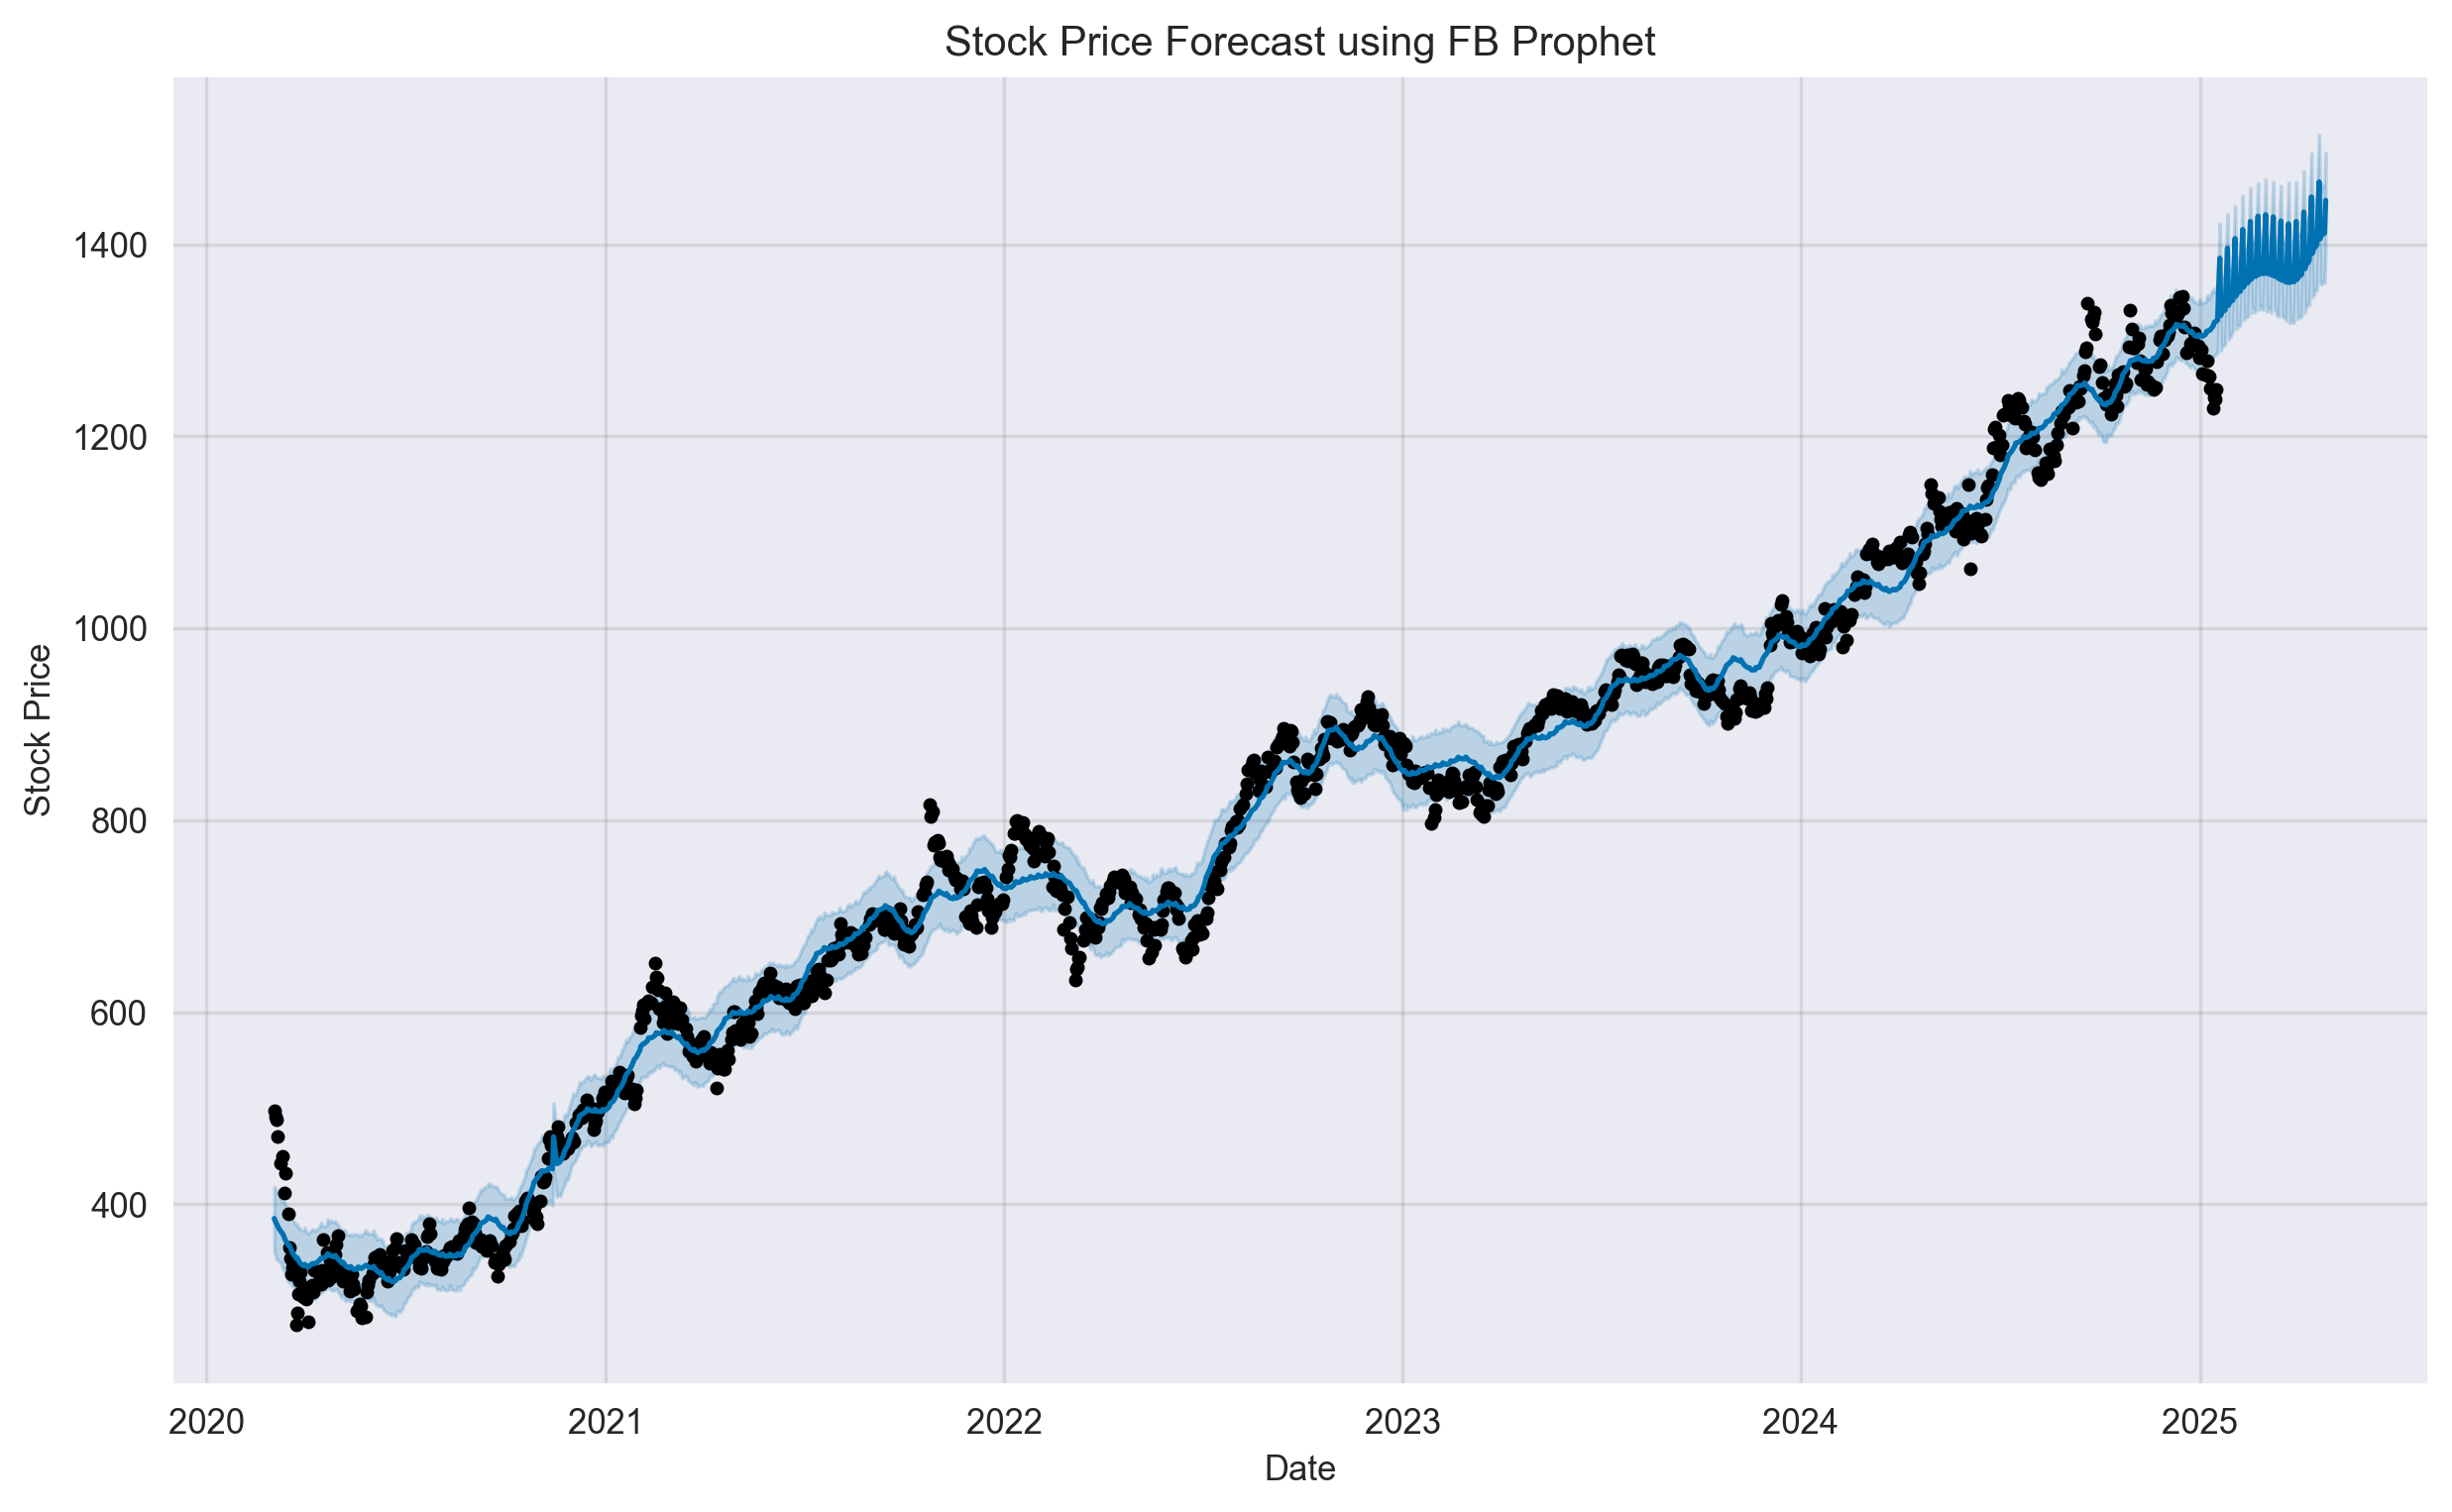

In [55]:
# Visualize the forecast
model.plot(forecast)
plt.title('Stock Price Forecast using FB Prophet')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [56]:
# Evaluate model performance on the test set
y_test = test_data['y'].values  # Actual values from the test set
y_pred = forecast['yhat'][-len(test_data):].values  # Predicted values for the test set

mae_fbp = mean_absolute_error(y_test, y_pred)
mse_fbp = mean_squared_error(y_test, y_pred)
rmse_fbp = root_mean_squared_error(y_test, y_pred)
r2_fbp = r2_score(y_test, y_pred)

# Print the evaluation results
print('FB Prophet')
print("Mean Squared Error:", mse_fbp)
print("Root Mean Squared Error:",rmse_fbp)
print("Mean Absolute Error:", mae_fbp)
print("R-squared:", r2_fbp)

FB Prophet
Mean Squared Error: 16868.152406144713
Root Mean Squared Error: 129.8774514923384
Mean Absolute Error: 123.4945898796266
R-squared: -0.7929087826866617


### d) StatsForecast

In [57]:
#!pip install statsforecast

In [58]:
New_data = ICICI_dataset.loc[:,['Date','Close']]
New_data = New_data.rename(columns={'Date': 'ds', 'Close': 'y'})
New_data['unique_id'] = 'ICICI'
New_data

ds            y unique_id
0    2020-03-03   497.587524     ICICI
1    2020-03-04   491.400909     ICICI
2    2020-03-05   487.679230     ICICI
3    2020-03-06   470.134399     ICICI
4    2020-03-09   442.488007     ICICI
...         ...          ...       ...
1202 2025-01-10  1249.849976     ICICI
1203 2025-01-13  1229.750000     ICICI
1204 2025-01-14  1240.300049     ICICI
1205 2025-01-15  1238.250000     ICICI
1206 2025-01-16  1249.099976     ICICI

[1207 rows x 3 columns]

In [59]:
train_data = New_data.iloc[:1000,:]
test_data = New_data.iloc[1000:,:]

In [60]:
train_data

ds            y unique_id
0   2020-03-03   497.587524     ICICI
1   2020-03-04   491.400909     ICICI
2   2020-03-05   487.679230     ICICI
3   2020-03-06   470.134399     ICICI
4   2020-03-09   442.488007     ICICI
..         ...          ...       ...
995 2024-03-07  1078.663940     ICICI
996 2024-03-11  1069.492920     ICICI
997 2024-03-12  1067.658691     ICICI
998 2024-03-13  1074.698120     ICICI
999 2024-03-14  1074.351074     ICICI

[1000 rows x 3 columns]

In [61]:
test_data

ds            y unique_id
1000 2024-03-15  1071.128784     ICICI
1001 2024-03-18  1071.971558     ICICI
1002 2024-03-19  1074.698120     ICICI
1003 2024-03-20  1075.243408     ICICI
1004 2024-03-21  1072.566528     ICICI
...         ...          ...       ...
1202 2025-01-10  1249.849976     ICICI
1203 2025-01-13  1229.750000     ICICI
1204 2025-01-14  1240.300049     ICICI
1205 2025-01-15  1238.250000     ICICI
1206 2025-01-16  1249.099976     ICICI

[207 rows x 3 columns]

In [62]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoCES, AutoTheta, AutoMFLES

sf = StatsForecast(models=[AutoARIMA(), AutoETS(), AutoCES(), AutoTheta()], freq='B')
y_hat = sf.forecast(h=207, df=train_data)
y_hat

unique_id         ds    AutoARIMA      AutoETS          CES    AutoTheta
0       ICICI 2024-03-15  1074.928415  1074.354896  1075.090698  1074.710938
1       ICICI 2024-03-18  1075.505756  1074.357327  1075.788208  1075.064575
2       ICICI 2024-03-19  1076.083097  1074.359546  1076.524780  1075.418213
3       ICICI 2024-03-20  1076.660438  1074.361571  1077.230957  1075.771851
4       ICICI 2024-03-21  1077.237779  1074.363420  1077.962280  1076.125610
..        ...        ...          ...          ...          ...          ...
202     ICICI 2024-12-24  1191.551274  1074.382730  1230.514404  1145.718872
203     ICICI 2024-12-25  1192.128615  1074.382730  1231.337280  1146.063965
204     ICICI 2024-12-26  1192.705955  1074.382730  1232.160767  1146.408936
205     ICICI 2024-12-27  1193.283296  1074.382730  1232.984741  1146.753784
206     ICICI 2024-12-30  1193.860637  1074.382730  1233.809326  1147.098511

[207 rows x 6 columns]

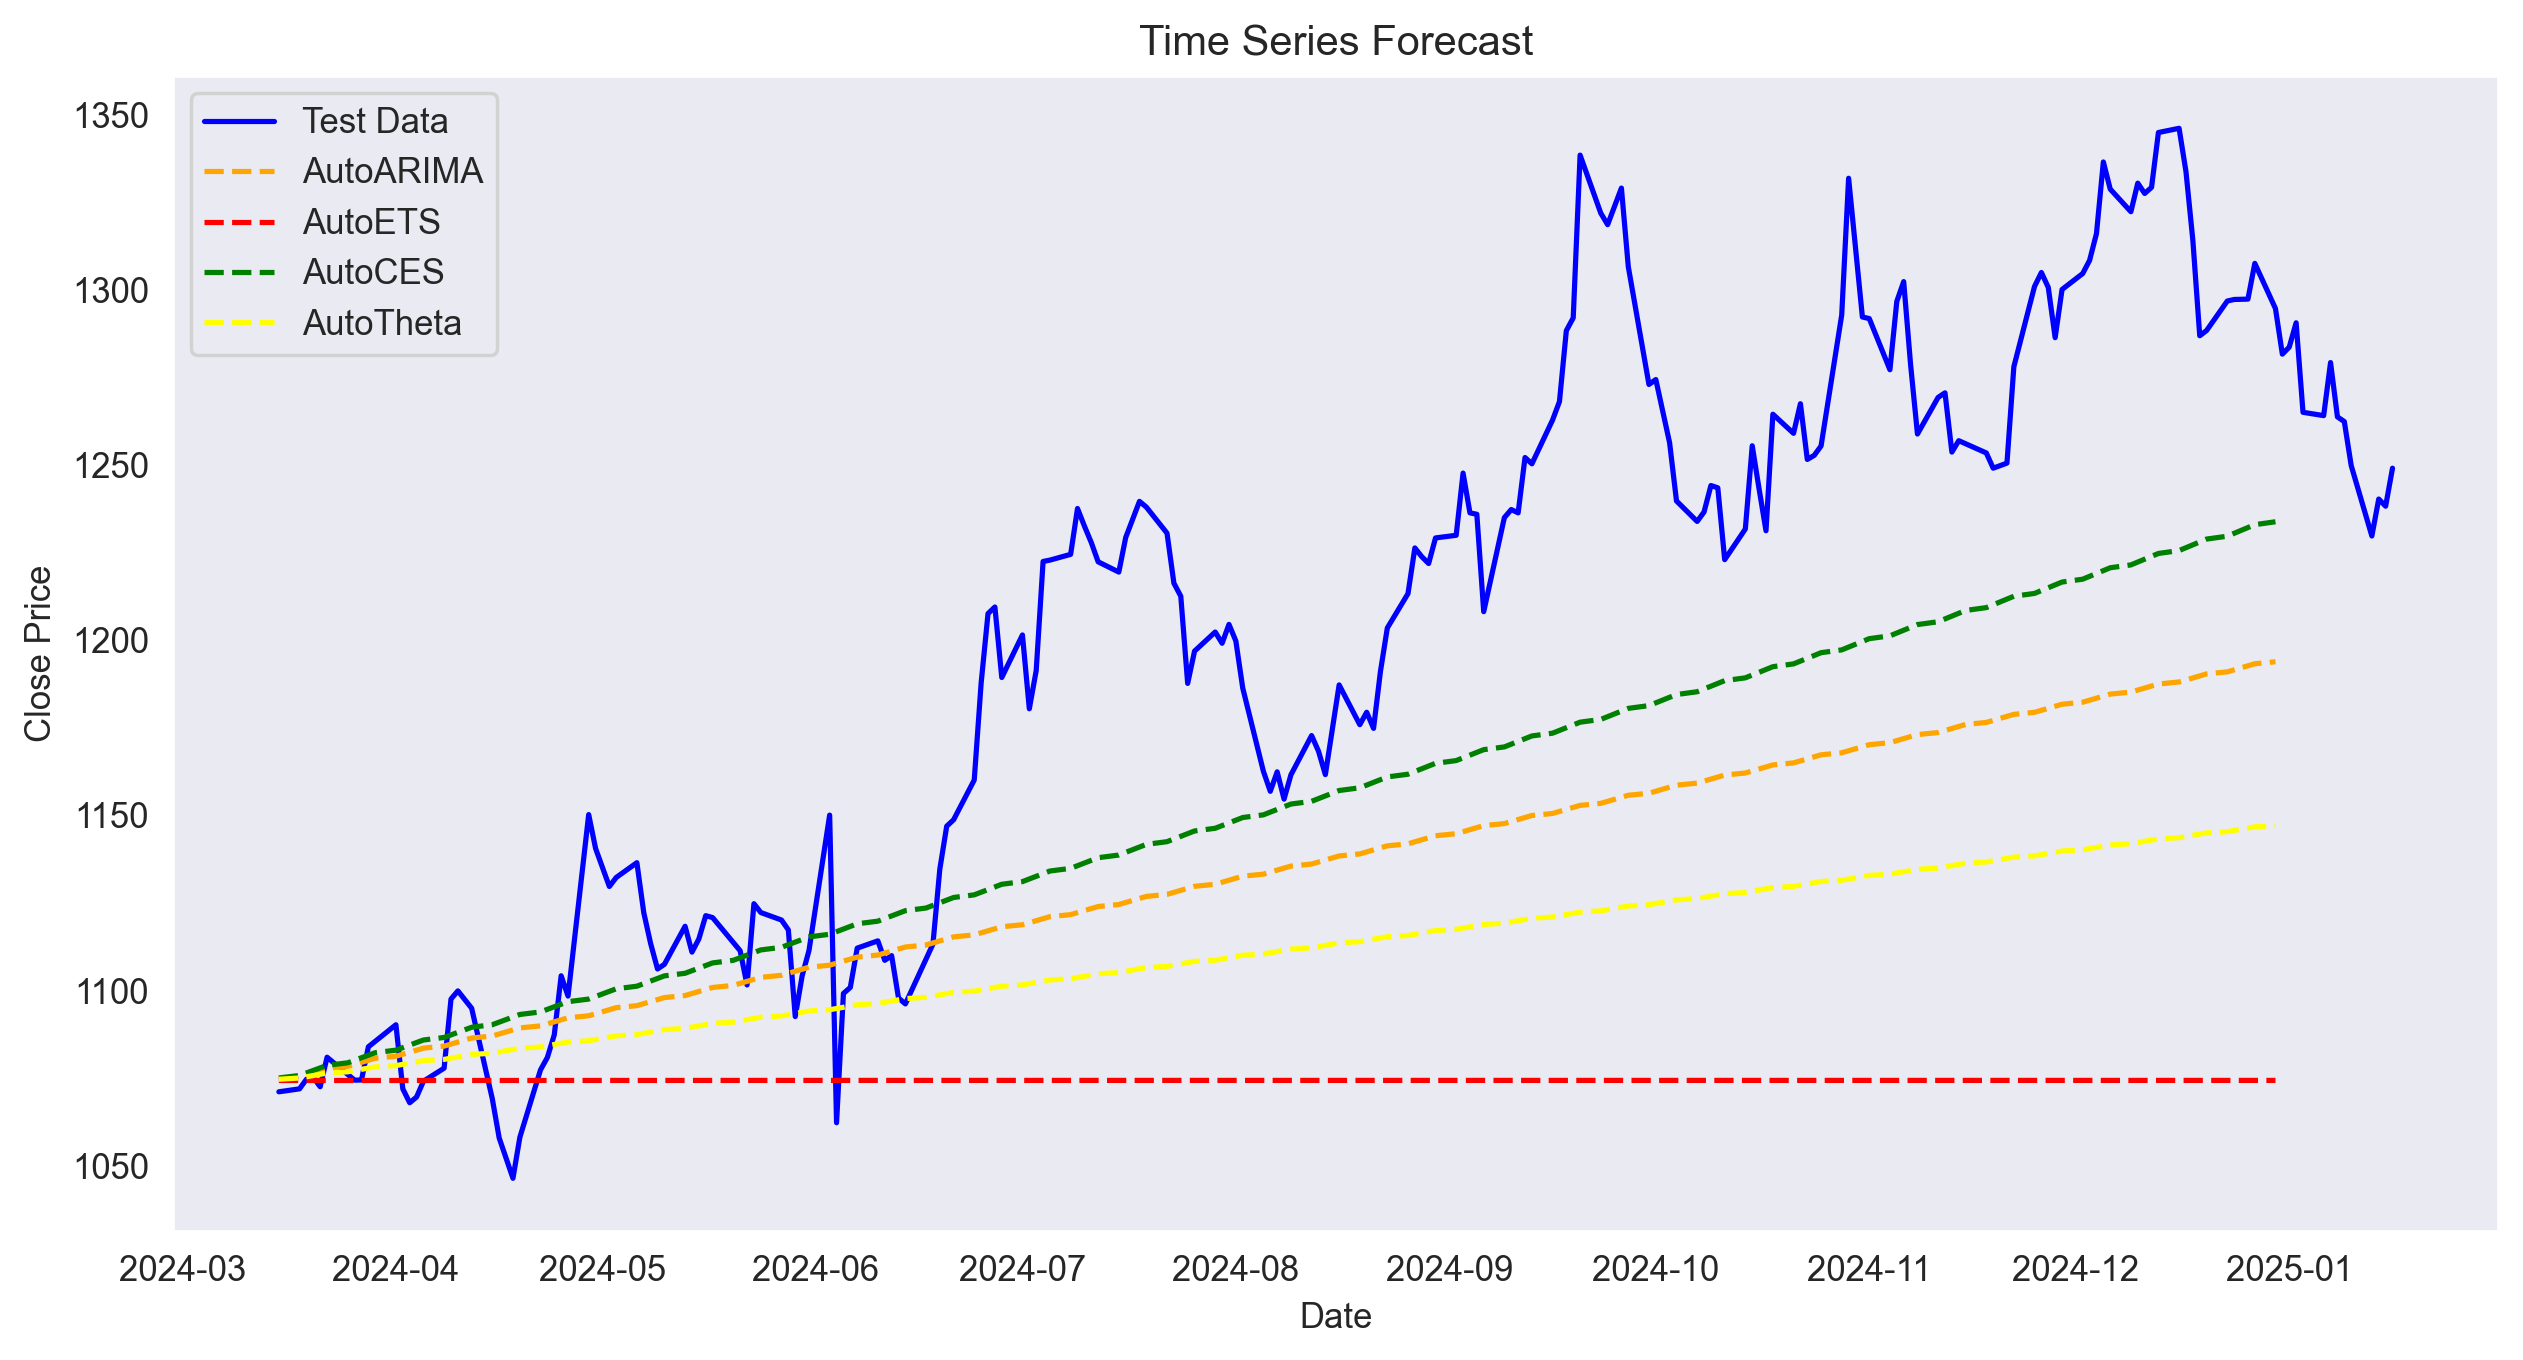

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['ds'], test_data['y'], label='Test Data', color='blue')
plt.plot(y_hat['ds'], y_hat['AutoARIMA'], label='AutoARIMA', color='orange', linestyle='--')
plt.plot(y_hat['ds'], y_hat['AutoETS'], label='AutoETS', color='red', linestyle='--')
plt.plot(y_hat['ds'], y_hat['CES'], label='AutoCES', color='green', linestyle='--')
plt.plot(y_hat['ds'], y_hat['AutoTheta'], label='AutoTheta', color='yellow', linestyle='--')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [64]:
mae_auto_arima = mean_absolute_error(test_data['y'], y_hat['AutoARIMA'])
mse_auto_arima = mean_squared_error(test_data['y'], y_hat['AutoARIMA'])
rmse_auto_arima = root_mean_squared_error(test_data['y'], y_hat['AutoARIMA'])
r2_auto_arima = r2_score(test_data['y'], y_hat['AutoARIMA'])

# Print the evaluation results
print('AutoARIMA')
print("Mean Squared Error:", mse_auto_arima)
print("Root Mean Squared Error:",rmse_auto_arima)
print("Mean Absolute Error:", mae_auto_arima)
print("R-squared:", r2_auto_arima)

AutoARIMA
Mean Squared Error: 7738.816397114941
Root Mean Squared Error: 87.9705427806089
Mean Absolute Error: 73.28282316126466
R-squared: -0.16300589620037664


In [65]:
mae_auto_ets = mean_absolute_error(test_data['y'], y_hat['AutoETS'])
mse_auto_ets = mean_squared_error(test_data['y'], y_hat['AutoETS'])
rmse_auto_ets = root_mean_squared_error(test_data['y'], y_hat['AutoETS'])
r2_auto_ets = r2_score(test_data['y'], y_hat['AutoETS'])

# Print the evaluation results
print('AutoETS')
print("Mean Squared Error:", mse_auto_ets)
print("Root Mean Squared Error:",rmse_auto_ets)
print("Mean Absolute Error:", mae_auto_ets)
print("R-squared:", r2_auto_ets)

AutoETS
Mean Squared Error: 23687.43254270355
Root Mean Squared Error: 153.90722056714412
Mean Absolute Error: 131.47007352407346
R-squared: -2.5597980749721807


In [66]:
mae_auto_ces = mean_absolute_error(test_data['y'], y_hat['CES'])
mse_auto_ces = mean_squared_error(test_data['y'], y_hat['CES'])
rmse_auto_ces = root_mean_squared_error(test_data['y'], y_hat['CES'])
r2_auto_ces = r2_score(test_data['y'], y_hat['CES'])

# Print the evaluation results
print('AutoCES')
print("Mean Squared Error:", mse_auto_ces)
print("Root Mean Squared Error:",rmse_auto_ces)
print("Mean Absolute Error:", mae_auto_ces)
print("R-squared:", r2_auto_ces)

AutoCES
Mean Squared Error: 4757.86677867822
Root Mean Squared Error: 68.97729176097174
Mean Absolute Error: 56.22379203464674
R-squared: 0.2849775943771524


In [67]:
mae_auto_theta = mean_absolute_error(test_data['y'], y_hat['AutoTheta'])
mse_auto_theta = mean_squared_error(test_data['y'], y_hat['AutoTheta'])
rmse_auto_theta = root_mean_squared_error(test_data['y'], y_hat['AutoTheta'])
r2_auto_theta = r2_score(test_data['y'], y_hat['AutoTheta'])

# Print the evaluation results
print('AutoTheta')
print("Mean Squared Error:", mse_auto_theta)
print("Root Mean Squared Error:",rmse_auto_theta)
print("Mean Absolute Error:", mae_auto_theta)
print("R-squared:", r2_auto_theta)

AutoTheta
Mean Squared Error: 12803.60180273501
Root Mean Squared Error: 113.1530017398346
Mean Absolute Error: 95.58382102487168
R-squared: -0.924152690162527


## Model Evaluation

In [68]:
evaluation = {"Models":["Linear","Exponential","Quadratic","Additive Seasonal","Additive Quadratic","Multiplicative Seasonal","Multiplicative Additive",
                        "Holt's Winter","ARIMA","FB Prophet","AutoARIMA","AutoETS","CES","AutoTheta"],\
            "Mean_Squared_Error":[mse_linear, mse_exp, mse_qua, mse_add_sea, mse_add_sea_quad, mse_mult_sea, mse_add_mult_sea,
                                 mse_exp, mse_arima, mse_fbp, mse_auto_arima, mse_auto_ets, mse_auto_ces, mse_auto_theta],
            "Root_Mean_Squared_Error":[rmse_linear, rmse_exp, rmse_qua, rmse_add_sea, rmse_add_sea_quad, rmse_mult_sea, rmse_add_mult_sea,
                                      rmse_exp, rmse_arima, rmse_fbp, rmse_auto_arima, rmse_auto_ets, rmse_auto_ces, rmse_auto_theta],\
            "Mean_Absolute_Error":[mae_linear, mae_exp, mae_qua, mae_add_sea, mae_add_sea_quad, mae_mult_sea, mae_add_mult_sea,
                                  rmse_exp, mae_arima, mae_fbp, mae_auto_arima, mae_auto_ets, mae_auto_ces, mae_auto_theta],\
            "R2_Score":[r2_linear, r2_exp, r2_qua, r2_add_sea, r2_add_sea_quad, r2_mult_sea, r2_add_mult_sea,
                       r2_exp, r2_arima, r2_fbp, r2_auto_arima, r2_auto_ets, r2_auto_ces, r2_auto_theta]}
evaluation = pd.DataFrame(evaluation)
sorted_df = evaluation.sort_values(by='Root_Mean_Squared_Error')
sorted_df

Models  Mean_Squared_Error  Root_Mean_Squared_Error  \
8                     ARIMA          236.115313                15.366044   
12                      CES         4757.866779                68.977292   
0                    Linear         7128.493140                84.430404   
10                AutoARIMA         7738.816397                87.970543   
1               Exponential         8034.944097                89.637850   
7             Holt's Winter         8034.944097                89.637850   
13                AutoTheta        12803.601803               113.153002   
6   Multiplicative Additive        13659.851841               116.875369   
9                FB Prophet        16868.152406               129.877451   
11                  AutoETS        23687.432543               153.907221   
2                 Quadratic        41568.594460               203.883777   
4        Additive Quadratic        44398.117577               210.708608   
3         Additive Seasonal       258777.740558               508.702015   
5   Multiplicative Seasonal       296749.800951               544.747465   

    Mean_Absolute_Error   R2_Score  
8             10.936874  -0.000319  
12            56.223792   0.284978  
0             70.754547   0.009779  
10            73.282823  -0.163006  
1             75.553960  -0.116136  
7             89.637850  -0.116136  
13            95.583821  -0.924153  
6            100.062403  -0.897493  
9            123.494590  -0.792909  
11           131.470074  -2.559798  
2            190.212300  -4.774303  
4            200.218765  -5.167353  
3            506.145392 -34.946878  
5            542.088849 -40.221586

#### ARIMA model gives the best accuracy among the other forecasted models

In [69]:
# Train the model on the full dataset 
model = ARIMA(ICICI_dataset['close_diff'],  order = (2, 0, 2)) 
result = model.fit() 

### Deployment

In [70]:
import pickle

In [71]:
# We have selected Random Forest Classifier for model building as it is  showing 100% accuracy
pickle.dump(result, open('arima_model.pkl','wb'))